# Statistical analysis


---

**Author**: Olivier Chalifour
**Organisation**: UQAM
**Date**: 26 July 2021

---



In [1]:
import numpy as np
import pandas as pd
import glob
import os
import matplotlib.pyplot as plt
from datetime import datetime,timedelta
from matplotlib.colors import ListedColormap, BoundaryNorm, TwoSlopeNorm, LinearSegmentedColormap, LogNorm
import statsmodels.api as sm
import statsmodels.tools as smt
import scipy.stats as statis
import sklearn.metrics as metrics
import pickle as pkl

In [2]:
data_path = sorted(glob.glob(fr"/upslope/chalifour/projet_maitrise/"))[0]


phase_list = ['f_0','f_60','f_67','f_69','f_70']
phase_list_simulation =['RN','FR','MX','SN']
phase_str = ['None',  'Rain', 'Freezing rain', 'Mix of snow and rain','Snow']

pType_color = ['k', 'tab:green', 'tab:red','tab:orange' ,'tab:blue',]

In [3]:
begin_1,end_1 = '2020-10','2021-04'
begin_2,end_2 = '2021-10','2022-04'
begin_date_1, end_date_1 = datetime.strptime(begin_1, '%Y-%m'), datetime.strptime(end_1, '%Y-%m')
begin_date_2, end_date_2 = datetime.strptime(begin_2, '%Y-%m'), datetime.strptime(end_2, '%Y-%m')
time_delta = timedelta(hours=5)
begin_t,end_t = '2020-10','2022-04'

begin_date_t, end_date_t = datetime.strptime(begin_1, '%Y-%m'), datetime.strptime(end_1, '%Y-%m')

# Station
HQ_compiled_savepath = os.path.join(data_path, r"data_format-master/Data.nosync/station_gmon/Full_datasets")

file_1h = glob.glob(HQ_compiled_savepath + '/dataset_1h.csv')

dataframe_1h = pd.read_csv(file_1h[0], parse_dates=['date'])
dataframe_1h.set_index('date', inplace=True)

list_stat_prob = []
# EST -> UTC
list_subdf_1h=[]

for stat,subdf in dataframe_1h.groupby('filename'):

    # subdf.index = subdf.index + time_delta
    subdf.loc[subdf['precip_inst_pluvio']<=0.2,['precip_inst_pluvio','f_0','f_60','f_70','f_69','f_67']]=0
    subdf.loc[subdf['f_0']<=0.2,'f_0']=0
    subdf = subdf.shift(periods=1,fill_value=np.nan)



    mask_fr = subdf['f_67'] / subdf['f_67'] == 1
    mask_solid = (subdf['f_70'] / subdf['f_70']) == 1
    mask_liquid = subdf['f_60'] / subdf['f_60'] == 1
    mask_mix = subdf['f_69'] / subdf['f_69'] == 1

    mask_mix_fr_t = (mask_fr & mask_solid) | (mask_liquid & mask_fr & mask_solid)| (mask_mix & mask_fr)
    mask_mix_t = ((mask_liquid & mask_solid) | mask_mix) & ~ mask_fr
    mask_solid_t = mask_solid & ~ (mask_liquid |  mask_fr | mask_mix_fr_t | mask_mix_t)
    mask_liquid_t = mask_liquid & ~ (mask_solid | mask_fr | mask_mix_fr_t | mask_mix_t)
    mask_fr_t = (mask_fr | (mask_fr & mask_liquid )) & ~ mask_mix_fr_t



    # subdf['MX'] = 0

    subdf.loc[mask_mix_t,'MX'] = subdf.loc[mask_mix_t,['f_60','f_70','f_69']].sum(axis=1)

    # subdf['MX_FR'] = 0
    subdf.loc[mask_mix_fr_t,'MX_FR'] = subdf.loc[mask_mix_fr_t,['f_60','f_70','f_69','f_67']].sum(axis=1)


    subdf.loc[mask_mix_t | mask_mix_fr_t ,['f_60','f_70','f_69','f_67']] = 0
    subdf.loc[mask_solid_t, 'SOL'] = subdf.loc[mask_solid_t,['f_70']].sum(axis=1)

    subdf.loc[mask_fr_t & (subdf.loc[mask_fr_t,'f_67']> subdf.loc[mask_fr_t,'f_60']),'f_67'] = subdf.loc[mask_fr_t & (subdf.loc[mask_fr_t,'f_67']> subdf.loc[mask_fr_t,'f_60']),['f_67','f_60']].sum(axis=1)
    subdf.loc[mask_fr_t& (subdf.loc[mask_fr_t,'f_67']<= subdf.loc[mask_fr_t,'f_60']),'f_60'] = subdf.loc[mask_fr_t & (subdf.loc[mask_fr_t,'f_67']<= subdf.loc[mask_fr_t,'f_60']),['f_67','f_60']].sum(axis=1)
    subdf.loc[mask_fr_t & (subdf.loc[mask_fr_t,'f_67']> subdf.loc[mask_fr_t,'f_60']),'f_60'] = 0
    subdf.loc[mask_fr_t& (subdf.loc[mask_fr_t,'f_67']<= subdf.loc[mask_fr_t,'f_60']),'f_67'] = 0


    # subdf.loc[mask_mix_fr_t,'FR'] = 0
    subdf.loc[np.isnan(subdf['MX_FR']),'MX_FR']=0
    subdf.loc[np.isnan(subdf['MX']),'MX']=0
    subdf.loc[np.isnan(subdf['SOL']),'SOL']=0

    subdf['frac_solide'] = subdf['SOL']
    subdf['frac_liquide'] = subdf['f_60']
    subdf['frac_FZ'] = subdf['f_67']

    subdf['frac_mix'] = subdf['MX']
    subdf['frac_mix_fr'] = subdf['MX_FR']

    subdf.sort_index(inplace=True)

    # if stat == 'LACROI_G':
    #     print(np.sum(subdf['f_0'])/np.sum(subdf['precip_inst_pluvio'])*100)
    #     print(subdf.loc[subdf['f_0']>=10,'f_0'])
    #     plt.plot(subdf.index,np.cumsum(subdf['f_0']))
    #     # subdf.loc[subdf['f_0']>=20,'f_0'] = 0
    #     plt.plot(subdf.index,np.cumsum(subdf['f_0']))
    #     plt.show()
    # print(stat, np.sum(subdf['f_0'])/np.sum(subdf['precip_inst_pluvio'])*100)


    subdf_1 = subdf.loc[begin_1:end_1]
    time_range_hours_1 = pd.date_range(begin_1,end_1.replace("5","6"),freq='H',closed='right')[:-1]
    subdf_2 = subdf.loc[begin_2:end_2]
    time_range_hours_2 = pd.date_range(begin_2,end_2.replace("5","6"),freq='H',closed='right')[:-1]



    if ((subdf_1['#nan_1h'].sum()/(4*len(time_range_hours_1))*100 < 10) and (stat not in list_stat_prob) and (subdf_1['precip_inst_pluvio'].sum()>0)) and ((subdf_2['#nan_1h'].sum()/(4*len(time_range_hours_2))*100 < 10) and (stat not in list_stat_prob) and (subdf_2['precip_inst_pluvio'].sum()>0)) and (np.sum(subdf['f_0'])/np.sum(subdf['precip_inst_pluvio'])*100 < 20 ):
        # print('Both Anne',stat, f"{np.sum(subdf['f_0'])/np.sum(np.sum(subdf[['frac_solide','frac_liquide','frac_FZ','frac_mix','frac_mix_fr']],axis=0))*100:.2f}")
        # if subdf_1.index[0] != time_range_hours_1[0]-pd.Timedelta('1h'):
        #     to_add_time = pd.date_range(time_range_hours_1[0]-pd.Timedelta('1h'),subdf_1.index[0],freq='H',closed='left')
        #
        #     a = np.empty((len(to_add_time),len(subdf_1.columns)))
        #     a[:] = np.nan
        #     new_row = pd.DataFrame(a, columns = subdf_1.columns, index=to_add_time)
        #     new_row['filename'] = stat
        #     subdf_1 = pd.concat([new_row,subdf_1])
        # if subdf_2.index[0] != time_range_hours_2[0]-pd.Timedelta('1h'):
        #     to_add_time = pd.date_range(time_range_hours_2[0]-pd.Timedelta('1h'),subdf_2.index[0],freq='H',closed='left')
        #
        #     a = np.empty((len(to_add_time),len(subdf_2.columns)))
        #     a[:] = np.nan
        #     new_row = pd.DataFrame(a, columns = subdf_2.columns, index=to_add_time)
        #     new_row['filename'] = stat
        #     subdf_2 = pd.concat([new_row,subdf_2])
        list_subdf_1h.append(pd.concat([subdf_1,subdf_2]))
    elif stat not in list_stat_prob:
        list_stat_prob.append(stat)


dataframe_1h = pd.concat(list_subdf_1h)

dataframe_1h.to_csv(f'/upslope/chalifour/projet_maitrise/dataframe_obs_formated/dataframe_1h_stat_formated_2year.csv')

print(list_stat_prob)

['ARGENT', 'BAUBERT', 'BETSIA_M', 'CONRAD', 'DIAMAND', 'GAREMANG', 'HARTJ_G', 'LACROI_G', 'LAVAL', 'MOUCHA_M', 'NOIRS', 'PARENT_G', 'PIPMUA_G', 'ROMA_SE', 'SM3CAM_G', 'STMARG_G', 'WABISTAN']


In [4]:


# UQAM
# deja en UTC
file_uqam_1h = glob.glob(os.path.join(data_path + 'data_format-master/Data.nosync/site_uqam/Full_dataset/dataset_1h.csv'))

dataframe_uqam = pd.read_csv(file_uqam_1h[0], parse_dates=['date'])
dataframe_uqam.set_index('date', inplace=True)
dataframe_uqam= dataframe_uqam.shift(periods=1,fill_value=np.nan)
dataframe_uqam.loc[dataframe_uqam['precip_inst_pluvio']<=0.2,['precip_inst_pluvio','f_0','f_60','f_70','f_69','f_67']]=0
# dataframe_uqam.index = dataframe_uqam.index
# dataframe_uqam = dataframe_uqam.loc[begin:end]
# dataframe_uqam['frac_solide'] = dataframe_uqam[['f_70']].sum(axis=1)
# dataframe_uqam['frac_liquide'] = dataframe_uqam[['f_60']].sum(axis=1)
#
#
# dataframe_uqam['frac_mix']=0
# dataframe_uqam['frac_mix_fr']=0
#
# mask_fr_stat = dataframe_uqam['f_67']> 0.0
# dataframe_uqam.loc[~ mask_fr_stat,'frac_mix'] = dataframe_uqam.loc[~ mask_fr_stat,'f_69']
# dataframe_uqam.loc[mask_fr_stat,'frac_mix_fr'] = dataframe_uqam.loc[mask_fr_stat,'f_69']

mask_fr = dataframe_uqam['f_67'] / dataframe_uqam['f_67'] == 1
mask_solid = (dataframe_uqam['f_70'] / dataframe_uqam['f_70']) == 1
mask_liquid = dataframe_uqam['f_60'] / dataframe_uqam['f_60'] == 1
mask_mix = dataframe_uqam['f_69'] / dataframe_uqam['f_69'] == 1

mask_mix_fr_t = (mask_fr & mask_solid) | (mask_liquid & mask_fr & mask_solid)| (mask_mix & mask_fr)
mask_mix_t = ((mask_liquid & mask_solid) | mask_mix) & ~ mask_fr
mask_solid_t = mask_solid & ~ (mask_liquid |  mask_fr | mask_mix_fr_t | mask_mix_t)
mask_liquid_t = mask_liquid & ~ (mask_solid | mask_fr | mask_mix_fr_t | mask_mix_t)
mask_fr_t = (mask_fr | (mask_fr & mask_liquid )) & ~ mask_mix_fr_t



# dataframe_uqam['MX'] = 0

dataframe_uqam.loc[mask_mix_t,'MX'] = dataframe_uqam.loc[mask_mix_t,['f_60','f_70','f_69']].sum(axis=1)

# dataframe_uqam['MX_FR'] = 0
dataframe_uqam.loc[mask_mix_fr_t,'MX_FR'] = dataframe_uqam.loc[mask_mix_fr_t,['f_60','f_70','f_69','f_67']].sum(axis=1)


dataframe_uqam.loc[mask_mix_t | mask_mix_fr_t ,['f_60','f_70','f_69','f_67']] = 0
dataframe_uqam.loc[mask_solid_t, 'SOL'] = dataframe_uqam.loc[mask_solid_t,['f_70']].sum(axis=1)
dataframe_uqam.loc[mask_fr_t & (dataframe_uqam.loc[mask_fr_t,'f_67']> dataframe_uqam.loc[mask_fr_t,'f_60']),'f_67'] = dataframe_uqam.loc[mask_fr_t& (dataframe_uqam.loc[mask_fr_t,'f_67']> dataframe_uqam.loc[mask_fr_t,'f_60']),['f_67','f_60']].sum(axis=1)
dataframe_uqam.loc[mask_fr_t& (dataframe_uqam.loc[mask_fr_t,'f_67']<= dataframe_uqam.loc[mask_fr_t,'f_60']),'f_60'] = dataframe_uqam.loc[mask_fr_t& (dataframe_uqam.loc[mask_fr_t,'f_67']<= dataframe_uqam.loc[mask_fr_t,'f_60']),['f_67','f_60']].sum(axis=1)
dataframe_uqam.loc[mask_fr_t & (dataframe_uqam.loc[mask_fr_t,'f_67']> dataframe_uqam.loc[mask_fr_t,'f_60']),'f_60'] = 0
dataframe_uqam.loc[mask_fr_t& (dataframe_uqam.loc[mask_fr_t,'f_67']<= dataframe_uqam.loc[mask_fr_t,'f_60']),'f_67'] = 0
# dataframe_uqam.loc[mask_mix_fr_t,'FR'] = 0
dataframe_uqam.loc[np.isnan(dataframe_uqam['MX_FR']),'MX_FR']=0
dataframe_uqam.loc[np.isnan(dataframe_uqam['MX']),'MX']=0
dataframe_uqam.loc[np.isnan(dataframe_uqam['SOL']),'SOL']=0

dataframe_uqam['frac_solide'] = dataframe_uqam['SOL']
dataframe_uqam['frac_liquide'] = dataframe_uqam['f_60']
dataframe_uqam['frac_FZ'] = dataframe_uqam['f_67']

dataframe_uqam['frac_mix'] = dataframe_uqam['MX']
dataframe_uqam['frac_mix_fr'] = dataframe_uqam['MX_FR']

subdf_uqam_1 = dataframe_uqam.loc[begin_1:end_1]
time_range_hours_1 = pd.date_range(begin_1,end_1.replace("5","6"),freq='H',closed='right')[:-1]

subdf_uqam_2 = dataframe_uqam.loc[begin_2:end_2]
time_range_hours_2 = pd.date_range(begin_2,end_2.replace("5","6"),freq='H',closed='right')[:-1]

if subdf_uqam_1.index[0] != time_range_hours_1[0]-pd.Timedelta('1h'):
    to_add_time = pd.date_range(time_range_hours_1[0]-pd.Timedelta('1h'),subdf_uqam_1.index[0],freq='H',closed='left')

    a = np.empty((len(to_add_time),len(subdf_uqam_1.columns)))
    a[:] = np.nan
    new_row = pd.DataFrame(a, columns = subdf_uqam_1.columns, index=to_add_time)
    # new_row['filename'] = stat
    subdf_uqam_1 = pd.concat([new_row,subdf_uqam_1])

if subdf_uqam_2.index[0] != time_range_hours_2[0]-pd.Timedelta('1h'):
    to_add_time = pd.date_range(time_range_hours_2[0]-pd.Timedelta('1h'),subdf_uqam_2.index[0],freq='H',closed='left')

    a = np.empty((len(to_add_time),len(subdf_uqam_2.columns)))
    a[:] = np.nan
    new_row = pd.DataFrame(a, columns = subdf_uqam_2.columns, index=to_add_time)
    # new_row['filename'] = 'NEIGE'
    subdf_uqam_2 = pd.concat([new_row,subdf_uqam_2])

dataframe_uqam = pd.concat([subdf_uqam_1,subdf_uqam_2])



dataframe_uqam.to_csv(f'/upslope/chalifour/projet_maitrise/dataframe_obs_formated/dataframe_uqam_formated_2year.csv')

In [5]:

# momo
file_momo_1h = glob.glob(os.path.join(data_path + 'data_format-master/Data.nosync/site_neige/Full_dataset/dataset_1h.csv'))

dataframe_momo = pd.read_csv(file_momo_1h[0], parse_dates=['date'])
dataframe_momo.set_index('date', inplace=True)
# EST -> UTC
dataframe_momo.index = dataframe_momo.index + time_delta
dataframe_momo = dataframe_momo.shift(periods=1,fill_value=np.nan)
dataframe_momo.loc[dataframe_momo['precip_inst_geonor']<=0.2,['precip_inst_geonor','f_0','f_60','f_70','f_69','f_67']]=0
# dataframe_momo = dataframe_momo.loc[begin:end]

# subdf.loc[idx,'f_0'] = 0
# subdf.loc[idx,'precip_inst_pluvio'] = 0
# subdf['precip_tot_pluvio'] = subdf['precip_inst_pluvio'].cumsum()


# dataframe_momo['frac_solide'] = dataframe_momo[['f_70']].sum(axis=1)
# dataframe_momo['frac_liquide'] = dataframe_momo[['f_60']].sum(axis=1)
#
#
# dataframe_momo['frac_mix']=0
# dataframe_momo['frac_mix_fr']=0
#
# mask_fr_stat = dataframe_momo['f_67']> 0.0
# dataframe_momo.loc[~mask_fr_stat,'frac_mix'] = dataframe_momo.loc[~mask_fr_stat,'f_69']
# dataframe_momo.loc[mask_fr_stat,'frac_mix_fr'] = dataframe_momo.loc[mask_fr_stat,'f_69']

mask_fr = dataframe_momo['f_67'] / dataframe_momo['f_67'] == 1
mask_solid = (dataframe_momo['f_70'] / dataframe_momo['f_70']) == 1
mask_liquid = dataframe_momo['f_60'] / dataframe_momo['f_60'] == 1
mask_mix = dataframe_momo['f_69'] / dataframe_momo['f_69'] == 1

mask_mix_fr_t = (mask_fr & mask_solid) | (mask_liquid & mask_fr & mask_solid)| (mask_mix & mask_fr)
mask_mix_t = ((mask_liquid & mask_solid) | mask_mix) & ~ mask_fr
mask_solid_t = mask_solid & ~ (mask_liquid |  mask_fr | mask_mix_fr_t | mask_mix_t)
mask_liquid_t = mask_liquid & ~ (mask_solid | mask_fr | mask_mix_fr_t | mask_mix_t)

mask_fr_t = (mask_fr | (mask_fr & mask_liquid )) & ~ mask_mix_fr_t



# dataframe_momo['MX'] = 0

dataframe_momo.loc[mask_mix_t,'MX'] = dataframe_momo.loc[mask_mix_t,['f_60','f_70','f_69']].sum(axis=1)

# dataframe_momo['MX_FR'] = 0
dataframe_momo.loc[mask_mix_fr_t,'MX_FR'] = dataframe_momo.loc[mask_mix_fr_t,['f_60','f_70','f_69','f_67']].sum(axis=1)


dataframe_momo.loc[mask_mix_t | mask_mix_fr_t ,['f_60','f_70','f_69','f_67']] = 0
dataframe_momo.loc[mask_solid_t, 'SOL'] = dataframe_momo.loc[mask_solid_t,['f_70']].sum(axis=1)

dataframe_momo.loc[mask_fr_t & (dataframe_momo.loc[mask_fr_t,'f_67']> dataframe_momo.loc[mask_fr_t,'f_60']),'f_67'] = dataframe_momo.loc[mask_fr_t& (dataframe_momo.loc[mask_fr_t,'f_67']> dataframe_momo.loc[mask_fr_t,'f_60']),['f_67','f_60']].sum(axis=1)
dataframe_momo.loc[mask_fr_t& (dataframe_momo.loc[mask_fr_t,'f_67']<= dataframe_momo.loc[mask_fr_t,'f_60']),'f_60'] = dataframe_momo.loc[mask_fr_t& (dataframe_momo.loc[mask_fr_t,'f_67']<= dataframe_momo.loc[mask_fr_t,'f_60']),['f_67','f_60']].sum(axis=1)
dataframe_momo.loc[mask_fr_t & (dataframe_momo.loc[mask_fr_t,'f_67']> dataframe_momo.loc[mask_fr_t,'f_60']),'f_60'] = 0
dataframe_momo.loc[mask_fr_t& (dataframe_momo.loc[mask_fr_t,'f_67']<= dataframe_momo.loc[mask_fr_t,'f_60']),'f_67'] = 0

# dataframe_momo.loc[mask_mix_fr_t,'FR'] = 0
dataframe_momo.loc[np.isnan(dataframe_momo['MX_FR']),'MX_FR']=0
dataframe_momo.loc[np.isnan(dataframe_momo['MX']),'MX']=0
dataframe_momo.loc[np.isnan(dataframe_momo['SOL']),'SOL']=0

dataframe_momo['frac_solide'] = dataframe_momo['SOL']
dataframe_momo['frac_liquide'] = dataframe_momo['f_60']
dataframe_momo['frac_FZ'] = dataframe_momo['f_67']

dataframe_momo['frac_mix'] = dataframe_momo['MX']
dataframe_momo['frac_mix_fr'] = dataframe_momo['MX_FR']

subdf_momo_1 = dataframe_momo.loc[begin_1:end_1]
time_range_hours_1 = pd.date_range(begin_1,end_1.replace("5","6"),freq='H',closed='right')[:-1]

subdf_momo_2 = dataframe_momo.loc[begin_2:end_2]
time_range_hours_2 = pd.date_range(begin_2,end_2.replace("5","6"),freq='H',closed='right')[:-1]

if subdf_momo_1.index[0] != time_range_hours_1[0]-pd.Timedelta('1h'):
    to_add_time = pd.date_range(time_range_hours_1[0]-pd.Timedelta('1h'),subdf_momo_1.index[0],freq='H',closed='left')

    a = np.empty((len(to_add_time),len(subdf_momo_1.columns)))
    a[:] = np.nan
    new_row = pd.DataFrame(a, columns = subdf_momo_1.columns, index=to_add_time)
    # new_row['filename'] = stat
    subdf_momo_1 = pd.concat([new_row,subdf_momo_1])

if subdf_momo_2.index[0] != time_range_hours_2[0]-pd.Timedelta('1h'):
    to_add_time = pd.date_range(time_range_hours_2[0]-pd.Timedelta('1h'),subdf_momo_2.index[0],freq='H',closed='left')

    a = np.empty((len(to_add_time),len(subdf_momo_2.columns)))
    a[:] = np.nan
    new_row = pd.DataFrame(a, columns = subdf_momo_2.columns, index=to_add_time)
    # new_row['filename'] = 'NEIGE'
    subdf_momo_2 = pd.concat([new_row,subdf_momo_2])

dataframe_momo = pd.concat([subdf_momo_1,subdf_momo_2])
dataframe_momo.index.names = ['date']
dataframe_momo.to_csv(f'/upslope/chalifour/projet_maitrise/dataframe_obs_formated/dataframe_momo_formated_2year.csv')

In [6]:

# load sim dataset station

# 11 km
# file_11km_stat = glob.glob(os.path.join(data_path + f'data_sim_station/dataset_stat_sim_11km_{begin.strip("-")}_{end.strip("-").replace("5","7")}.csv'))
file_11km_stat = sorted(glob.glob(os.path.join(data_path + f'data_sim_station/closest_point/dataset_stat_sim_11km_*_*.csv')))

list_subdf_11km = []

dataframe_11km_stat_1 = pd.read_csv(file_11km_stat[0], parse_dates=['time'])
dataframe_11km_stat_1.set_index('time', inplace=True)
dataframe_11km_stat_2 = pd.read_csv(file_11km_stat[1], parse_dates=['time'])

dataframe_11km_stat_2.set_index('time', inplace=True)
for stat,subdf_1 in dataframe_11km_stat_1.groupby('filename'):

    subdf_2 = dataframe_11km_stat_2[dataframe_11km_stat_2['filename']==stat]

    if stat not in list_stat_prob:

        subdf_1 = subdf_1.loc[begin_1:end_1]

        subdf_2 = subdf_2.loc[begin_2:end_2]

        subdf_t = pd.concat([subdf_1,subdf_2])

        subdf_t.sort_index(inplace=True)

        list_subdf_11km.append(subdf_t)

dataframe_11km_stat = pd.concat(list_subdf_11km)

# dataframe_11km_stat.set_index('time', inplace=True)

# uqam et momo 11 km

# file_11km_Umomo = glob.glob(os.path.join(data_path + f'data_sim_station/dataset_UQAM_MOMO_sim_11km_{begin.strip("-")}_{end.strip("-")}.csv').replace("5","7"))
file_11km_Umomo  = sorted(glob.glob(os.path.join(data_path + f'data_sim_station/closest_point/dataset_UQAM_MOMO_sim_11km_*_*.csv')))
list_subdf_11km_umomo = []
dataframe_11km_Umomo_1 = pd.read_csv(file_11km_Umomo[0], parse_dates=['time'])
dataframe_11km_Umomo_1.set_index('time', inplace=True)
dataframe_11km_Umomo_2 = pd.read_csv(file_11km_Umomo[1], parse_dates=['time'])
dataframe_11km_Umomo_2.set_index('time', inplace=True)
for stat,subdf_1_umomo in dataframe_11km_Umomo_1.groupby('filename'):
    subdf_2_umomo = dataframe_11km_Umomo_2[dataframe_11km_Umomo_2['filename']==stat]
    if stat not in list_stat_prob:
        subdf_1_umomo = subdf_1_umomo.loc[begin_1:end_1]
        subdf_2_umomo = subdf_2_umomo.loc[begin_2:end_2]
        subdf_t=pd.concat([subdf_1_umomo,subdf_2_umomo])
        subdf_t.sort_index(inplace=True)
        list_subdf_11km_umomo.append(subdf_t)

dataframe_11km_Umomo = pd.concat(list_subdf_11km_umomo)
# dataframe_11km_Umomo.set_index('time', inplace=True)


# 2p5 km
# file_2p5km_stat = glob.glob(os.path.join(data_path + f'data_sim_station/dataset_stat_sim_2p5km_{begin.strip("-")}_{end.strip("-").replace("5","7")}.csv'))
file_2p5km_stat = sorted(glob.glob(os.path.join(data_path + f'data_sim_station/closest_point/dataset_stat_sim_2p5km_*_*.csv')))

list_subdf_2p5km = []
dataframe_2p5km_stat_1 = pd.read_csv(file_2p5km_stat[0], parse_dates=['time'])
dataframe_2p5km_stat_1.set_index('time', inplace=True)
dataframe_2p5km_stat_2 = pd.read_csv(file_2p5km_stat[1], parse_dates=['time'])
dataframe_2p5km_stat_2.set_index('time', inplace=True)
for stat,subdf_1 in dataframe_2p5km_stat_1.groupby('filename'):
    subdf_2 = dataframe_2p5km_stat_2[dataframe_2p5km_stat_2['filename']==stat]
    if stat not in list_stat_prob:
        subdf_1 = subdf_1.loc[begin_1:end_1]
        subdf_2 = subdf_2.loc[begin_2:end_2]
        subdf_t=pd.concat([subdf_1,subdf_2])
        subdf_t.sort_index(inplace=True)
        list_subdf_2p5km.append(subdf_t)

dataframe_2p5km_stat = pd.concat(list_subdf_2p5km)
# dataframe_2p5km_stat.set_index('time', inplace=True)


# uqam et momo 2p5 km
# file_2p5km_Umomo = glob.glob(os.path.join(data_path + f'data_sim_station/dataset_UQAM_MOMO_sim_2p5km_{begin.strip("-")}_{end.strip("-").replace("5","7")}.csv'))
file_2p5km_Umomo = sorted(glob.glob(os.path.join(data_path + f'data_sim_station/closest_point/dataset_UQAM_MOMO_sim_2p5km_*_*.csv')))


list_subdf_2p5km_umomo = []
dataframe_2p5km_Umomo_1 = pd.read_csv(file_2p5km_Umomo[0], parse_dates=['time'])
dataframe_2p5km_Umomo_1.set_index('time', inplace=True)
dataframe_2p5km_Umomo_2 = pd.read_csv(file_2p5km_Umomo[1], parse_dates=['time'])
dataframe_2p5km_Umomo_2.set_index('time', inplace=True)
for stat,subdf_1_umomo in dataframe_2p5km_Umomo_1.groupby('filename'):
    subdf_2_umomo = dataframe_2p5km_Umomo_2[dataframe_2p5km_Umomo_2['filename']==stat]
    if stat not in list_stat_prob:
        subdf_1_umomo = subdf_1_umomo.loc[begin_1:end_1]
        subdf_2_umomo = subdf_2_umomo.loc[begin_2:end_2]
        subdf_t=pd.concat([subdf_1_umomo,subdf_2_umomo])
        subdf_t.sort_index(inplace=True)
        list_subdf_2p5km_umomo.append(subdf_t)

dataframe_2p5km_Umomo = pd.concat(list_subdf_2p5km_umomo)
# dataframe_2p5km_Umomo.set_index('time', inplace=True)


In [7]:
# load sim dataset station

# 11 km
# file_11km_stat = glob.glob(os.path.join(data_path + f'data_sim_station/dataset_stat_sim_11km_{begin.strip("-")}_{end.strip("-").replace("5","7")}.csv'))
file_11km_stat = sorted(glob.glob(os.path.join(data_path + f'data_sim_station/closest_point/dataset_stat_sim_11kmP3_*_*[!_1].csv')))


list_subdf_11km = []

dataframe_11km_stat_1 = pd.read_csv(file_11km_stat[0], parse_dates=['time'])
dataframe_11km_stat_1.set_index('time', inplace=True)
dataframe_11km_stat_1_hr = pd.read_csv(file_11km_stat[1], parse_dates=['time'])
dataframe_11km_stat_1_hr.set_index('time', inplace=True)


dataframe_11km_stat_2 = pd.read_csv(file_11km_stat[2], parse_dates=['time'])
dataframe_11km_stat_2.set_index('time', inplace=True)
dataframe_11km_stat_2_hr = pd.read_csv(file_11km_stat[3], parse_dates=['time'])
dataframe_11km_stat_2_hr.set_index('time', inplace=True)


for stat,subdf_1 in dataframe_11km_stat_1.groupby('filename'):
    subdf_2 = dataframe_11km_stat_2[dataframe_11km_stat_2['filename']==stat]
    subdf_1_hr = dataframe_11km_stat_1_hr[dataframe_11km_stat_1_hr['filename']==stat]
    subdf_2_hr = dataframe_11km_stat_2_hr[dataframe_11km_stat_2_hr['filename']==stat]
    if stat not in list_stat_prob:
        subdf_1 = subdf_1.loc[begin_1:end_1]
        subdf_2 = subdf_2.loc[begin_2:end_2]
        subdf_1_hr = subdf_1_hr.loc[begin_1:end_1]
        subdf_2_hr = subdf_2_hr.loc[begin_2:end_2]
        subdf_1_t = pd.concat([subdf_1,subdf_1_hr],axis=1)
        subdf_2_t = pd.concat([subdf_2,subdf_2_hr],axis=1)
        subdf_t = pd.concat([subdf_1_t,subdf_2_t])
        subdf_t.sort_index(inplace=True)

        list_subdf_11km.append(subdf_t)

dataframe_11kmP3_stat = pd.concat(list_subdf_11km)
dataframe_11kmP3_stat = dataframe_11kmP3_stat.loc[:,~dataframe_11kmP3_stat.columns.duplicated()].copy()
# dataframe_11km_stat.set_index('time', inplace=True)

# uqam et momo 11 km

# file_11km_Umomo = glob.glob(os.path.join(data_path + f'data_sim_station/dataset_UQAM_MOMO_sim_11km_{begin.strip("-")}_{end.strip("-")}.csv').replace("5","7"))
file_11km_Umomo  = sorted(glob.glob(os.path.join(data_path + f'data_sim_station/closest_point/dataset_UQAM_MOMO_sim_11kmP3_*_*[!_1].csv')))
list_subdf_11km_umomo = []
dataframe_11km_Umomo_1 = pd.read_csv(file_11km_Umomo[0], parse_dates=['time'])
dataframe_11km_Umomo_1.set_index('time', inplace=True)
dataframe_11km_Umomo_2 = pd.read_csv(file_11km_Umomo[2], parse_dates=['time'])
dataframe_11km_Umomo_2.set_index('time', inplace=True)

dataframe_11km_Umomo_1_hr = pd.read_csv(file_11km_Umomo[1], parse_dates=['time'])
dataframe_11km_Umomo_1_hr.set_index('time', inplace=True)
dataframe_11km_Umomo_2_hr = pd.read_csv(file_11km_Umomo[3], parse_dates=['time'])
dataframe_11km_Umomo_2_hr.set_index('time', inplace=True)

for stat,subdf_1_umomo in dataframe_11km_Umomo_1.groupby('filename'):
    subdf_2_umomo = dataframe_11km_Umomo_2[dataframe_11km_Umomo_2['filename']==stat]
    subdf_1_umomo_hr = dataframe_11km_Umomo_1_hr[dataframe_11km_Umomo_1_hr['filename']==stat]
    subdf_2_umomo_hr = dataframe_11km_Umomo_2_hr[dataframe_11km_Umomo_2_hr['filename']==stat]
    
    if stat not in list_stat_prob:
        subdf_1_umomo = subdf_1_umomo.loc[begin_1:end_1]
        subdf_2_umomo = subdf_2_umomo.loc[begin_2:end_2]
        subdf_1_umomo_hr = subdf_1_umomo_hr.loc[begin_1:end_1]
        subdf_2_umomo_hr = subdf_2_umomo_hr.loc[begin_2:end_2]
        subdf_1_t = pd.concat([subdf_1_umomo,subdf_1_umomo_hr],axis=1)
        subdf_2_t = pd.concat([subdf_2_umomo,subdf_2_umomo_hr],axis=1)
        subdf_t = pd.concat([subdf_1_t,subdf_2_t])
        list_subdf_11km_umomo.append(subdf_t)

dataframe_11kmP3_Umomo = pd.concat(list_subdf_11km_umomo)
dataframe_11kmP3_Umomo = dataframe_11kmP3_Umomo.loc[:,~dataframe_11kmP3_Umomo.columns.duplicated()].copy()
# dataframe_11km_Umomo.set_index('time', inplace=True)


# 2p5 km
# file_2p5km_stat = glob.glob(os.path.join(data_path + f'data_sim_station/dataset_stat_sim_2p5km_{begin.strip("-")}_{end.strip("-").replace("5","7")}.csv'))
file_2p5km_stat = sorted(glob.glob(os.path.join(data_path + f'data_sim_station/closest_point/dataset_stat_sim_2p5kmP3_*_*[!_1].csv')))

list_subdf_2p5km = []
dataframe_2p5km_stat_1 = pd.read_csv(file_2p5km_stat[0], parse_dates=['time'])
dataframe_2p5km_stat_1.set_index('time', inplace=True)

dataframe_2p5km_stat_2 = pd.read_csv(file_2p5km_stat[2], parse_dates=['time'])
dataframe_2p5km_stat_2.set_index('time', inplace=True)

dataframe_2p5km_stat_1_hr = pd.read_csv(file_2p5km_stat[1], parse_dates=['time'])
dataframe_2p5km_stat_1_hr.set_index('time', inplace=True)

dataframe_2p5km_stat_2_hr = pd.read_csv(file_2p5km_stat[3], parse_dates=['time'])
dataframe_2p5km_stat_2_hr.set_index('time', inplace=True)

for stat,subdf_1 in dataframe_2p5km_stat_1.groupby('filename'):
    subdf_2 = dataframe_2p5km_stat_2[dataframe_2p5km_stat_2['filename']==stat]
    subdf_1_hr = dataframe_2p5km_stat_1_hr[dataframe_2p5km_stat_1_hr['filename']==stat]
    subdf_2_hr = dataframe_2p5km_stat_2_hr[dataframe_2p5km_stat_2_hr['filename']==stat]
    if stat not in list_stat_prob:
        subdf_1 = subdf_1.loc[begin_1:end_1]
        subdf_2 = subdf_2.loc[begin_2:end_2]
        subdf_1_hr = subdf_1_hr.loc[begin_1:end_1]
        subdf_2_hr = subdf_2_hr.loc[begin_2:end_2]
        
        subdf_1_t = pd.concat([subdf_1,subdf_1_hr],axis=1)
        subdf_2_t = pd.concat([subdf_2,subdf_2_hr],axis=1)
        subdf_t = pd.concat([subdf_1_t,subdf_2_t])
        subdf_t.sort_index(inplace=True)
        list_subdf_2p5km.append(subdf_t)

dataframe_2p5kmP3_stat = pd.concat(list_subdf_2p5km)
dataframe_2p5kmP3_stat = dataframe_2p5kmP3_stat.loc[:,~dataframe_2p5kmP3_stat.columns.duplicated()].copy()
# dataframe_2p5km_stat.set_index('time', inplace=True)


# uqam et momo 2p5 km
# file_2p5km_Umomo = glob.glob(os.path.join(data_path + f'data_sim_station/dataset_UQAM_MOMO_sim_2p5km_{begin.strip("-")}_{end.strip("-").replace("5","7")}.csv'))
file_2p5km_Umomo = sorted(glob.glob(os.path.join(data_path + f'data_sim_station/closest_point/dataset_UQAM_MOMO_sim_2p5kmP3_*_*[!_1].csv')))


list_subdf_2p5km_umomo = []
dataframe_2p5km_Umomo_1 = pd.read_csv(file_2p5km_Umomo[0], parse_dates=['time'])
dataframe_2p5km_Umomo_1.set_index('time', inplace=True)
dataframe_2p5km_Umomo_2 = pd.read_csv(file_2p5km_Umomo[2], parse_dates=['time'])
dataframe_2p5km_Umomo_2.set_index('time', inplace=True)

dataframe_2p5km_Umomo_1_hr = pd.read_csv(file_2p5km_Umomo[1], parse_dates=['time'])
dataframe_2p5km_Umomo_1_hr.set_index('time', inplace=True)
dataframe_2p5km_Umomo_2_hr = pd.read_csv(file_2p5km_Umomo[3], parse_dates=['time'])
dataframe_2p5km_Umomo_2_hr.set_index('time', inplace=True)
for stat,subdf_1_umomo in dataframe_2p5km_Umomo_1.groupby('filename'):
    subdf_2_umomo = dataframe_2p5km_Umomo_2[dataframe_2p5km_Umomo_2['filename']==stat]
    subdf_1_umomo_hr = dataframe_2p5km_Umomo_1_hr[dataframe_2p5km_Umomo_1_hr['filename']==stat]
    subdf_2_umomo_hr = dataframe_2p5km_Umomo_2_hr[dataframe_2p5km_Umomo_2_hr['filename']==stat]
    if stat not in list_stat_prob:
        subdf_1_umomo = subdf_1_umomo.loc[begin_1:end_1]
        subdf_2_umomo = subdf_2_umomo.loc[begin_2:end_2]
        subdf_1_umomo_hr = subdf_1_umomo_hr.loc[begin_1:end_1]
        subdf_2_umomo_hr = subdf_2_umomo_hr.loc[begin_2:end_2]
        subdf_1_t = pd.concat([subdf_1_umomo,subdf_1_umomo_hr],axis=1)
        subdf_2_t = pd.concat([subdf_2_umomo,subdf_2_umomo_hr],axis=1)
        subdf_t = pd.concat([subdf_1_t,subdf_2_t])
        subdf_t.sort_index(inplace=True)
        list_subdf_2p5km_umomo.append(subdf_t)

dataframe_2p5kmP3_Umomo = pd.concat(list_subdf_2p5km_umomo)
dataframe_2p5kmP3_Umomo = dataframe_2p5kmP3_Umomo.loc[:,~dataframe_2p5kmP3_Umomo.columns.duplicated()].copy()

In [8]:
# list_subdf=[]
# list_phase = ['RN','FR','PE','SN']
# for stat,subdf in dataframe_2p5km_Umomo.groupby('filename'):
#
#
#     for phase in list_phase:
#         mask_neg = subdf[phase]<0
#         # print(subdf.loc[mask_neg,phase])
#         subdf.loc[mask_neg,phase]=0
#         # print(subdf.loc[mask_neg,phase])
#
#     mask_pr = subdf['PR']<0
#
#     subdf.loc[subdf['PR']<0,'PR'] = 0
#
#     # sum = subdf[list_phase].sum(axis=1)
#     # tot_sum = sum.sum(axis=0)
#     # sum_pr = subdf['PR'].sum(axis=0)
#     list_subdf.append(subdf)
#
# dataframe_cor = pd.concat(list_subdf)
# dataframe_cor.to_csv(os.path.join(data_path + f'data_sim_station/dataset_UQAM_MOMO_sim_2p5km_{begin.strip("-")}_{end.strip("-").replace("5","7")}.csv'))




In [9]:
# creat mx categorie stat

with open('/upslope/chalifour/projet_maitrise/dataframe_obs_formated/altitude_dict_11km.pkl', 'rb') as f:
    dict_alt_sim_11km = pkl.load(f)
with open('/upslope/chalifour/projet_maitrise/dataframe_obs_formated/altitude_dict_2p5km.pkl', 'rb') as f:
    dict_alt_sim_2p5km = pkl.load(f)

list_df_11km=[]

for stat, subdf in dataframe_11km_stat.groupby('filename'):
    print(stat)
    # On utilise les température pour déterminer les mix cold hot
    # subdf_1d = subdf['PR'].resample('1d', label='left').sum()
    # mask_threshold_prcp = (subdf_1d>1).resample('15T', label='left').ffill()

    subdf.loc[(np.sum(subdf[['RN','SN','PE','FR']],axis=1)< 0.2) |(subdf['PR']< 0.2) ,['PR','RN','SN','PE','FR']] = 0
    # for phase_idx in ['PR','RN','SN','PE','FR']:
    #     subdf.loc[subdf[phase_idx]< 0.2,phase_idx] = 0

    mask_fr = subdf['FR'] / subdf['FR'] == 1
    mask_solid = ((subdf['SN'] / subdf['SN']) == 1) | ((subdf['PE'] / subdf['PE']) == 1)
    mask_liquid = subdf['RN'] / subdf['RN'] == 1

    mask_mix_fr_t = (mask_fr & mask_solid) | (mask_liquid & mask_fr & mask_solid)
    mask_mix_t = mask_liquid & mask_solid & ~ mask_fr
    mask_solid_t = mask_solid & ~ (mask_liquid |  mask_fr | mask_mix_fr_t | mask_mix_t)
    mask_liquid_t = mask_liquid & ~ (mask_solid | mask_fr | mask_mix_fr_t | mask_mix_t)
    mask_fr_t = (mask_fr | (mask_fr & mask_liquid )) & ~ mask_mix_fr_t



    # subdf['MX'] = 0

    subdf.loc[mask_mix_t,'MX'] = subdf.loc[mask_mix_t,['RN','SN','PE']].sum(axis=1)

    # subdf['MX_FR'] = 0
    subdf.loc[mask_mix_fr_t,'MX_FR'] = subdf.loc[mask_mix_fr_t,['RN','SN','PE','FR']].sum(axis=1)


    subdf.loc[mask_mix_t | mask_mix_fr_t ,['SN','RN','SN','PE','FR']] = 0
    subdf.loc[mask_solid_t, 'SOL'] = subdf.loc[mask_solid_t,['SN','PE']].sum(axis=1)
    subdf.loc[mask_fr_t & (subdf.loc[mask_fr_t,'FR']> subdf.loc[mask_fr_t,'RN']),'FR'] = subdf.loc[mask_fr_t & (subdf.loc[mask_fr_t,'FR']> subdf.loc[mask_fr_t,'RN']),['FR','RN']].sum(axis=1)
    subdf.loc[mask_fr_t& (subdf.loc[mask_fr_t,'FR']<= subdf.loc[mask_fr_t,'RN']),'RN'] = subdf.loc[mask_fr_t & (subdf.loc[mask_fr_t,'FR']< subdf.loc[mask_fr_t,'RN']),['FR','RN']].sum(axis=1)
    subdf.loc[mask_fr_t & (subdf.loc[mask_fr_t,'FR']> subdf.loc[mask_fr_t,'RN']),'RN'] = 0
    subdf.loc[mask_fr_t& (subdf.loc[mask_fr_t,'FR']<= subdf.loc[mask_fr_t,'RN']),'FR'] = 0
    # subdf.loc[mask_mix_fr_t,'FR'] = 0
    subdf.loc[np.isnan(subdf['MX_FR']),'MX_FR']=0
    subdf.loc[np.isnan(subdf['MX']),'MX']=0
    subdf.loc[np.isnan(subdf['SOL']),'SOL']=0

    subdf['frac_solide'] = subdf['SOL']
    subdf['frac_liquide'] = subdf['RN']
    subdf['frac_FZ'] = subdf['FR']

    subdf['frac_mix'] = subdf['MX']
    subdf['frac_mix_fr'] = subdf['MX_FR']


    if stat in dict_alt_sim_11km.keys():
        deltaz =  dict_alt_sim_11km[stat]['obs'] - dict_alt_sim_11km[stat]['sim']
        subdf['TT'] = subdf['TT'] - 6 * deltaz/1000

    list_df_11km.append(subdf)
    # dataframe_2p5km_stat.loc[dataframe_2p5km_stat['filename']==stat] = subdf

dataframe_11km_stat = pd.concat(list_df_11km)
dataframe_11km_stat.to_csv(f'/upslope/chalifour/projet_maitrise/dataframe_obs_formated/dataframe_11km_stat_formated_2year.csv')

list_df_2p5 = []
for stat, subdf in dataframe_2p5km_stat.groupby('filename'):

    # for phase_idx in ['PR','RN','SN','PE','FR']:
    #     subdf.loc[subdf[phase_idx]< 0.2,phase_idx] = 0
    subdf.loc[(np.sum(subdf[['RN','SN','PE','FR']],axis=1)< 0.2) |(subdf['PR']< 0.2) ,['PR','RN','SN','PE','FR']] = 0
    mask_fr = subdf['FR'] / subdf['FR'] == 1
    mask_solid = ((subdf['SN'] / subdf['SN']) == 1) | ((subdf['PE'] / subdf['PE']) == 1)
    mask_liquid = subdf['RN'] / subdf['RN'] == 1

    mask_mix_fr_t = (mask_fr & mask_solid) | (mask_liquid & mask_fr & mask_solid)
    mask_mix_t = mask_liquid & mask_solid & ~ mask_fr
    mask_solid_t = mask_solid & ~ (mask_liquid |  mask_fr | mask_mix_fr_t | mask_mix_t)
    mask_liquid_t = mask_liquid & ~ (mask_solid | mask_fr | mask_mix_fr_t | mask_mix_t)
    mask_fr_t = (mask_fr | (mask_fr & mask_liquid )) & ~ mask_mix_fr_t



    # subdf['MX'] = 0

    subdf.loc[mask_mix_t,'MX'] = subdf.loc[mask_mix_t,['RN','SN','PE']].sum(axis=1)

    # subdf['MX_FR'] = 0
    subdf.loc[mask_mix_fr_t,'MX_FR'] = subdf.loc[mask_mix_fr_t,['RN','SN','PE','FR']].sum(axis=1)


    subdf.loc[mask_mix_t | mask_mix_fr_t ,['SN','RN','SN','PE','FR']] = 0
    subdf.loc[mask_solid_t, 'SOL'] = subdf.loc[mask_solid_t,['SN','PE']].sum(axis=1)
    subdf.loc[mask_fr_t & (subdf.loc[mask_fr_t,'FR']> subdf.loc[mask_fr_t,'RN']),'FR'] = subdf.loc[mask_fr_t& (subdf.loc[mask_fr_t,'FR']> subdf.loc[mask_fr_t,'RN']),['FR','RN']].sum(axis=1)
    subdf.loc[mask_fr_t& (subdf.loc[mask_fr_t,'FR']<= subdf.loc[mask_fr_t,'RN']),'RN'] =subdf.loc[mask_fr_t& (subdf.loc[mask_fr_t,'FR']<= subdf.loc[mask_fr_t,'RN']),['FR','RN']].sum(axis=1)
    subdf.loc[mask_fr_t & (subdf.loc[mask_fr_t,'FR']> subdf.loc[mask_fr_t,'RN']),'RN'] = 0
    subdf.loc[mask_fr_t& (subdf.loc[mask_fr_t,'FR']<= subdf.loc[mask_fr_t,'RN']),'FR'] = 0
    # subdf.loc[mask_mix_fr_t,'FR'] = 0
    subdf.loc[np.isnan(subdf['MX_FR']),'MX_FR']=0
    subdf.loc[np.isnan(subdf['MX']),'MX']=0
    subdf.loc[np.isnan(subdf['SOL']),'SOL']=0

    subdf['frac_solide'] = subdf['SOL']
    subdf['frac_liquide'] = subdf['RN']
    subdf['frac_FZ'] = subdf['FR']

    subdf['frac_mix'] = subdf['MX']
    subdf['frac_mix_fr'] = subdf['MX_FR']
    if stat in dict_alt_sim_2p5km.keys():
        deltaz =  dict_alt_sim_2p5km[stat]['obs'] - dict_alt_sim_2p5km[stat]['sim']
        subdf['TT'] = subdf['TT'] - 6 * deltaz/1000
    list_df_2p5.append(subdf)
    # dataframe_2p5km_stat.loc[dataframe_2p5km_stat['filename']==stat] = subdf

dataframe_2p5km_stat = pd.concat(list_df_2p5)
dataframe_2p5km_stat.to_csv(f'/upslope/chalifour/projet_maitrise/dataframe_obs_formated/dataframe_2p5km_stat_formated_2year.csv')
# uqam et momo
list_df_11km=[]
for stat, subdf in dataframe_11km_Umomo.groupby('filename'):

    # for phase_idx in ['PR','RN','SN','PE','FR']:
    #     subdf.loc[subdf[phase_idx]< 0.2,phase_idx] = 0
    subdf.loc[(np.sum(subdf[['RN','SN','PE','FR']],axis=1)< 0.2) |(subdf['PR']< 0.2) ,['PR','RN','SN','PE','FR']] = 0
    mask_fr = subdf['FR'] / subdf['FR'] == 1
    mask_solid = ((subdf['SN'] / subdf['SN']) == 1) | ((subdf['PE'] / subdf['PE']) == 1)
    mask_liquid = subdf['RN'] / subdf['RN'] == 1

    mask_mix_fr_t = (mask_fr & mask_solid) | (mask_liquid & mask_fr & mask_solid)
    mask_mix_t = mask_liquid & mask_solid & ~ mask_fr
    mask_solid_t = mask_solid & ~ (mask_liquid |  mask_fr | mask_mix_fr_t | mask_mix_t)
    mask_liquid_t = mask_liquid & ~ (mask_solid | mask_fr | mask_mix_fr_t | mask_mix_t)
    mask_fr_t = (mask_fr | (mask_fr & mask_liquid )) & ~ mask_mix_fr_t



    # subdf['MX'] = 0

    subdf.loc[mask_mix_t,'MX'] = subdf.loc[mask_mix_t,['RN','SN','PE']].sum(axis=1)

    # subdf['MX_FR'] = 0
    subdf.loc[mask_mix_fr_t,'MX_FR'] = subdf.loc[mask_mix_fr_t,['RN','SN','PE','FR']].sum(axis=1)


    subdf.loc[mask_mix_t | mask_mix_fr_t ,['SN','RN','SN','PE','FR']] = 0
    subdf.loc[mask_solid_t, 'SOL'] = subdf.loc[mask_solid_t,['SN','PE']].sum(axis=1)
    subdf.loc[mask_fr_t & (subdf.loc[mask_fr_t,'FR']> subdf.loc[mask_fr_t,'RN']),'FR'] = subdf.loc[mask_fr_t& (subdf.loc[mask_fr_t,'FR']> subdf.loc[mask_fr_t,'RN']),['FR','RN']].sum(axis=1)
    subdf.loc[mask_fr_t& (subdf.loc[mask_fr_t,'FR']<= subdf.loc[mask_fr_t,'RN']),'RN'] = subdf.loc[mask_fr_t& (subdf.loc[mask_fr_t,'FR']<= subdf.loc[mask_fr_t,'RN']),['FR','RN']].sum(axis=1)
    subdf.loc[mask_fr_t & (subdf.loc[mask_fr_t,'FR']> subdf.loc[mask_fr_t,'RN']),'RN'] = 0
    subdf.loc[mask_fr_t& (subdf.loc[mask_fr_t,'FR']<= subdf.loc[mask_fr_t,'RN']),'FR'] = 0
    # subdf.loc[mask_mix_fr_t,'FR'] = 0
    subdf.loc[np.isnan(subdf['MX_FR']),'MX_FR']=0
    subdf.loc[np.isnan(subdf['MX']),'MX']=0
    subdf.loc[np.isnan(subdf['SOL']),'SOL']=0

    subdf['frac_solide'] = subdf['SOL']
    subdf['frac_liquide'] = subdf['RN']
    subdf['frac_FZ'] = subdf['FR']

    subdf['frac_mix'] = subdf['MX']
    subdf['frac_mix_fr'] = subdf['MX_FR']
    deltaz =  dict_alt_sim_11km[stat]['obs'] - dict_alt_sim_11km[stat]['sim']
    subdf['TT'] = subdf['TT'] - 6 * deltaz/1000

    list_df_11km.append(subdf)
    # dataframe_2p5km_stat.loc[dataframe_2p5km_stat['filename']==stat] = subdf

dataframe_11km_Umomo = pd.concat(list_df_11km)

dataframe_11km_Umomo.to_csv(f'/upslope/chalifour/projet_maitrise/dataframe_obs_formated/dataframe_11km_Umomo_stat_formated_2year.csv')
list_df_2p5=[]
for stat, subdf in dataframe_2p5km_Umomo.groupby('filename'):

    # for phase_idx in ['PR','RN','SN','PE','FR']:
    #     subdf.loc[subdf[phase_idx]< 0.2,phase_idx] = 0
    subdf.loc[(np.sum(subdf[['RN','SN','PE','FR']],axis=1)< 0.2) |(subdf['PR']< 0.2) ,['PR','RN','SN','PE','FR']] = 0
    mask_fr = subdf['FR'] / subdf['FR'] == 1
    mask_solid = ((subdf['SN'] / subdf['SN']) == 1) | ((subdf['PE'] / subdf['PE']) == 1)
    mask_liquid = subdf['RN'] / subdf['RN'] == 1

    mask_mix_fr_t = (mask_fr & mask_solid) | (mask_liquid & mask_fr & mask_solid)
    mask_mix_t = mask_liquid & mask_solid & ~ mask_fr
    mask_solid_t = mask_solid & ~ (mask_liquid |  mask_fr | mask_mix_fr_t | mask_mix_t)
    mask_liquid_t = mask_liquid & ~ (mask_solid | mask_fr | mask_mix_fr_t | mask_mix_t)
    mask_fr_t = (mask_fr | (mask_fr & mask_liquid )) & ~ mask_mix_fr_t



    # subdf['MX'] = 0

    subdf.loc[mask_mix_t,'MX'] = subdf.loc[mask_mix_t,['RN','SN','PE']].sum(axis=1)

    # subdf['MX_FR'] = 0
    subdf.loc[mask_mix_fr_t,'MX_FR'] = subdf.loc[mask_mix_fr_t,['RN','SN','PE','FR']].sum(axis=1)


    subdf.loc[mask_mix_t | mask_mix_fr_t ,['SN','RN','SN','PE','FR']] = 0
    subdf.loc[mask_solid_t, 'SOL'] = subdf.loc[mask_solid_t,['SN','PE']].sum(axis=1)
    subdf.loc[mask_fr_t & (subdf.loc[mask_fr_t,'FR']> subdf.loc[mask_fr_t,'RN']),'FR'] = subdf.loc[mask_fr_t& (subdf.loc[mask_fr_t,'FR']> subdf.loc[mask_fr_t,'RN']),['FR','RN']].sum(axis=1)
    subdf.loc[mask_fr_t& (subdf.loc[mask_fr_t,'FR']<= subdf.loc[mask_fr_t,'RN']),'RN'] = subdf.loc[mask_fr_t& (subdf.loc[mask_fr_t,'FR']<= subdf.loc[mask_fr_t,'RN']),['FR','RN']].sum(axis=1)
    subdf.loc[mask_fr_t & (subdf.loc[mask_fr_t,'FR']> subdf.loc[mask_fr_t,'RN']),'RN'] = 0
    subdf.loc[mask_fr_t& (subdf.loc[mask_fr_t,'FR']<= subdf.loc[mask_fr_t,'RN']),'FR'] = 0
    # subdf.loc[mask_mix_fr_t,'FR'] = 0
    subdf.loc[np.isnan(subdf['MX_FR']),'MX_FR']=0
    subdf.loc[np.isnan(subdf['MX']),'MX']=0
    subdf.loc[np.isnan(subdf['SOL']),'SOL']=0

    subdf['frac_solide'] = subdf['SOL']
    subdf['frac_liquide'] = subdf['RN']
    subdf['frac_FZ'] = subdf['FR']

    subdf['frac_mix'] = subdf['MX']
    subdf['frac_mix_fr'] = subdf['MX_FR']

    deltaz =  dict_alt_sim_2p5km[stat]['obs'] - dict_alt_sim_2p5km[stat]['sim']
    subdf['TT'] = subdf['TT'] - 6 * deltaz/1000

    list_df_2p5.append(subdf)

    # dataframe_2p5km_stat.loc[dataframe_2p5km_stat['filename']==stat] = subdf

dataframe_2p5km_Umomo = pd.concat(list_df_2p5)
dataframe_2p5km_Umomo.to_csv(f'/upslope/chalifour/projet_maitrise/dataframe_obs_formated/dataframe_2p5km_Umomo_stat_formated_2year.csv')

AUXLOUPS
CABITUQG
LAFLAM_G
LBARDO_G
LEVASSEU
LOUIS
LOUISE_G
PARLEUR
PERDRIX
PORTO
ROUSSY_G
RTOULNUS
SAUTEREL
WEYMOU_G


In [10]:
list_df_11kmP3=[]

for stat, subdf in dataframe_11kmP3_stat.groupby('filename'):

    # for phase_idx in ['PR','RN','SN','PE','FR']:
    #     subdf.loc[subdf[phase_idx]< 0.2,phase_idx] = 0
    subdf.loc[(np.sum(subdf[['RN','SN','PE','FR']],axis=1)< 0.2) |(subdf['PR']< 0.2) ,['PR','RN','SN','PE','FR']] = 0
    mask_fr = subdf['FR'] / subdf['FR'] == 1
    mask_solid = ((subdf['SN'] / subdf['SN']) == 1) | ((subdf['PE'] / subdf['PE']) == 1)
    mask_liquid = subdf['RN'] / subdf['RN'] == 1

    mask_mix_fr_t = (mask_fr & mask_solid) | (mask_liquid & mask_fr & mask_solid)
    mask_mix_t = mask_liquid & mask_solid & ~ mask_fr
    mask_solid_t = mask_solid & ~ (mask_liquid |  mask_fr | mask_mix_fr_t | mask_mix_t)
    mask_liquid_t = mask_liquid & ~ (mask_solid | mask_fr | mask_mix_fr_t | mask_mix_t)
    mask_fr_t = (mask_fr | (mask_fr & mask_liquid )) & ~ mask_mix_fr_t



    # subdf['MX'] = 0

    subdf.loc[mask_mix_t,'MX'] = subdf.loc[mask_mix_t,['RN','SN','PE']].sum(axis=1)

    # subdf['MX_FR'] = 0
    subdf.loc[mask_mix_fr_t,'MX_FR'] = subdf.loc[mask_mix_fr_t,['RN','SN','PE','FR']].sum(axis=1)


    subdf.loc[mask_mix_t | mask_mix_fr_t ,['SN','RN','SN','PE','FR']] = 0
    subdf.loc[mask_solid_t, 'SOL'] = subdf.loc[mask_solid_t,['SN','PE']].sum(axis=1)
    subdf.loc[mask_fr_t & (subdf.loc[mask_fr_t,'FR']> subdf.loc[mask_fr_t,'RN']),'FR'] = subdf.loc[mask_fr_t& (subdf.loc[mask_fr_t,'FR']> subdf.loc[mask_fr_t,'RN']),['FR','RN']].sum(axis=1)
    subdf.loc[mask_fr_t& (subdf.loc[mask_fr_t,'FR']<= subdf.loc[mask_fr_t,'RN']),'RN'] = subdf.loc[mask_fr_t& (subdf.loc[mask_fr_t,'FR']<= subdf.loc[mask_fr_t,'RN']),['FR','RN']].sum(axis=1)
    subdf.loc[mask_fr_t & (subdf.loc[mask_fr_t,'FR']> subdf.loc[mask_fr_t,'RN']),'RN'] = 0
    subdf.loc[mask_fr_t& (subdf.loc[mask_fr_t,'FR']<= subdf.loc[mask_fr_t,'RN']),'FR'] = 0
    # subdf.loc[mask_mix_fr_t,'FR'] = 0
    subdf.loc[np.isnan(subdf['MX_FR']),'MX_FR']=0
    subdf.loc[np.isnan(subdf['MX']),'MX']=0
    subdf.loc[np.isnan(subdf['SOL']),'SOL']=0

    subdf['frac_solide'] = subdf['SOL']
    subdf['frac_liquide'] = subdf['RN']
    subdf['frac_FZ'] = subdf['FR']

    subdf['frac_mix'] = subdf['MX']
    subdf['frac_mix_fr'] = subdf['MX_FR']
    if stat in dict_alt_sim_11km.keys():
        deltaz =  dict_alt_sim_11km[stat]['obs'] - dict_alt_sim_11km[stat]['sim']
        subdf['TT'] = subdf['TT'] - 6 * deltaz/1000



    list_df_11kmP3.append(subdf)
    # dataframe_2p5km_stat.loc[dataframe_2p5km_stat['filename']==stat] = subdf

dataframe_11kmP3_stat = pd.concat(list_df_11kmP3)
dataframe_11kmP3_stat.to_csv(f'/upslope/chalifour/projet_maitrise/dataframe_obs_formated/dataframe_11kmP3_stat_formated_2year.csv')

# uqam et momo
list_df_11kmP3=[]
for stat, subdf in dataframe_11kmP3_Umomo.groupby('filename'):

    # for phase_idx in ['PR','RN','SN','PE','FR']:
    #     subdf.loc[subdf[phase_idx]< 0.2,phase_idx] = 0
    subdf.loc[(np.sum(subdf[['RN','SN','PE','FR']],axis=1)< 0.2) |(subdf['PR']< 0.2) ,['PR','RN','SN','PE','FR']] = 0
    mask_fr = subdf['FR'] / subdf['FR'] == 1
    mask_solid = ((subdf['SN'] / subdf['SN']) == 1) | ((subdf['PE'] / subdf['PE']) == 1)
    mask_liquid = subdf['RN'] / subdf['RN'] == 1

    mask_mix_fr_t = (mask_fr & mask_solid) | (mask_liquid & mask_fr & mask_solid)
    mask_mix_t = mask_liquid & mask_solid & ~ mask_fr
    mask_solid_t = mask_solid & ~ (mask_liquid |  mask_fr | mask_mix_fr_t | mask_mix_t)
    mask_liquid_t = mask_liquid & ~ (mask_solid | mask_fr | mask_mix_fr_t | mask_mix_t)
    mask_fr_t = (mask_fr | (mask_fr & mask_liquid )) & ~ mask_mix_fr_t

    # subdf['MX'] = 0

    subdf.loc[mask_mix_t,'MX'] = subdf.loc[mask_mix_t,['RN','SN','PE']].sum(axis=1)

    # subdf['MX_FR'] = 0
    subdf.loc[mask_mix_fr_t,'MX_FR'] = subdf.loc[mask_mix_fr_t,['RN','SN','PE','FR']].sum(axis=1)


    subdf.loc[mask_mix_t | mask_mix_fr_t ,['SN','RN','SN','PE','FR']] = 0
    subdf.loc[mask_solid_t, 'SOL'] = subdf.loc[mask_solid_t,['SN','PE']].sum(axis=1)
    subdf.loc[mask_fr_t & (subdf.loc[mask_fr_t,'FR']> subdf.loc[mask_fr_t,'RN']),'FR'] = subdf.loc[mask_fr_t& (subdf.loc[mask_fr_t,'FR']> subdf.loc[mask_fr_t,'RN']),['FR','RN']].sum(axis=1)
    subdf.loc[mask_fr_t& (subdf.loc[mask_fr_t,'FR']<= subdf.loc[mask_fr_t,'RN']),'RN'] = subdf.loc[mask_fr_t& (subdf.loc[mask_fr_t,'FR']<= subdf.loc[mask_fr_t,'RN']),['FR','RN']].sum(axis=1)
    subdf.loc[mask_fr_t & (subdf.loc[mask_fr_t,'FR']> subdf.loc[mask_fr_t,'RN']),'RN'] = 0
    subdf.loc[mask_fr_t& (subdf.loc[mask_fr_t,'FR']<= subdf.loc[mask_fr_t,'RN']),'FR'] = 0
    # subdf.loc[mask_mix_fr_t,'FR'] = 0
    subdf.loc[np.isnan(subdf['MX_FR']),'MX_FR']=0
    subdf.loc[np.isnan(subdf['MX']),'MX']=0
    subdf.loc[np.isnan(subdf['SOL']),'SOL']=0

    subdf['frac_solide'] = subdf['SOL']
    subdf['frac_liquide'] = subdf['RN']
    subdf['frac_FZ'] = subdf['FR']

    subdf['frac_mix'] = subdf['MX']
    subdf['frac_mix_fr'] = subdf['MX_FR']
    deltaz =  dict_alt_sim_11km[stat]['obs'] - dict_alt_sim_11km[stat]['sim']
    subdf['TT'] = subdf['TT'] - 6 * deltaz/1000

    list_df_11kmP3.append(subdf)
    # dataframe_2p5km_stat.loc[dataframe_2p5km_stat['filename']==stat] = subdf

dataframe_11kmP3_Umomo = pd.concat(list_df_11kmP3)

dataframe_11kmP3_Umomo.to_csv(f'/upslope/chalifour/projet_maitrise/dataframe_obs_formated/dataframe_11kmP3_Umomo_stat_formated_2year.csv')

list_df_2p5_p3 = []
for stat, subdf in dataframe_2p5kmP3_stat.groupby('filename'):

    # for phase_idx in ['PR','RN','SN','PE','FR']:
    #     subdf.loc[subdf[phase_idx]< 0.2,phase_idx] = 0
    subdf.loc[(np.sum(subdf[['RN','SN','PE','FR']],axis=1)< 0.2) |(subdf['PR']< 0.2) ,['PR','RN','SN','PE','FR']] = 0
    mask_fr = subdf['FR'] / subdf['FR'] == 1
    mask_solid = ((subdf['SN'] / subdf['SN']) == 1) | ((subdf['PE'] / subdf['PE']) == 1)
    mask_liquid = subdf['RN'] / subdf['RN'] == 1

    mask_mix_fr_t = (mask_fr & mask_solid) | (mask_liquid & mask_fr & mask_solid)
    mask_mix_t = mask_liquid & mask_solid & ~ mask_fr
    mask_solid_t = mask_solid & ~ (mask_liquid |  mask_fr | mask_mix_fr_t | mask_mix_t)
    mask_liquid_t = mask_liquid & ~ (mask_solid | mask_fr | mask_mix_fr_t | mask_mix_t)
    mask_fr_t = (mask_fr | (mask_fr & mask_liquid )) & ~ mask_mix_fr_t

    # subdf['MX'] = 0

    subdf.loc[mask_mix_t,'MX'] = subdf.loc[mask_mix_t,['RN','SN','PE']].sum(axis=1)

    # subdf['MX_FR'] = 0
    subdf.loc[mask_mix_fr_t,'MX_FR'] = subdf.loc[mask_mix_fr_t,['RN','SN','PE','FR']].sum(axis=1)


    subdf.loc[mask_mix_t | mask_mix_fr_t ,['SN','RN','SN','PE','FR']] = 0
    subdf.loc[mask_solid_t, 'SOL'] = subdf.loc[mask_solid_t,['SN','PE']].sum(axis=1)
    subdf.loc[mask_fr_t & (subdf.loc[mask_fr_t,'FR']> subdf.loc[mask_fr_t,'RN']),'FR'] = subdf.loc[mask_fr_t& (subdf.loc[mask_fr_t,'FR']> subdf.loc[mask_fr_t,'RN']),['FR','RN']].sum(axis=1)
    subdf.loc[mask_fr_t& (subdf.loc[mask_fr_t,'FR']<= subdf.loc[mask_fr_t,'RN']),'RN'] = subdf.loc[mask_fr_t& (subdf.loc[mask_fr_t,'FR']<= subdf.loc[mask_fr_t,'RN']),['FR','RN']].sum(axis=1)
    subdf.loc[mask_fr_t & (subdf.loc[mask_fr_t,'FR']> subdf.loc[mask_fr_t,'RN']),'RN'] = 0
    subdf.loc[mask_fr_t& (subdf.loc[mask_fr_t,'FR']<= subdf.loc[mask_fr_t,'RN']),'FR'] = 0
    # subdf.loc[mask_mix_fr_t,'FR'] = 0
    subdf.loc[np.isnan(subdf['MX_FR']),'MX_FR']=0
    subdf.loc[np.isnan(subdf['MX']),'MX']=0
    subdf.loc[np.isnan(subdf['SOL']),'SOL']=0

    subdf['frac_solide'] = subdf['SOL']
    subdf['frac_liquide'] = subdf['RN']
    subdf['frac_FZ'] = subdf['FR']

    subdf['frac_mix'] = subdf['MX']
    subdf['frac_mix_fr'] = subdf['MX_FR']

    if stat in dict_alt_sim_2p5km.keys():
        deltaz =  dict_alt_sim_2p5km[stat]['obs'] - dict_alt_sim_2p5km[stat]['sim']
        subdf['TT'] = subdf['TT'] - 6 * deltaz/1000
    list_df_2p5_p3.append(subdf)
    # dataframe_2p5km_stat.loc[dataframe_2p5km_stat['filename']==stat] = subdf

dataframe_2p5kmP3_stat = pd.concat(list_df_2p5_p3)
dataframe_2p5kmP3_stat.to_csv(f'/upslope/chalifour/projet_maitrise/dataframe_obs_formated/dataframe_2p5kmP3_stat_formated_2year.csv')

list_df_2p5_p3=[]
for stat, subdf in dataframe_2p5kmP3_Umomo.groupby('filename'):

    # for phase_idx in ['PR','RN','SN','PE','FR']:
    #     subdf.loc[subdf[phase_idx]< 0.2,phase_idx] = 0

    subdf.loc[(np.sum(subdf[['RN','SN','PE','FR']],axis=1)< 0.2) |(subdf['PR']< 0.2) ,['PR','RN','SN','PE','FR']] = 0
    mask_fr = subdf['FR'] / subdf['FR'] == 1
    mask_solid = ((subdf['SN'] / subdf['SN']) == 1) | ((subdf['PE'] / subdf['PE']) == 1)
    mask_liquid = subdf['RN'] / subdf['RN'] == 1

    mask_mix_fr_t = (mask_fr & mask_solid) | (mask_liquid & mask_fr & mask_solid)
    mask_mix_t = mask_liquid & mask_solid & ~ mask_fr
    mask_solid_t = mask_solid & ~ (mask_liquid |  mask_fr | mask_mix_fr_t | mask_mix_t)
    mask_liquid_t = mask_liquid & ~ (mask_solid | mask_fr | mask_mix_fr_t | mask_mix_t)
    mask_fr_t = (mask_fr | (mask_fr & mask_liquid )) & ~ mask_mix_fr_t



    # subdf['MX'] = 0

    subdf.loc[mask_mix_t,'MX'] = subdf.loc[mask_mix_t,['RN','SN','PE']].sum(axis=1)

    # subdf['MX_FR'] = 0
    subdf.loc[mask_mix_fr_t,'MX_FR'] = subdf.loc[mask_mix_fr_t,['RN','SN','PE','FR']].sum(axis=1)


    subdf.loc[mask_mix_t | mask_mix_fr_t ,['SN','RN','SN','PE','FR']] = 0
    subdf.loc[mask_solid_t, 'SOL'] = subdf.loc[mask_solid_t,['SN','PE']].sum(axis=1)
    subdf.loc[mask_fr_t & (subdf.loc[mask_fr_t,'FR']> subdf.loc[mask_fr_t,'RN']),'FR'] = subdf.loc[mask_fr_t& (subdf.loc[mask_fr_t,'FR']> subdf.loc[mask_fr_t,'RN']),['FR','RN']].sum(axis=1)
    subdf.loc[mask_fr_t& (subdf.loc[mask_fr_t,'FR']<= subdf.loc[mask_fr_t,'RN']),'RN'] = subdf.loc[mask_fr_t& (subdf.loc[mask_fr_t,'FR']<= subdf.loc[mask_fr_t,'RN']),['FR','RN']].sum(axis=1)
    subdf.loc[mask_fr_t & (subdf.loc[mask_fr_t,'FR']> subdf.loc[mask_fr_t,'RN']),'RN'] = 0
    subdf.loc[mask_fr_t& (subdf.loc[mask_fr_t,'FR']<= subdf.loc[mask_fr_t,'RN']),'FR'] = 0
    # subdf.loc[mask_mix_fr_t,'FR'] = 0
    subdf.loc[np.isnan(subdf['MX_FR']),'MX_FR']=0
    subdf.loc[np.isnan(subdf['MX']),'MX']=0
    subdf.loc[np.isnan(subdf['SOL']),'SOL']=0

    subdf['frac_solide'] = subdf['SOL']
    subdf['frac_liquide'] = subdf['RN']
    subdf['frac_FZ'] = subdf['FR']

    subdf['frac_mix'] = subdf['MX']
    subdf['frac_mix_fr'] = subdf['MX_FR']

    deltaz =  dict_alt_sim_2p5km[stat]['obs'] - dict_alt_sim_2p5km[stat]['sim']
    subdf['TT'] = subdf['TT'] - 6 * deltaz/1000

    list_df_2p5_p3.append(subdf)

    # dataframe_2p5km_stat.loc[dataframe_2p5km_stat['filename']==stat] = subdf

dataframe_2p5kmP3_Umomo = pd.concat(list_df_2p5_p3)
dataframe_2p5kmP3_Umomo.to_csv(f'/upslope/chalifour/projet_maitrise/dataframe_obs_formated/dataframe_2p5kmP3_Umomo_stat_formated_2year.csv')


# Figure
## Bar chart pour fractions de la phase

In [11]:
lonlat_path = '/upslope/chalifour/projet_maitrise/data_format-master/Data.nosync/Disdrometres_coordonnées.csv'
df_disdro = pd.read_csv(lonlat_path, header=0)
df_disdro.set_index('Name', inplace=True)
list_subdf_lat_lon = []
for stat,subdf in dataframe_1h.groupby('filename'):

    subdf.sort_index(inplace=True)

    lon = df_disdro.loc[stat].X
    lat = df_disdro.loc[stat].Y
    subdf['lon']=lon
    subdf['lat']=lat
    list_subdf_lat_lon.append(subdf)


dataframe_1h = pd.concat(list_subdf_lat_lon)
dataframe_1h.sort_values('lat',inplace=True)


In [12]:
dataframe_1h_near0 = dataframe_1h[((dataframe_1h['precip_inst_pluvio']>=0.2) & (dataframe_1h['temp_moy']>=-2) & (dataframe_1h['temp_moy']<=2))]['temp_moy']
print(dataframe_1h_near0.mean())
print(len(dataframe_1h_near0))

dataframe_11kmP3_stat_near0 = dataframe_11kmP3_stat[((dataframe_11kmP3_stat['PR']>=0.2) & (dataframe_11kmP3_stat['TT']>=-2) & (dataframe_11kmP3_stat['TT']<=2))]['TT']
dataframe_2p5kmP3_stat_near0 = dataframe_2p5kmP3_stat[((dataframe_2p5kmP3_stat['PR']>=0.2) & (dataframe_2p5kmP3_stat['TT']>=-2) & (dataframe_2p5kmP3_stat['TT']<=2))]['TT']

print(dataframe_11kmP3_stat_near0.mean())
print(len(dataframe_11kmP3_stat_near0))
print(dataframe_2p5kmP3_stat_near0.mean())
print(len(dataframe_2p5kmP3_stat_near0))

-0.07175079700474474
3372
-0.10404277136210273
4776
-0.10400323443490575
3961


In [13]:
# station
list_stat_prob = ['GAREMANG','PIPMUA_G']
list_stat = []
list_lat = []
list_frac=[]
list_fnan=[]
list_mean_speed = []
list_zeros = []
df_era5=pd.read_csv(f'/upslope/chalifour/projet_maitrise/dataframe_obs_formated/dataframe_ERA5_stat_formated_{begin_date_1.year}_{end_date_1.year}.csv')
for lat,subdf in dataframe_1h.groupby('lat'):

    subdf.sort_index(inplace=True)
    stat = subdf.filename[0]
    subdf = subdf.loc[begin_t:end_t]
    pr_total = subdf['frac_solide'].sum(axis=0)+subdf['frac_liquide'].sum(axis=0)+subdf['frac_mix_fr'].sum(axis=0)+subdf['frac_mix'].sum(axis=0)+subdf['frac_FZ'].sum(axis=0)+subdf['f_0'].sum(axis=0)
    if pr_total !=0:
        pr_total=1
        frac_sol_obs = subdf['frac_solide'].sum(axis=0)/pr_total
        frac_liq_obs = subdf['frac_liquide'].sum(axis=0)/pr_total
        frac_fz_obs = subdf['frac_FZ'].sum(axis=0)/pr_total
        frac_mix_obs_fr = subdf['frac_mix_fr'].sum(axis=0)/pr_total
        frac_mix_obs = subdf['frac_mix'].sum(axis=0)/pr_total
        frac_zero_obs = subdf['f_0'].sum(axis=0)/pr_total
        frac_fnan_obs = subdf['f_nan'].sum(axis=0)/pr_total
        list_zeros.append(frac_zero_obs)
        list_fnan.append(frac_fnan_obs)
        subdf_11km = dataframe_11km_stat.loc[dataframe_11km_stat['filename']==stat]
        subdf_11km=subdf_11km.loc[begin_t:end_t]


        pr_total_11km = subdf_11km['frac_solide'].sum(axis=0)+ subdf_11km['frac_liquide'].sum(axis=0)+ subdf_11km['frac_mix_fr'].sum(axis=0)+subdf_11km['frac_mix'].sum(axis=0)+subdf_11km['frac_FZ'].sum(axis=0)

        pr_total_11km=1
        frac_sol_11km = subdf_11km['frac_solide'].sum(axis=0)/pr_total_11km
        frac_liq_11km = subdf_11km['frac_liquide'].sum(axis=0)/pr_total_11km
        frac_fz_11km = subdf_11km['frac_FZ'].sum(axis=0)/pr_total_11km
        frac_mix_11km_fr = subdf_11km['frac_mix_fr'].sum(axis=0)/pr_total_11km
        frac_mix_11km = subdf_11km['frac_mix'].sum(axis=0)/pr_total_11km

        subdf_2p5km = dataframe_2p5km_stat.loc[dataframe_2p5km_stat['filename']==stat]
        subdf_2p5km=subdf_2p5km.loc[begin_t:end_t]
        pr_total_2p5km =subdf_2p5km['frac_solide'].sum(axis=0)+subdf_2p5km['frac_liquide'].sum(axis=0)+subdf_2p5km['frac_mix'].sum(axis=0)+subdf_2p5km['frac_mix_fr'].sum(axis=0)+subdf_2p5km['frac_FZ'].sum(axis=0)

        pr_total_2p5km=1
        frac_sol_2p5km = subdf_2p5km['frac_solide'].sum(axis=0)/pr_total_2p5km
        frac_liq_2p5km = subdf_2p5km['frac_liquide'].sum(axis=0)/pr_total_2p5km
        frac_fz_2p5km = subdf_2p5km['frac_FZ'].sum(axis=0)/pr_total_2p5km
        frac_mix_2p5km_fr = subdf_2p5km['frac_mix_fr'].sum(axis=0)/pr_total_2p5km
        frac_mix_2p5km = subdf_2p5km['frac_mix'].sum(axis=0)/pr_total_2p5km


        subdf_era5 = df_era5.loc[df_era5['filename']==stat]
        pr_total_era5 =subdf_era5['SOLID'].sum(axis=0)+subdf_era5['LIQUID'].sum(axis=0)+subdf_era5['FR'].sum(axis=0)+subdf_era5['MIXFR'].sum(axis=0)+subdf_era5['MIX'].sum(axis=0)
        frac_sol_era5 = subdf_era5['SOLID'].sum(axis=0)/pr_total_era5
        frac_liq_era5 = subdf_era5['LIQUID'].sum(axis=0)/pr_total_era5
        frac_fz_era5 = subdf_era5['FR'].sum(axis=0)/pr_total_era5
        frac_mix_era5_fr = subdf_era5['MIXFR'].sum(axis=0)/pr_total_era5
        frac_mix_era5 = subdf_era5['MIX'].sum(axis=0)/pr_total_era5

        subdf_11kmP3 = dataframe_11kmP3_stat.loc[dataframe_11kmP3_stat['filename']==stat]
        subdf_11kmP3=subdf_11kmP3.loc[begin_t:end_t]
        pr_total_11kmP3 = subdf_11kmP3['frac_solide'].sum(axis=0)+ subdf_11kmP3['frac_liquide'].sum(axis=0)+ subdf_11kmP3['frac_mix_fr'].sum(axis=0)+subdf_11kmP3['frac_mix'].sum(axis=0)+subdf_11kmP3['frac_FZ'].sum(axis=0)

        pr_total_11kmP3=1
        frac_sol_11kmP3 = subdf_11kmP3['frac_solide'].sum(axis=0)/pr_total_11kmP3
        frac_liq_11kmP3 = subdf_11kmP3['frac_liquide'].sum(axis=0)/pr_total_11kmP3
        frac_fz_11kmP3 = subdf_11kmP3['frac_FZ'].sum(axis=0)/pr_total_11kmP3
        frac_mix_11kmP3_fr = subdf_11kmP3['frac_mix_fr'].sum(axis=0)/pr_total_11kmP3
        frac_mix_11kmP3 = subdf_11kmP3['frac_mix'].sum(axis=0)/pr_total_11kmP3

        subdf_2p5kmP3 = dataframe_2p5kmP3_stat.loc[dataframe_2p5kmP3_stat['filename']==stat]
        subdf_2p5kmP3=subdf_2p5kmP3.loc[begin_t:end_t]
        pr_total_2p5kmP3 = subdf_2p5kmP3['frac_solide'].sum(axis=0)+ subdf_2p5kmP3['frac_liquide'].sum(axis=0)+ subdf_2p5kmP3['frac_mix_fr'].sum(axis=0)+subdf_2p5kmP3['frac_mix'].sum(axis=0)+subdf_2p5kmP3['frac_FZ'].sum(axis=0)

        pr_total_2p5kmP3=1
        frac_sol_2p5kmP3 = subdf_2p5kmP3['frac_solide'].sum(axis=0)/pr_total_2p5kmP3
        frac_liq_2p5kmP3 = subdf_2p5kmP3['frac_liquide'].sum(axis=0)/pr_total_2p5kmP3
        frac_fz_2p5kmP3 = subdf_2p5kmP3['frac_FZ'].sum(axis=0)/pr_total_2p5kmP3
        frac_mix_2p5kmP3_fr = subdf_2p5kmP3['frac_mix_fr'].sum(axis=0)/pr_total_2p5kmP3
        frac_mix_2p5kmP3 = subdf_2p5kmP3['frac_mix'].sum(axis=0)/pr_total_2p5kmP3
        # mask = np.isnan(subdf['temp_moy'])| np.isnan(subdf_2p5km['TT'])
        # print(subdf['temp_moy'][~mask])
        # a,b=np.polyfit(subdf['temp_moy'][~mask],subdf_2p5km['TT'][~mask],deg=1)
        #
        # plt.scatter(subdf['temp_moy'],subdf_2p5km['TT'])
        # plt.plot(subdf['temp_moy'],a*subdf['temp_moy']+b,color='r')
        # plt.plot(subdf_2p5km['TT'],subdf_2p5km['TT'],color='k')
        # plt.show()


        print(stat,f'Diff Obs - 12 km Solid: {frac_sol_obs-frac_sol_11kmP3*10/8:.2f}')
        print()
        # stat,f'Diff Obs - 2.5 km Solid: {frac_sol_obs-frac_sol_2p5kmP3}'
        list_frac.append([[frac_sol_obs,frac_liq_obs,frac_fz_obs,frac_mix_obs_fr,frac_mix_obs],
                     [frac_sol_11km,frac_liq_11km,frac_fz_11km,frac_mix_11km_fr,frac_mix_11km],
                     [frac_sol_2p5km,frac_liq_2p5km,frac_fz_2p5km,frac_mix_2p5km_fr,frac_mix_2p5km],
                     [frac_sol_era5,frac_liq_era5,frac_fz_era5,frac_mix_era5_fr,frac_mix_era5],
                     [frac_sol_11kmP3,frac_liq_11kmP3,frac_fz_11kmP3,frac_mix_11kmP3_fr,frac_mix_11kmP3],
                    [frac_sol_2p5kmP3,frac_liq_2p5kmP3,frac_fz_2p5kmP3,frac_mix_2p5kmP3_fr,frac_mix_2p5kmP3]])
        list_stat.append(stat)
        list_lat.append(lat)


        mean_wind = np.nanmean(subdf['vitesse_vent_moy_2_5m']/3.6)
        list_mean_speed.append(mean_wind)
        # print(f"{stat} mean wind speed: {mean_wind:.2f}")



# uqam et momo

list_stat.insert(0,'UQAM')
dataframe_uqam = dataframe_uqam.loc[begin_t:end_t]
pr_totaluqam = dataframe_uqam['frac_solide'].sum(axis=0)+dataframe_uqam['frac_liquide'].sum(axis=0)+dataframe_uqam['frac_mix_fr'].sum(axis=0)+dataframe_uqam['frac_mix'].sum(axis=0)+dataframe_uqam['frac_FZ'].sum(axis=0)+dataframe_uqam['f_0'].sum(axis=0)
pr_totaluqam=1
frac_sol_obsuqam = dataframe_uqam['frac_solide'].sum(axis=0)/pr_totaluqam
frac_liq_obsuqam = dataframe_uqam['frac_liquide'].sum(axis=0)/pr_totaluqam
frac_fz_obsuqam= dataframe_uqam['frac_FZ'].sum(axis=0)/pr_totaluqam
frac_mix_obsuqam_fr = dataframe_uqam['frac_mix_fr'].sum(axis=0)/pr_totaluqam
frac_mix_obsuqam = dataframe_uqam['frac_mix'].sum(axis=0)/pr_totaluqam
frac_zero_obsuqam = dataframe_uqam['f_0'].sum(axis=0)/pr_totaluqam
frac_fnan_obsuqam = dataframe_uqam['f_nan'].sum(axis=0)/pr_totaluqam
list_zeros.insert(0,frac_zero_obsuqam)
list_fnan.insert(0,frac_fnan_obsuqam)
# mean_wind_uqam = np.mean(dataframe_uqam['vitesse_vent_moy_10m'])
list_mean_speed.insert(0,np.nan)

subdf_11kmuqam = dataframe_11km_Umomo.loc[dataframe_11km_Umomo['filename']=='UQAM_PK']
subdf_11kmuqam  = subdf_11kmuqam.loc[begin_t:end_t]

pr_total_11kmuqam = subdf_11kmuqam['frac_solide'].sum(axis=0)+ subdf_11kmuqam['frac_liquide'].sum(axis=0)+ subdf_11kmuqam['frac_mix_fr'].sum(axis=0)+subdf_11kmuqam['frac_mix'].sum(axis=0)+subdf_11kmuqam['frac_FZ'].sum(axis=0)
pr_total_11kmuqam=1
frac_sol_11kmuqam = subdf_11kmuqam['frac_solide'].sum(axis=0)/pr_total_11kmuqam
frac_liq_11kmuqam = subdf_11kmuqam['frac_liquide'].sum(axis=0)/pr_total_11kmuqam
frac_fz_11kmuqam= subdf_11kmuqam['frac_FZ'].sum(axis=0)/pr_total_11kmuqam
frac_mix_11kmuqam_fr = subdf_11kmuqam['frac_mix_fr'].sum(axis=0)/pr_total_11kmuqam
frac_mix_11kmuqam = subdf_11kmuqam['frac_mix'].sum(axis=0)/pr_total_11kmuqam


subdf_2p5kmuqam = dataframe_2p5km_Umomo.loc[dataframe_2p5km_Umomo['filename']=='UQAM_PK']
subdf_2p5kmuqam  = subdf_2p5kmuqam.loc[begin_t:end_t]
pr_total_2p5kmuqam =subdf_2p5kmuqam['frac_solide'].sum(axis=0)+subdf_2p5kmuqam['frac_liquide'].sum(axis=0)+subdf_2p5kmuqam['frac_mix_fr'].sum(axis=0)+subdf_2p5kmuqam['frac_mix'].sum(axis=0)+subdf_2p5kmuqam['frac_FZ'].sum(axis=0)
pr_total_2p5kmuqam = 1
frac_sol_2p5kmuqam = subdf_2p5kmuqam['frac_solide'].sum(axis=0)/pr_total_2p5kmuqam
frac_liq_2p5kmuqam = subdf_2p5kmuqam['frac_liquide'].sum(axis=0)/pr_total_2p5kmuqam
frac_fz_2p5kmuqam= subdf_2p5kmuqam['frac_FZ'].sum(axis=0)/pr_total_2p5kmuqam
frac_mix_2p5kmuqam_fr = subdf_2p5kmuqam['frac_mix_fr'].sum(axis=0)/pr_total_2p5kmuqam
frac_mix_2p5kmuqam = subdf_2p5kmuqam['frac_mix'].sum(axis=0)/pr_total_2p5kmuqam

subdf_11kmP3uqam = dataframe_11kmP3_Umomo.loc[dataframe_11kmP3_Umomo['filename']=='UQAM_PK']

subdf_11kmP3uqam  = subdf_11kmP3uqam.loc[begin_t:end_t]
pr_total_11kmP3uqam = subdf_11kmP3uqam['frac_solide'].sum(axis=0)+ subdf_11kmP3uqam['frac_liquide'].sum(axis=0)+ subdf_11kmP3uqam['frac_mix_fr'].sum(axis=0)+subdf_11kmP3uqam['frac_mix'].sum(axis=0)+subdf_11kmP3uqam['frac_FZ'].sum(axis=0)
pr_total_11kmP3uqam=1
frac_sol_11kmP3uqam = subdf_11kmP3uqam['frac_solide'].sum(axis=0)/pr_total_11kmP3uqam
frac_liq_11kmP3uqam = subdf_11kmP3uqam['frac_liquide'].sum(axis=0)/pr_total_11kmP3uqam
frac_fz_11kmP3uqam= subdf_11kmP3uqam['frac_FZ'].sum(axis=0)/pr_total_11kmP3uqam
frac_mix_11kmP3uqam_fr = subdf_11kmP3uqam['frac_mix_fr'].sum(axis=0)/pr_total_11kmP3uqam
frac_mix_11kmP3uqam = subdf_11kmP3uqam['frac_mix'].sum(axis=0)/pr_total_11kmP3uqam

df_era5_uqammomo=pd.read_csv(f'/upslope/chalifour/projet_maitrise/dataframe_obs_formated/dataframe_ERA5_uqammomo_formated_{begin_date_1.year}_{end_date_1.year}.csv')
#
subdf_era5_uqam = df_era5_uqammomo.loc[df_era5_uqammomo['filename']=='UQAM_PK']

pr_total_era5uqam =subdf_era5_uqam['SOLID'].sum(axis=0)+subdf_era5_uqam['LIQUID'].sum(axis=0)+subdf_era5_uqam['FR'].sum(axis=0)+subdf_era5_uqam['MIXFR'].sum(axis=0)+subdf_era5_uqam['MIX'].sum(axis=0)

frac_sol_era5_uqam = subdf_era5_uqam['SOLID'].sum(axis=0)/pr_total_era5uqam
frac_liq_era5_uqam = subdf_era5_uqam['LIQUID'].sum(axis=0)/pr_total_era5uqam
frac_fz_era5_uqam = subdf_era5_uqam['FR'].sum(axis=0)/pr_total_era5uqam
frac_mix_era5_fr_uqam = subdf_era5_uqam['MIXFR'].sum(axis=0)/pr_total_era5uqam
frac_mix_era5_uqam = subdf_era5_uqam['MIX'].sum(axis=0)/pr_total_era5uqam

subdf_2p5kmP3uqam = dataframe_2p5kmP3_Umomo.loc[dataframe_2p5kmP3_Umomo['filename']=='UQAM_PK']
subdf_2p5kmP3uqam  = subdf_2p5kmP3uqam.loc[begin_t:end_t]
pr_total_2p5kmP3uqam = subdf_2p5kmP3uqam['frac_solide'].sum(axis=0)+ subdf_2p5kmP3uqam['frac_liquide'].sum(axis=0)+ subdf_2p5kmP3uqam['frac_mix_fr'].sum(axis=0)+subdf_2p5kmP3uqam['frac_mix'].sum(axis=0)+subdf_2p5kmP3uqam['frac_FZ'].sum(axis=0)
pr_total_2p5kmP3uqam=1
frac_sol_2p5kmP3uqam = subdf_2p5kmP3uqam['frac_solide'].sum(axis=0)/pr_total_2p5kmP3uqam
frac_liq_2p5kmP3uqam = subdf_2p5kmP3uqam['frac_liquide'].sum(axis=0)/pr_total_2p5kmP3uqam
frac_fz_2p5kmP3uqam = subdf_2p5kmP3uqam['frac_FZ'].sum(axis=0)/pr_total_2p5kmP3uqam
frac_mix_2p5kmP3uqam_fr = subdf_2p5kmP3uqam['frac_mix_fr'].sum(axis=0)/pr_total_2p5kmP3uqam
frac_mix_2p5kmP3uqam = subdf_2p5kmP3uqam['frac_mix'].sum(axis=0)/pr_total_2p5kmP3uqam

list_frac.insert(0,[[frac_sol_obsuqam,frac_liq_obsuqam,frac_fz_obsuqam,frac_mix_obsuqam_fr,frac_mix_obsuqam],
                    [frac_sol_11kmuqam,frac_liq_11kmuqam,frac_fz_11kmuqam,frac_mix_11kmuqam_fr,frac_mix_11kmuqam],
                    [frac_sol_2p5kmuqam,frac_liq_2p5kmuqam,frac_fz_2p5kmuqam,frac_mix_2p5kmuqam_fr,frac_mix_2p5kmuqam],
                    [frac_sol_era5_uqam,frac_liq_era5_uqam,frac_fz_era5_uqam,frac_mix_era5_fr_uqam,frac_mix_era5_uqam],
                    [frac_sol_11kmP3uqam,frac_liq_11kmP3uqam,frac_fz_11kmP3uqam,frac_mix_11kmP3uqam_fr,frac_mix_11kmP3uqam],
                    [frac_sol_2p5kmP3uqam,frac_liq_2p5kmP3uqam,frac_fz_2p5kmP3uqam,frac_mix_2p5kmP3uqam_fr,frac_mix_2p5kmP3uqam]])

# fin where stat fit
i = (np.abs(np.array(list_lat) - 47.322437368331876)).argmin()

list_stat.insert(i+1,'NEIGE')
dataframe_momo  = dataframe_momo.loc[begin_t:end_t]
pr_totalmomo = dataframe_momo['frac_solide'].sum(axis=0)+dataframe_momo['frac_liquide'].sum(axis=0)+dataframe_momo['frac_mix_fr'].sum(axis=0)+dataframe_momo['frac_mix'].sum(axis=0)+dataframe_momo['frac_FZ'].sum(axis=0)+dataframe_momo['f_0'].sum(axis=0)
pr_totalmomo=1

frac_sol_obsmomo = dataframe_momo['frac_solide'].sum(axis=0)/pr_totalmomo
frac_liq_obsmomo = dataframe_momo['frac_liquide'].sum(axis=0)/pr_totalmomo
frac_fz_obsmomo = dataframe_momo['frac_FZ'].sum(axis=0)/pr_totalmomo
frac_mix_obsmomo_fr = dataframe_momo['frac_mix_fr'].sum(axis=0)/pr_totalmomo
frac_mix_obsmomo = dataframe_momo['frac_mix'].sum(axis=0)/pr_totalmomo
frac_zero_obsmomo = dataframe_momo['f_0'].sum(axis=0)/pr_totalmomo
# frac_fnan_obsmomo = dataframe_momo['f_nan'].sum(axis=0)/pr_totalmomo
list_zeros.insert(1,frac_zero_obsmomo)
# list_fnan.insert(1,frac_fnan_obsmomo)
mean_wind_momo = np.mean(dataframe_momo['vitesse_vent_moy_2m'])
list_mean_speed.insert(i+1,mean_wind_momo)

subdf_11kmmomo = dataframe_11km_Umomo.loc[dataframe_11km_Umomo['filename']=='NEIGE']
subdf_11kmmomo  = subdf_11kmmomo.loc[begin_t:end_t]
pr_total_11kmmomo = subdf_11kmmomo['frac_solide'].sum(axis=0)+ subdf_11kmmomo['frac_liquide'].sum(axis=0)+ subdf_11kmmomo['frac_mix_fr'].sum(axis=0)+subdf_11kmmomo['frac_mix'].sum(axis=0)+subdf_11kmmomo['frac_FZ'].sum(axis=0)
pr_total_11kmmomo=1
frac_sol_11kmmomo = subdf_11kmmomo['frac_solide'].sum(axis=0)/pr_total_11kmmomo
frac_liq_11kmmomo = subdf_11kmmomo['frac_liquide'].sum(axis=0)/pr_total_11kmmomo
frac_fz_11kmmomo = subdf_11kmmomo['frac_FZ'].sum(axis=0)/pr_total_11kmmomo
frac_mix_11kmmomo_fr = subdf_11kmmomo['frac_mix_fr'].sum(axis=0)/pr_total_11kmmomo
frac_mix_11kmmomo = subdf_11kmmomo['frac_mix'].sum(axis=0)/pr_total_11kmmomo


subdf_2p5kmmomo = dataframe_2p5km_Umomo.loc[dataframe_2p5km_Umomo['filename']=='NEIGE']
subdf_2p5kmmomo  = subdf_2p5kmmomo.loc[begin_t:end_t]
pr_total_2p5kmmomo =subdf_2p5kmmomo['frac_solide'].sum(axis=0)+subdf_2p5kmmomo['frac_liquide'].sum(axis=0)+subdf_2p5kmmomo['frac_mix_fr'].sum(axis=0)+subdf_2p5kmmomo['frac_mix'].sum(axis=0)+subdf_2p5kmmomo['frac_FZ'].sum(axis=0)
pr_total_2p5kmmomo = 1
frac_sol_2p5kmmomo = subdf_2p5kmmomo['frac_solide'].sum(axis=0)/pr_total_2p5kmmomo
frac_liq_2p5kmmomo = subdf_2p5kmmomo['frac_liquide'].sum(axis=0)/pr_total_2p5kmmomo
frac_fz_2p5kmmomo = subdf_2p5kmmomo['frac_FZ'].sum(axis=0)/pr_total_2p5kmmomo
frac_mix_2p5kmmomo_fr = subdf_2p5kmmomo['frac_mix_fr'].sum(axis=0)/pr_total_2p5kmmomo
frac_mix_2p5kmmomo = subdf_2p5kmmomo['frac_mix'].sum(axis=0)/pr_total_2p5kmmomo

subdf_11kmP3momo = dataframe_11kmP3_Umomo.loc[dataframe_11kmP3_Umomo['filename']=='NEIGE']
subdf_11kmP3momo  = subdf_11kmP3momo.loc[begin_t:end_t]
pr_total_11kmP3momo = subdf_11kmP3momo['frac_solide'].sum(axis=0)+ subdf_11kmP3momo['frac_liquide'].sum(axis=0)+ subdf_11kmP3momo['frac_mix_fr'].sum(axis=0)+subdf_11kmP3momo['frac_mix'].sum(axis=0)+subdf_11kmP3momo['frac_FZ'].sum(axis=0)
pr_total_11kmP3momo=1
frac_sol_11kmP3momo = subdf_11kmP3momo['frac_solide'].sum(axis=0)/pr_total_11kmP3momo
frac_liq_11kmP3momo = subdf_11kmP3momo['frac_liquide'].sum(axis=0)/pr_total_11kmP3momo
frac_fz_11kmP3momo = subdf_11kmP3momo['frac_FZ'].sum(axis=0)/pr_total_11kmP3momo
frac_mix_11kmP3momo_fr = subdf_11kmP3momo['frac_mix_fr'].sum(axis=0)/pr_total_11kmP3momo
frac_mix_11kmP3momo = subdf_11kmP3momo['frac_mix'].sum(axis=0)/pr_total_11kmP3momo

subdf_2p5kmP3momo = dataframe_2p5kmP3_Umomo.loc[dataframe_2p5kmP3_Umomo['filename']=='NEIGE']
subdf_2p5kmP3momo  = subdf_2p5kmP3momo.loc[begin_t:end_t]
pr_total_2p5kmP3momo = subdf_2p5kmP3momo['frac_solide'].sum(axis=0)+ subdf_2p5kmP3momo['frac_liquide'].sum(axis=0)+ subdf_2p5kmP3momo['frac_mix_fr'].sum(axis=0)+subdf_2p5kmP3momo['frac_mix'].sum(axis=0)+subdf_2p5kmP3momo['frac_FZ'].sum(axis=0)
pr_total_2p5kmP3momo=1
frac_sol_2p5kmP3momo = subdf_2p5kmP3momo['frac_solide'].sum(axis=0)/pr_total_2p5kmP3momo
frac_liq_2p5kmP3momo = subdf_2p5kmP3momo['frac_liquide'].sum(axis=0)/pr_total_2p5kmP3momo
frac_fz_2p5kmP3momo = subdf_2p5kmP3momo['frac_FZ'].sum(axis=0)/pr_total_2p5kmP3momo
frac_mix_2p5kmP3momo_fr = subdf_2p5kmP3momo['frac_mix_fr'].sum(axis=0)/pr_total_2p5kmP3momo
frac_mix_2p5kmP3momo = subdf_2p5kmP3momo['frac_mix'].sum(axis=0)/pr_total_2p5kmP3momo

df_era5_uqammomo=pd.read_csv(f'/upslope/chalifour/projet_maitrise/dataframe_obs_formated/dataframe_ERA5_uqammomo_formated_{begin_date_1.year}_{end_date_1.year}.csv')



subdf_era5_momo = df_era5_uqammomo.loc[df_era5_uqammomo['filename']=='NEIGE']
pr_total_era5momo =subdf_era5_momo['SOLID'].sum(axis=0)+subdf_era5_momo['LIQUID'].sum(axis=0)+subdf_era5_momo['FR'].sum(axis=0)+subdf_era5_momo['MIXFR'].sum(axis=0)+subdf_era5_momo['MIX'].sum(axis=0)

frac_sol_era5_momo = subdf_era5_momo['SOLID'].sum(axis=0)/pr_total_era5momo
frac_liq_era5_momo = subdf_era5_momo['LIQUID'].sum(axis=0)/pr_total_era5momo
frac_fz_era5_momo = subdf_era5_momo['FR'].sum(axis=0)/pr_total_era5momo
frac_mix_era5_fr_momo = subdf_era5_momo['MIXFR'].sum(axis=0)/pr_total_era5momo
frac_mix_era5_momo = subdf_era5_momo['MIX'].sum(axis=0)/pr_total_era5momo


list_frac.insert(1,[[frac_sol_obsmomo,frac_liq_obsmomo,frac_fz_obsmomo,frac_mix_obsmomo_fr,frac_mix_obsmomo],
                    [frac_sol_11kmmomo,frac_liq_11kmmomo,frac_fz_11kmmomo,frac_mix_11kmmomo_fr,frac_mix_11kmmomo],
                    [frac_sol_2p5kmmomo,frac_liq_2p5kmmomo,frac_fz_2p5kmmomo,frac_mix_2p5kmmomo_fr,frac_mix_2p5kmmomo],
                    [frac_sol_era5_momo,frac_liq_era5_momo,frac_fz_era5_momo,frac_mix_era5_fr_momo,frac_mix_era5_momo],
                    [frac_sol_11kmP3momo,frac_liq_11kmP3momo,frac_fz_11kmP3momo,frac_mix_11kmP3momo_fr,frac_mix_11kmP3momo],
                    [frac_sol_2p5kmP3momo,frac_liq_2p5kmP3momo,frac_fz_2p5kmP3momo,frac_mix_2p5kmP3momo_fr,frac_mix_2p5kmP3momo]])





WEYMOU_G Diff Obs - 12 km Solid: -33.07

LAFLAM_G Diff Obs - 12 km Solid: 45.71

CABITUQG Diff Obs - 12 km Solid: 45.96

PORTO Diff Obs - 12 km Solid: 0.94

LOUIS Diff Obs - 12 km Solid: 53.57
PERDRIX Diff Obs - 12 km Solid: 29.97

ROUSSY_G Diff Obs - 12 km Solid: -172.02

LOUISE_G Diff Obs - 12 km Solid: 58.27

RTOULNUS Diff Obs - 12 km Solid: -29.29

LBARDO_G Diff Obs - 12 km Solid: 154.45


<ipython-input-13-162f1351585f>:54: RuntimeWarning: invalid value encountered in double_scalars
  frac_sol_era5 = subdf_era5['SOLID'].sum(axis=0)/pr_total_era5
<ipython-input-13-162f1351585f>:55: RuntimeWarning: invalid value encountered in double_scalars
  frac_liq_era5 = subdf_era5['LIQUID'].sum(axis=0)/pr_total_era5
<ipython-input-13-162f1351585f>:56: RuntimeWarning: invalid value encountered in double_scalars
  frac_fz_era5 = subdf_era5['FR'].sum(axis=0)/pr_total_era5
<ipython-input-13-162f1351585f>:57: RuntimeWarning: invalid value encountered in double_scalars
  frac_mix_era5_fr = subdf_era5['MIXFR'].sum(axis=0)/pr_total_era5
<ipython-input-13-162f1351585f>:58: RuntimeWarning: invalid value encountered in double_scalars
  frac_mix_era5 = subdf_era5['MIX'].sum(axis=0)/pr_total_era5


LEVASSEU Diff Obs - 12 km Solid: 4.65

PARLEUR Diff Obs - 12 km Solid: -36.63

AUXLOUPS Diff Obs - 12 km Solid: -107.40

SAUTEREL Diff Obs - 12 km Solid: -85.75


In [14]:
# station
list_stat_prob = ['GAREMANG','PIPMUA_G']
list_stat = []
list_lat = []
list_frac_norm=[]
list_fnan=[]
list_mean_speed = []
list_zeros_norm = []
list_temp_sol =[[],[],[]]
list_temp_liq = [[],[],[]]
list_temp_mix = [[],[],[]]
df_era5=pd.read_csv(f'/upslope/chalifour/projet_maitrise/dataframe_obs_formated/dataframe_ERA5_stat_formated_{begin_date_1.year}_{end_date_1.year}.csv')
for lat,subdf in dataframe_1h.groupby('lat'):

    subdf.sort_index(inplace=True)
    stat = subdf.filename[0]
    subdf = subdf.loc[begin_t:end_t]
    pr_total = subdf['frac_solide'].sum(axis=0)+subdf['frac_liquide'].sum(axis=0)+subdf['frac_mix_fr'].sum(axis=0)+subdf['frac_mix'].sum(axis=0)+subdf['frac_FZ'].sum(axis=0)+subdf['f_0'].sum(axis=0)
    if pr_total !=0:
        # pr_total=1
        frac_sol_obs = subdf['frac_solide'].sum(axis=0)/pr_total
        frac_liq_obs = subdf['frac_liquide'].sum(axis=0)/pr_total
        frac_fz_obs = subdf['frac_FZ'].sum(axis=0)/pr_total
        frac_mix_obs_fr = subdf['frac_mix_fr'].sum(axis=0)/pr_total
        frac_mix_obs = subdf['frac_mix'].sum(axis=0)/pr_total
        frac_zero_obs = subdf['f_0'].sum(axis=0)/pr_total
        frac_fnan_obs = subdf['f_nan'].sum(axis=0)/pr_total
        list_zeros_norm.append(frac_zero_obs)
        list_fnan.append(frac_fnan_obs)

        mask_sol = subdf['frac_solide']/subdf['frac_solide']
        mask_liq= (subdf['frac_liquide']+subdf['frac_FZ'])/(subdf['frac_liquide'] + subdf['frac_FZ'])
        mask_mix = (subdf['frac_mix_fr']+subdf['frac_mix'])/(subdf['frac_mix_fr'] + subdf['frac_mix'])

        list_temp_sol[0].append(np.nanmean(subdf['temp_moy'][mask_sol>=1]))
        list_temp_liq[0].append(np.nanmean(subdf['temp_moy'][mask_liq>=1]))
        list_temp_mix[0].append(np.nanmean(subdf['temp_moy'][mask_mix>=1]))

        subdf_11km = dataframe_11km_stat.loc[dataframe_11km_stat['filename']==stat]
        subdf_11km=subdf_11km.loc[begin_t:end_t]


        pr_total_11km = subdf_11km['frac_solide'].sum(axis=0)+ subdf_11km['frac_liquide'].sum(axis=0)+ subdf_11km['frac_mix_fr'].sum(axis=0)+subdf_11km['frac_mix'].sum(axis=0)+subdf_11km['frac_FZ'].sum(axis=0)

        # pr_total_11km=1
        frac_sol_11km = subdf_11km['frac_solide'].sum(axis=0)/pr_total_11km
        frac_liq_11km = subdf_11km['frac_liquide'].sum(axis=0)/pr_total_11km
        frac_fz_11km = subdf_11km['frac_FZ'].sum(axis=0)/pr_total_11km
        frac_mix_11km_fr = subdf_11km['frac_mix_fr'].sum(axis=0)/pr_total_11km
        frac_mix_11km = subdf_11km['frac_mix'].sum(axis=0)/pr_total_11km

        subdf_2p5km = dataframe_2p5km_stat.loc[dataframe_2p5km_stat['filename']==stat]
        subdf_2p5km=subdf_2p5km.loc[begin_t:end_t]
        pr_total_2p5km =subdf_2p5km['frac_solide'].sum(axis=0)+subdf_2p5km['frac_liquide'].sum(axis=0)+subdf_2p5km['frac_mix'].sum(axis=0)+subdf_2p5km['frac_mix_fr'].sum(axis=0)+subdf_2p5km['frac_FZ'].sum(axis=0)

        # pr_total_2p5km=1
        frac_sol_2p5km = subdf_2p5km['frac_solide'].sum(axis=0)/pr_total_2p5km
        frac_liq_2p5km = subdf_2p5km['frac_liquide'].sum(axis=0)/pr_total_2p5km
        frac_fz_2p5km = subdf_2p5km['frac_FZ'].sum(axis=0)/pr_total_2p5km
        frac_mix_2p5km_fr = subdf_2p5km['frac_mix_fr'].sum(axis=0)/pr_total_2p5km
        frac_mix_2p5km = subdf_2p5km['frac_mix'].sum(axis=0)/pr_total_2p5km


        subdf_era5 = df_era5.loc[df_era5['filename']==stat]
        pr_total_era5 =subdf_era5['SOLID'].sum(axis=0)+subdf_era5['LIQUID'].sum(axis=0)+subdf_era5['FR'].sum(axis=0)+subdf_era5['MIXFR'].sum(axis=0)+subdf_era5['MIX'].sum(axis=0)
        frac_sol_era5 = subdf_era5['SOLID'].sum(axis=0)/pr_total_era5
        frac_liq_era5 = subdf_era5['LIQUID'].sum(axis=0)/pr_total_era5
        frac_fz_era5 = subdf_era5['FR'].sum(axis=0)/pr_total_era5
        frac_mix_era5_fr = subdf_era5['MIXFR'].sum(axis=0)/pr_total_era5
        frac_mix_era5 = subdf_era5['MIX'].sum(axis=0)/pr_total_era5

        subdf_11kmP3 = dataframe_11kmP3_stat.loc[dataframe_11kmP3_stat['filename']==stat]
        subdf_11kmP3=subdf_11kmP3.loc[begin_t:end_t]

        mask_sol = subdf_11kmP3['frac_solide']/subdf_11kmP3['frac_solide']
        mask_liq= (subdf_11kmP3['frac_liquide']+subdf_11kmP3['frac_FZ'])/(subdf_11kmP3['frac_liquide'] + subdf_11kmP3['frac_FZ'])
        mask_mix = (subdf_11kmP3['frac_mix_fr']+subdf_11kmP3['frac_mix'])/(subdf_11kmP3['frac_mix_fr'] + subdf_11kmP3['frac_mix'])

        list_temp_sol[1].append(np.nanmean(subdf_11kmP3['TT'][mask_sol>=1]))
        list_temp_liq[1].append(np.nanmean(subdf_11kmP3['TT'][mask_liq>=1]))
        list_temp_mix[1].append(np.nanmean(subdf_11kmP3['TT'][mask_mix>=1]))

        pr_total_11kmP3 = subdf_11kmP3['frac_solide'].sum(axis=0)+ subdf_11kmP3['frac_liquide'].sum(axis=0)+ subdf_11kmP3['frac_mix_fr'].sum(axis=0)+subdf_11kmP3['frac_mix'].sum(axis=0)+subdf_11kmP3['frac_FZ'].sum(axis=0)

        # pr_total_11kmP3=1
        frac_sol_11kmP3 = subdf_11kmP3['frac_solide'].sum(axis=0)/pr_total_11kmP3
        frac_liq_11kmP3 = subdf_11kmP3['frac_liquide'].sum(axis=0)/pr_total_11kmP3
        frac_fz_11kmP3 = subdf_11kmP3['frac_FZ'].sum(axis=0)/pr_total_11kmP3
        frac_mix_11kmP3_fr = subdf_11kmP3['frac_mix_fr'].sum(axis=0)/pr_total_11kmP3
        frac_mix_11kmP3 = subdf_11kmP3['frac_mix'].sum(axis=0)/pr_total_11kmP3

        subdf_2p5kmP3 = dataframe_2p5kmP3_stat.loc[dataframe_2p5kmP3_stat['filename']==stat]
        subdf_2p5kmP3=subdf_2p5kmP3.loc[begin_t:end_t]

        mask_sol = subdf_2p5kmP3['frac_solide']/subdf_2p5kmP3['frac_solide']
        mask_liq= (subdf_2p5kmP3['frac_liquide']+subdf_2p5kmP3['frac_FZ'])/(subdf_2p5kmP3['frac_liquide'] + subdf_2p5kmP3['frac_FZ'])
        mask_mix = (subdf_2p5kmP3['frac_mix_fr']+subdf_2p5kmP3['frac_mix'])/(subdf_2p5kmP3['frac_mix_fr'] + subdf_2p5kmP3['frac_mix'])

        list_temp_sol[2].append(np.nanmean(subdf_2p5kmP3['TT'][mask_sol>=1]))
        list_temp_liq[2].append(np.nanmean(subdf_2p5kmP3['TT'][mask_liq>=1]))
        list_temp_mix[2].append(np.nanmean(subdf_2p5kmP3['TT'][mask_mix>=1]))

        pr_total_2p5kmP3 = subdf_2p5kmP3['frac_solide'].sum(axis=0)+ subdf_2p5kmP3['frac_liquide'].sum(axis=0)+ subdf_2p5kmP3['frac_mix_fr'].sum(axis=0)+subdf_2p5kmP3['frac_mix'].sum(axis=0)+subdf_2p5kmP3['frac_FZ'].sum(axis=0)

        # pr_total_2p5kmP3=1
        frac_sol_2p5kmP3 = subdf_2p5kmP3['frac_solide'].sum(axis=0)/pr_total_2p5kmP3
        frac_liq_2p5kmP3 = subdf_2p5kmP3['frac_liquide'].sum(axis=0)/pr_total_2p5kmP3
        frac_fz_2p5kmP3 = subdf_2p5kmP3['frac_FZ'].sum(axis=0)/pr_total_2p5kmP3
        frac_mix_2p5kmP3_fr = subdf_2p5kmP3['frac_mix_fr'].sum(axis=0)/pr_total_2p5kmP3
        frac_mix_2p5kmP3 = subdf_2p5kmP3['frac_mix'].sum(axis=0)/pr_total_2p5kmP3
        # mask = np.isnan(subdf['temp_moy'])| np.isnan(subdf_2p5km['TT'])
        # print(subdf['temp_moy'][~mask])
        # a,b=np.polyfit(subdf['temp_moy'][~mask],subdf_2p5km['TT'][~mask],deg=1)
        #
        # plt.scatter(subdf['temp_moy'],subdf_2p5km['TT'])
        # plt.plot(subdf['temp_moy'],a*subdf['temp_moy']+b,color='r')
        # plt.plot(subdf_2p5km['TT'],subdf_2p5km['TT'],color='k')
        # plt.show()



        list_frac_norm.append([[frac_sol_obs,frac_liq_obs,frac_fz_obs,frac_mix_obs_fr,frac_mix_obs],
                     [frac_sol_11km,frac_liq_11km,frac_fz_11km,frac_mix_11km_fr,frac_mix_11km],
                     [frac_sol_2p5km,frac_liq_2p5km,frac_fz_2p5km,frac_mix_2p5km_fr,frac_mix_2p5km],
                     [frac_sol_era5,frac_liq_era5,frac_fz_era5,frac_mix_era5_fr,frac_mix_era5],
                     [frac_sol_11kmP3,frac_liq_11kmP3,frac_fz_11kmP3,frac_mix_11kmP3_fr,frac_mix_11kmP3],
                    [frac_sol_2p5kmP3,frac_liq_2p5kmP3,frac_fz_2p5kmP3,frac_mix_2p5kmP3_fr,frac_mix_2p5kmP3]])
        list_stat.append(stat)
        list_lat.append(lat)


        mean_wind = np.nanmean(subdf['vitesse_vent_moy_2_5m']/3.6)
        list_mean_speed.append(mean_wind)
        # print(f"{stat} mean wind speed: {mean_wind:.2f}")



# uqam et momo

list_stat.insert(0,'UQAM')
dataframe_uqam = dataframe_uqam.loc[begin_t:end_t]
pr_totaluqam = dataframe_uqam['frac_solide'].sum(axis=0)+dataframe_uqam['frac_liquide'].sum(axis=0)+dataframe_uqam['frac_mix_fr'].sum(axis=0)+dataframe_uqam['frac_mix'].sum(axis=0)+dataframe_uqam['frac_FZ'].sum(axis=0)+dataframe_uqam['f_0'].sum(axis=0)
# pr_totaluqam=1
frac_sol_obsuqam = dataframe_uqam['frac_solide'].sum(axis=0)/pr_totaluqam
frac_liq_obsuqam = dataframe_uqam['frac_liquide'].sum(axis=0)/pr_totaluqam
frac_fz_obsuqam= dataframe_uqam['frac_FZ'].sum(axis=0)/pr_totaluqam
frac_mix_obsuqam_fr = dataframe_uqam['frac_mix_fr'].sum(axis=0)/pr_totaluqam
frac_mix_obsuqam = dataframe_uqam['frac_mix'].sum(axis=0)/pr_totaluqam
frac_zero_obsuqam = dataframe_uqam['f_0'].sum(axis=0)/pr_totaluqam
frac_fnan_obsuqam = dataframe_uqam['f_nan'].sum(axis=0)/pr_totaluqam
list_zeros_norm.insert(0,frac_zero_obsuqam)
list_fnan.insert(0,frac_fnan_obsuqam)


mask_sol = dataframe_uqam['frac_solide']/dataframe_uqam['frac_solide']
mask_liq= (dataframe_uqam['frac_liquide']+dataframe_uqam['frac_FZ'])/(dataframe_uqam['frac_liquide'] + dataframe_uqam['frac_FZ'])
mask_mix = (dataframe_uqam['frac_mix_fr']+dataframe_uqam['frac_mix'])/(dataframe_uqam['frac_mix_fr'] + dataframe_uqam['frac_mix'])

list_temp_sol[0].insert(0,np.nanmean(dataframe_uqam['temp_moy'][mask_sol>=1]))
list_temp_liq[0].insert(0,np.nanmean(dataframe_uqam['temp_moy'][mask_liq>=1]))
list_temp_mix[0].insert(0,np.nanmean(dataframe_uqam['temp_moy'][mask_mix>=1]))

# mean_wind_uqam = np.mean(dataframe_uqam['vitesse_vent_moy_10m'])
list_mean_speed.insert(0,np.nan)

subdf_11kmuqam = dataframe_11km_Umomo.loc[dataframe_11km_Umomo['filename']=='UQAM_PK']
subdf_11kmuqam  = subdf_11kmuqam.loc[begin_t:end_t]

pr_total_11kmuqam = subdf_11kmuqam['frac_solide'].sum(axis=0)+ subdf_11kmuqam['frac_liquide'].sum(axis=0)+ subdf_11kmuqam['frac_mix_fr'].sum(axis=0)+subdf_11kmuqam['frac_mix'].sum(axis=0)+subdf_11kmuqam['frac_FZ'].sum(axis=0)
# pr_total_11kmuqam=1
frac_sol_11kmuqam = subdf_11kmuqam['frac_solide'].sum(axis=0)/pr_total_11kmuqam
frac_liq_11kmuqam = subdf_11kmuqam['frac_liquide'].sum(axis=0)/pr_total_11kmuqam
frac_fz_11kmuqam= subdf_11kmuqam['frac_FZ'].sum(axis=0)/pr_total_11kmuqam
frac_mix_11kmuqam_fr = subdf_11kmuqam['frac_mix_fr'].sum(axis=0)/pr_total_11kmuqam
frac_mix_11kmuqam = subdf_11kmuqam['frac_mix'].sum(axis=0)/pr_total_11kmuqam


subdf_2p5kmuqam = dataframe_2p5km_Umomo.loc[dataframe_2p5km_Umomo['filename']=='UQAM_PK']
subdf_2p5kmuqam  = subdf_2p5kmuqam.loc[begin_t:end_t]
pr_total_2p5kmuqam =subdf_2p5kmuqam['frac_solide'].sum(axis=0)+subdf_2p5kmuqam['frac_liquide'].sum(axis=0)+subdf_2p5kmuqam['frac_mix_fr'].sum(axis=0)+subdf_2p5kmuqam['frac_mix'].sum(axis=0)+subdf_2p5kmuqam['frac_FZ'].sum(axis=0)
# pr_total_2p5kmuqam = 1
frac_sol_2p5kmuqam = subdf_2p5kmuqam['frac_solide'].sum(axis=0)/pr_total_2p5kmuqam
frac_liq_2p5kmuqam = subdf_2p5kmuqam['frac_liquide'].sum(axis=0)/pr_total_2p5kmuqam
frac_fz_2p5kmuqam= subdf_2p5kmuqam['frac_FZ'].sum(axis=0)/pr_total_2p5kmuqam
frac_mix_2p5kmuqam_fr = subdf_2p5kmuqam['frac_mix_fr'].sum(axis=0)/pr_total_2p5kmuqam
frac_mix_2p5kmuqam = subdf_2p5kmuqam['frac_mix'].sum(axis=0)/pr_total_2p5kmuqam

subdf_11kmP3uqam = dataframe_11kmP3_Umomo.loc[dataframe_11kmP3_Umomo['filename']=='UQAM_PK']

subdf_11kmP3uqam  = subdf_11kmP3uqam.loc[begin_t:end_t]
pr_total_11kmP3uqam = subdf_11kmP3uqam['frac_solide'].sum(axis=0)+ subdf_11kmP3uqam['frac_liquide'].sum(axis=0)+ subdf_11kmP3uqam['frac_mix_fr'].sum(axis=0)+subdf_11kmP3uqam['frac_mix'].sum(axis=0)+subdf_11kmP3uqam['frac_FZ'].sum(axis=0)
# pr_total_11kmP3uqam=1
frac_sol_11kmP3uqam = subdf_11kmP3uqam['frac_solide'].sum(axis=0)/pr_total_11kmP3uqam
frac_liq_11kmP3uqam = subdf_11kmP3uqam['frac_liquide'].sum(axis=0)/pr_total_11kmP3uqam
frac_fz_11kmP3uqam= subdf_11kmP3uqam['frac_FZ'].sum(axis=0)/pr_total_11kmP3uqam
frac_mix_11kmP3uqam_fr = subdf_11kmP3uqam['frac_mix_fr'].sum(axis=0)/pr_total_11kmP3uqam
frac_mix_11kmP3uqam = subdf_11kmP3uqam['frac_mix'].sum(axis=0)/pr_total_11kmP3uqam

mask_sol = subdf_11kmP3uqam['frac_solide']/subdf_11kmP3uqam['frac_solide']
mask_liq= (subdf_11kmP3uqam['frac_liquide']+subdf_11kmP3uqam['frac_FZ'])/(subdf_11kmP3uqam['frac_liquide'] + subdf_11kmP3uqam['frac_FZ'])
mask_mix = (subdf_11kmP3uqam['frac_mix_fr']+subdf_11kmP3uqam['frac_mix'])/(subdf_11kmP3uqam['frac_mix_fr'] + subdf_11kmP3uqam['frac_mix'])

list_temp_sol[1].insert(0,np.nanmean(subdf_11kmP3uqam['TT'][mask_sol>=1]))
list_temp_liq[1].insert(0,np.nanmean(subdf_11kmP3uqam['TT'][mask_liq>=1]))
list_temp_mix[1].insert(0,np.nanmean(subdf_11kmP3uqam['TT'][mask_mix>=1]))


df_era5_uqammomo=pd.read_csv(f'/upslope/chalifour/projet_maitrise/dataframe_obs_formated/dataframe_ERA5_uqammomo_formated_{begin_date_1.year}_{end_date_1.year}.csv')
#
subdf_era5_uqam = df_era5_uqammomo.loc[df_era5_uqammomo['filename']=='UQAM_PK']

pr_total_era5uqam =subdf_era5_uqam['SOLID'].sum(axis=0)+subdf_era5_uqam['LIQUID'].sum(axis=0)+subdf_era5_uqam['FR'].sum(axis=0)+subdf_era5_uqam['MIXFR'].sum(axis=0)+subdf_era5_uqam['MIX'].sum(axis=0)

frac_sol_era5_uqam = subdf_era5_uqam['SOLID'].sum(axis=0)/pr_total_era5uqam
frac_liq_era5_uqam = subdf_era5_uqam['LIQUID'].sum(axis=0)/pr_total_era5uqam
frac_fz_era5_uqam = subdf_era5_uqam['FR'].sum(axis=0)/pr_total_era5uqam
frac_mix_era5_fr_uqam = subdf_era5_uqam['MIXFR'].sum(axis=0)/pr_total_era5uqam
frac_mix_era5_uqam = subdf_era5_uqam['MIX'].sum(axis=0)/pr_total_era5uqam

subdf_2p5kmP3uqam = dataframe_2p5kmP3_Umomo.loc[dataframe_2p5kmP3_Umomo['filename']=='UQAM_PK']
subdf_2p5kmP3uqam  = subdf_2p5kmP3uqam.loc[begin_t:end_t]
pr_total_2p5kmP3uqam = subdf_2p5kmP3uqam['frac_solide'].sum(axis=0)+ subdf_2p5kmP3uqam['frac_liquide'].sum(axis=0)+ subdf_2p5kmP3uqam['frac_mix_fr'].sum(axis=0)+subdf_2p5kmP3uqam['frac_mix'].sum(axis=0)+subdf_2p5kmP3uqam['frac_FZ'].sum(axis=0)
# pr_total_2p5kmP3uqam=1
frac_sol_2p5kmP3uqam = subdf_2p5kmP3uqam['frac_solide'].sum(axis=0)/pr_total_2p5kmP3uqam
frac_liq_2p5kmP3uqam = subdf_2p5kmP3uqam['frac_liquide'].sum(axis=0)/pr_total_2p5kmP3uqam
frac_fz_2p5kmP3uqam = subdf_2p5kmP3uqam['frac_FZ'].sum(axis=0)/pr_total_2p5kmP3uqam
frac_mix_2p5kmP3uqam_fr = subdf_2p5kmP3uqam['frac_mix_fr'].sum(axis=0)/pr_total_2p5kmP3uqam
frac_mix_2p5kmP3uqam = subdf_2p5kmP3uqam['frac_mix'].sum(axis=0)/pr_total_2p5kmP3uqam

mask_sol = subdf_2p5kmP3uqam['frac_solide']/subdf_2p5kmP3uqam['frac_solide']
mask_liq= (subdf_2p5kmP3uqam['frac_liquide']+subdf_2p5kmP3uqam['frac_FZ'])/(subdf_2p5kmP3uqam['frac_liquide'] + subdf_2p5kmP3uqam['frac_FZ'])
mask_mix = (subdf_11kmP3uqam['frac_mix_fr']+subdf_2p5kmP3uqam['frac_mix'])/(subdf_2p5kmP3uqam['frac_mix_fr'] + subdf_2p5kmP3uqam['frac_mix'])

list_temp_sol[2].insert(0,np.nanmean(subdf_2p5kmP3uqam['TT'][mask_sol>=1]))
list_temp_liq[2].insert(0,np.nanmean(subdf_2p5kmP3uqam['TT'][mask_liq>=1]))
list_temp_mix[2].insert(0,np.nanmean(subdf_2p5kmP3uqam['TT'][mask_mix>=1]))

list_frac_norm.insert(0,[[frac_sol_obsuqam,frac_liq_obsuqam,frac_fz_obsuqam,frac_mix_obsuqam_fr,frac_mix_obsuqam],
                    [frac_sol_11kmuqam,frac_liq_11kmuqam,frac_fz_11kmuqam,frac_mix_11kmuqam_fr,frac_mix_11kmuqam],
                    [frac_sol_2p5kmuqam,frac_liq_2p5kmuqam,frac_fz_2p5kmuqam,frac_mix_2p5kmuqam_fr,frac_mix_2p5kmuqam],
                    [frac_sol_era5_uqam,frac_liq_era5_uqam,frac_fz_era5_uqam,frac_mix_era5_fr_uqam,frac_mix_era5_uqam],
                    [frac_sol_11kmP3uqam,frac_liq_11kmP3uqam,frac_fz_11kmP3uqam,frac_mix_11kmP3uqam_fr,frac_mix_11kmP3uqam],
                    [frac_sol_2p5kmP3uqam,frac_liq_2p5kmP3uqam,frac_fz_2p5kmP3uqam,frac_mix_2p5kmP3uqam_fr,frac_mix_2p5kmP3uqam]])

# fin where stat fit
i = (np.abs(np.array(list_lat) - 47.322437368331876)).argmin()

list_stat.insert(i+1,'NEIGE')
dataframe_momo  = dataframe_momo.loc[begin_t:end_t]
pr_totalmomo = dataframe_momo['frac_solide'].sum(axis=0)+dataframe_momo['frac_liquide'].sum(axis=0)+dataframe_momo['frac_mix_fr'].sum(axis=0)+dataframe_momo['frac_mix'].sum(axis=0)+dataframe_momo['frac_FZ'].sum(axis=0)+dataframe_momo['f_0'].sum(axis=0)
# pr_totalmomo=1




frac_sol_obsmomo = dataframe_momo['frac_solide'].sum(axis=0)/pr_totalmomo
frac_liq_obsmomo = dataframe_momo['frac_liquide'].sum(axis=0)/pr_totalmomo
frac_fz_obsmomo = dataframe_momo['frac_FZ'].sum(axis=0)/pr_totalmomo
frac_mix_obsmomo_fr = dataframe_momo['frac_mix_fr'].sum(axis=0)/pr_totalmomo
frac_mix_obsmomo = dataframe_momo['frac_mix'].sum(axis=0)/pr_totalmomo
frac_zero_obsmomo = dataframe_momo['f_0'].sum(axis=0)/pr_totalmomo
# frac_fnan_obsmomo = dataframe_momo['f_nan'].sum(axis=0)/pr_totalmomo
list_zeros_norm.insert(1,frac_zero_obsmomo)
# list_fnan.insert(1,frac_fnan_obsmomo)
mean_wind_momo = np.mean(dataframe_momo['vitesse_vent_moy_2m'])
list_mean_speed.insert(i+1,mean_wind_momo)

mask_sol = dataframe_momo['frac_solide']/dataframe_momo['frac_solide']
mask_liq= (dataframe_momo['frac_liquide']+dataframe_momo['frac_FZ'])/(dataframe_momo['frac_liquide'] + dataframe_momo['frac_FZ'])
mask_mix = (dataframe_momo['frac_mix_fr']+dataframe_momo['frac_mix'])/(dataframe_momo['frac_mix_fr'] + dataframe_momo['frac_mix'])

list_temp_sol[0].insert(1,np.nanmean(dataframe_momo['temp_moy'][mask_sol>=1]))
list_temp_liq[0].insert(1,np.nanmean(dataframe_momo['temp_moy'][mask_liq>=1]))
list_temp_mix[0].insert(1,np.nanmean(dataframe_momo['temp_moy'][mask_mix>=1]))


subdf_11kmmomo = dataframe_11km_Umomo.loc[dataframe_11km_Umomo['filename']=='NEIGE']
subdf_11kmmomo  = subdf_11kmmomo.loc[begin_t:end_t]
pr_total_11kmmomo = subdf_11kmmomo['frac_solide'].sum(axis=0)+ subdf_11kmmomo['frac_liquide'].sum(axis=0)+ subdf_11kmmomo['frac_mix_fr'].sum(axis=0)+subdf_11kmmomo['frac_mix'].sum(axis=0)+subdf_11kmmomo['frac_FZ'].sum(axis=0)
# pr_total_11kmmomo=1
frac_sol_11kmmomo = subdf_11kmmomo['frac_solide'].sum(axis=0)/pr_total_11kmmomo
frac_liq_11kmmomo = subdf_11kmmomo['frac_liquide'].sum(axis=0)/pr_total_11kmmomo
frac_fz_11kmmomo = subdf_11kmmomo['frac_FZ'].sum(axis=0)/pr_total_11kmmomo
frac_mix_11kmmomo_fr = subdf_11kmmomo['frac_mix_fr'].sum(axis=0)/pr_total_11kmmomo
frac_mix_11kmmomo = subdf_11kmmomo['frac_mix'].sum(axis=0)/pr_total_11kmmomo



subdf_2p5kmmomo = dataframe_2p5km_Umomo.loc[dataframe_2p5km_Umomo['filename']=='NEIGE']
subdf_2p5kmmomo  = subdf_2p5kmmomo.loc[begin_t:end_t]
pr_total_2p5kmmomo =subdf_2p5kmmomo['frac_solide'].sum(axis=0)+subdf_2p5kmmomo['frac_liquide'].sum(axis=0)+subdf_2p5kmmomo['frac_mix_fr'].sum(axis=0)+subdf_2p5kmmomo['frac_mix'].sum(axis=0)+subdf_2p5kmmomo['frac_FZ'].sum(axis=0)
# pr_total_2p5kmmomo=1
frac_sol_2p5kmmomo = subdf_2p5kmmomo['frac_solide'].sum(axis=0)/pr_total_2p5kmmomo
frac_liq_2p5kmmomo = subdf_2p5kmmomo['frac_liquide'].sum(axis=0)/pr_total_2p5kmmomo
frac_fz_2p5kmmomo = subdf_2p5kmmomo['frac_FZ'].sum(axis=0)/pr_total_2p5kmmomo
frac_mix_2p5kmmomo_fr = subdf_2p5kmmomo['frac_mix_fr'].sum(axis=0)/pr_total_2p5kmmomo
frac_mix_2p5kmmomo = subdf_2p5kmmomo['frac_mix'].sum(axis=0)/pr_total_2p5kmmomo

subdf_11kmP3momo = dataframe_11kmP3_Umomo.loc[dataframe_11kmP3_Umomo['filename']=='NEIGE']
subdf_11kmP3momo  = subdf_11kmP3momo.loc[begin_t:end_t]
pr_total_11kmP3momo = subdf_11kmP3momo['frac_solide'].sum(axis=0)+ subdf_11kmP3momo['frac_liquide'].sum(axis=0)+ subdf_11kmP3momo['frac_mix_fr'].sum(axis=0)+subdf_11kmP3momo['frac_mix'].sum(axis=0)+subdf_11kmP3momo['frac_FZ'].sum(axis=0)
# pr_total_11kmP3momo=1
frac_sol_11kmP3momo = subdf_11kmP3momo['frac_solide'].sum(axis=0)/pr_total_11kmP3momo
frac_liq_11kmP3momo = subdf_11kmP3momo['frac_liquide'].sum(axis=0)/pr_total_11kmP3momo
frac_fz_11kmP3momo = subdf_11kmP3momo['frac_FZ'].sum(axis=0)/pr_total_11kmP3momo
frac_mix_11kmP3momo_fr = subdf_11kmP3momo['frac_mix_fr'].sum(axis=0)/pr_total_11kmP3momo
frac_mix_11kmP3momo = subdf_11kmP3momo['frac_mix'].sum(axis=0)/pr_total_11kmP3momo

mask_sol = subdf_11kmP3momo['frac_solide']/subdf_11kmP3momo['frac_solide']
mask_liq= (subdf_11kmP3momo['frac_liquide']+subdf_11kmP3momo['frac_FZ'])/(subdf_11kmP3momo['frac_liquide'] + subdf_11kmP3momo['frac_FZ'])
mask_mix = (subdf_11kmP3momo['frac_mix_fr']+subdf_11kmP3momo['frac_mix'])/(subdf_11kmP3momo['frac_mix_fr'] + subdf_11kmP3momo['frac_mix'])

list_temp_sol[1].insert(1,np.nanmean(subdf_11kmP3momo['TT'][mask_sol>=1]))
list_temp_liq[1].insert(1,np.nanmean(subdf_11kmP3momo['TT'][mask_liq>=1]))
list_temp_mix[1].insert(1,np.nanmean(subdf_11kmP3momo['TT'][mask_mix>=1]))

subdf_2p5kmP3momo = dataframe_2p5kmP3_Umomo.loc[dataframe_2p5kmP3_Umomo['filename']=='NEIGE']
subdf_2p5kmP3momo  = subdf_2p5kmP3momo.loc[begin_t:end_t]
pr_total_2p5kmP3momo = subdf_2p5kmP3momo['frac_solide'].sum(axis=0)+ subdf_2p5kmP3momo['frac_liquide'].sum(axis=0)+ subdf_2p5kmP3momo['frac_mix_fr'].sum(axis=0)+subdf_2p5kmP3momo['frac_mix'].sum(axis=0)+subdf_2p5kmP3momo['frac_FZ'].sum(axis=0)
# pr_total_2p5kmP3momo=1
frac_sol_2p5kmP3momo = subdf_2p5kmP3momo['frac_solide'].sum(axis=0)/pr_total_2p5kmP3momo
frac_liq_2p5kmP3momo = subdf_2p5kmP3momo['frac_liquide'].sum(axis=0)/pr_total_2p5kmP3momo
frac_fz_2p5kmP3momo = subdf_2p5kmP3momo['frac_FZ'].sum(axis=0)/pr_total_2p5kmP3momo
frac_mix_2p5kmP3momo_fr = subdf_2p5kmP3momo['frac_mix_fr'].sum(axis=0)/pr_total_2p5kmP3momo
frac_mix_2p5kmP3momo = subdf_2p5kmP3momo['frac_mix'].sum(axis=0)/pr_total_2p5kmP3momo

mask_sol = subdf_2p5kmP3momo['frac_solide']/subdf_2p5kmP3momo['frac_solide']
mask_liq= (subdf_2p5kmP3momo['frac_liquide']+subdf_2p5kmP3momo['frac_FZ'])/(subdf_2p5kmP3momo['frac_liquide'] + subdf_2p5kmP3momo['frac_FZ'])
mask_mix = (subdf_2p5kmP3momo['frac_mix_fr']+subdf_2p5kmP3momo['frac_mix'])/(subdf_2p5kmP3momo['frac_mix_fr'] + subdf_2p5kmP3momo['frac_mix'])

list_temp_sol[2].insert(1,np.nanmean(subdf_2p5kmP3momo['TT'][mask_sol>=1]))
list_temp_liq[2].insert(1,np.nanmean(subdf_2p5kmP3momo['TT'][mask_liq>=1]))
list_temp_mix[2].insert(1,np.nanmean(subdf_2p5kmP3momo['TT'][mask_mix>=1]))


df_era5_uqammomo=pd.read_csv(f'/upslope/chalifour/projet_maitrise/dataframe_obs_formated/dataframe_ERA5_uqammomo_formated_{begin_date_1.year}_{end_date_1.year}.csv')



subdf_era5_momo = df_era5_uqammomo.loc[df_era5_uqammomo['filename']=='NEIGE']
pr_total_era5momo =subdf_era5_momo['SOLID'].sum(axis=0)+subdf_era5_momo['LIQUID'].sum(axis=0)+subdf_era5_momo['FR'].sum(axis=0)+subdf_era5_momo['MIXFR'].sum(axis=0)+subdf_era5_momo['MIX'].sum(axis=0)

frac_sol_era5_momo = subdf_era5_momo['SOLID'].sum(axis=0)/pr_total_era5momo
frac_liq_era5_momo = subdf_era5_momo['LIQUID'].sum(axis=0)/pr_total_era5momo
frac_fz_era5_momo = subdf_era5_momo['FR'].sum(axis=0)/pr_total_era5momo
frac_mix_era5_fr_momo = subdf_era5_momo['MIXFR'].sum(axis=0)/pr_total_era5momo
frac_mix_era5_momo = subdf_era5_momo['MIX'].sum(axis=0)/pr_total_era5momo


list_frac_norm.insert(1,[[frac_sol_obsmomo,frac_liq_obsmomo,frac_fz_obsmomo,frac_mix_obsmomo_fr,frac_mix_obsmomo],
                    [frac_sol_11kmmomo,frac_liq_11kmmomo,frac_fz_11kmmomo,frac_mix_11kmmomo_fr,frac_mix_11kmmomo],
                    [frac_sol_2p5kmmomo,frac_liq_2p5kmmomo,frac_fz_2p5kmmomo,frac_mix_2p5kmmomo_fr,frac_mix_2p5kmmomo],
                    [frac_sol_era5_momo,frac_liq_era5_momo,frac_fz_era5_momo,frac_mix_era5_fr_momo,frac_mix_era5_momo],
                    [frac_sol_11kmP3momo,frac_liq_11kmP3momo,frac_fz_11kmP3momo,frac_mix_11kmP3momo_fr,frac_mix_11kmP3momo],
                    [frac_sol_2p5kmP3momo,frac_liq_2p5kmP3momo,frac_fz_2p5kmP3momo,frac_mix_2p5kmP3momo_fr,frac_mix_2p5kmP3momo]])


<ipython-input-14-777e88f6ddd7>:66: RuntimeWarning: invalid value encountered in double_scalars
  frac_sol_era5 = subdf_era5['SOLID'].sum(axis=0)/pr_total_era5
<ipython-input-14-777e88f6ddd7>:67: RuntimeWarning: invalid value encountered in double_scalars
  frac_liq_era5 = subdf_era5['LIQUID'].sum(axis=0)/pr_total_era5
<ipython-input-14-777e88f6ddd7>:68: RuntimeWarning: invalid value encountered in double_scalars
  frac_fz_era5 = subdf_era5['FR'].sum(axis=0)/pr_total_era5
<ipython-input-14-777e88f6ddd7>:69: RuntimeWarning: invalid value encountered in double_scalars
  frac_mix_era5_fr = subdf_era5['MIXFR'].sum(axis=0)/pr_total_era5
<ipython-input-14-777e88f6ddd7>:70: RuntimeWarning: invalid value encountered in double_scalars
  frac_mix_era5 = subdf_era5['MIX'].sum(axis=0)/pr_total_era5




 Quantity 
diff LIQUID 12 km: -165.45
diff LIQUID 2.5 km: -94.94

diff SOLID 12 km: 106.33
diff SOLID 2.5 km: 130.40

diff FZ 12 km: 3.27
diff FZ 2.5 km: 1.96

diff MIX 12 km: -28.96
diff MIX 2.5 km: -29.53

diff MIXFR 12 km: -43.34
diff MIXFR 2.5 km: -50.27



 Fraction 
WEYMOU_G
diff FZ 12 km: 0.01
diff FZ 2.5 km: 0.01

diff MIX 12 km: 0.05
diff MIX 2.5 km: 0.02

diff MIXFR 12 km: -0.01
diff MIXFR 2.5 km: -0.02



 Fraction 
LAFLAM_G
diff FZ 12 km: -0.00
diff FZ 2.5 km: -0.01

diff MIX 12 km: -0.01
diff MIX 2.5 km: 0.03

diff MIXFR 12 km: -0.04
diff MIXFR 2.5 km: -0.12



 Fraction 
CABITUQG
diff FZ 12 km: -0.00
diff FZ 2.5 km: -0.00

diff MIX 12 km: -0.06
diff MIX 2.5 km: -0.06

diff MIXFR 12 km: -0.05
diff MIXFR 2.5 km: -0.05



 Fraction 
PARLEUR
diff FZ 12 km: -0.01
diff FZ 2.5 km: -0.01

diff MIX 12 km: 0.04
diff MIX 2.5 km: 0.04

diff MIXFR 12 km: -0.04
diff MIXFR 2.5 km: -0.01



 Fraction 
AUXLOUPS
diff FZ 12 km: 0.00
diff FZ 2.5 km: -0.00

diff MIX 12 km: 0.01
diff MIX 2.5

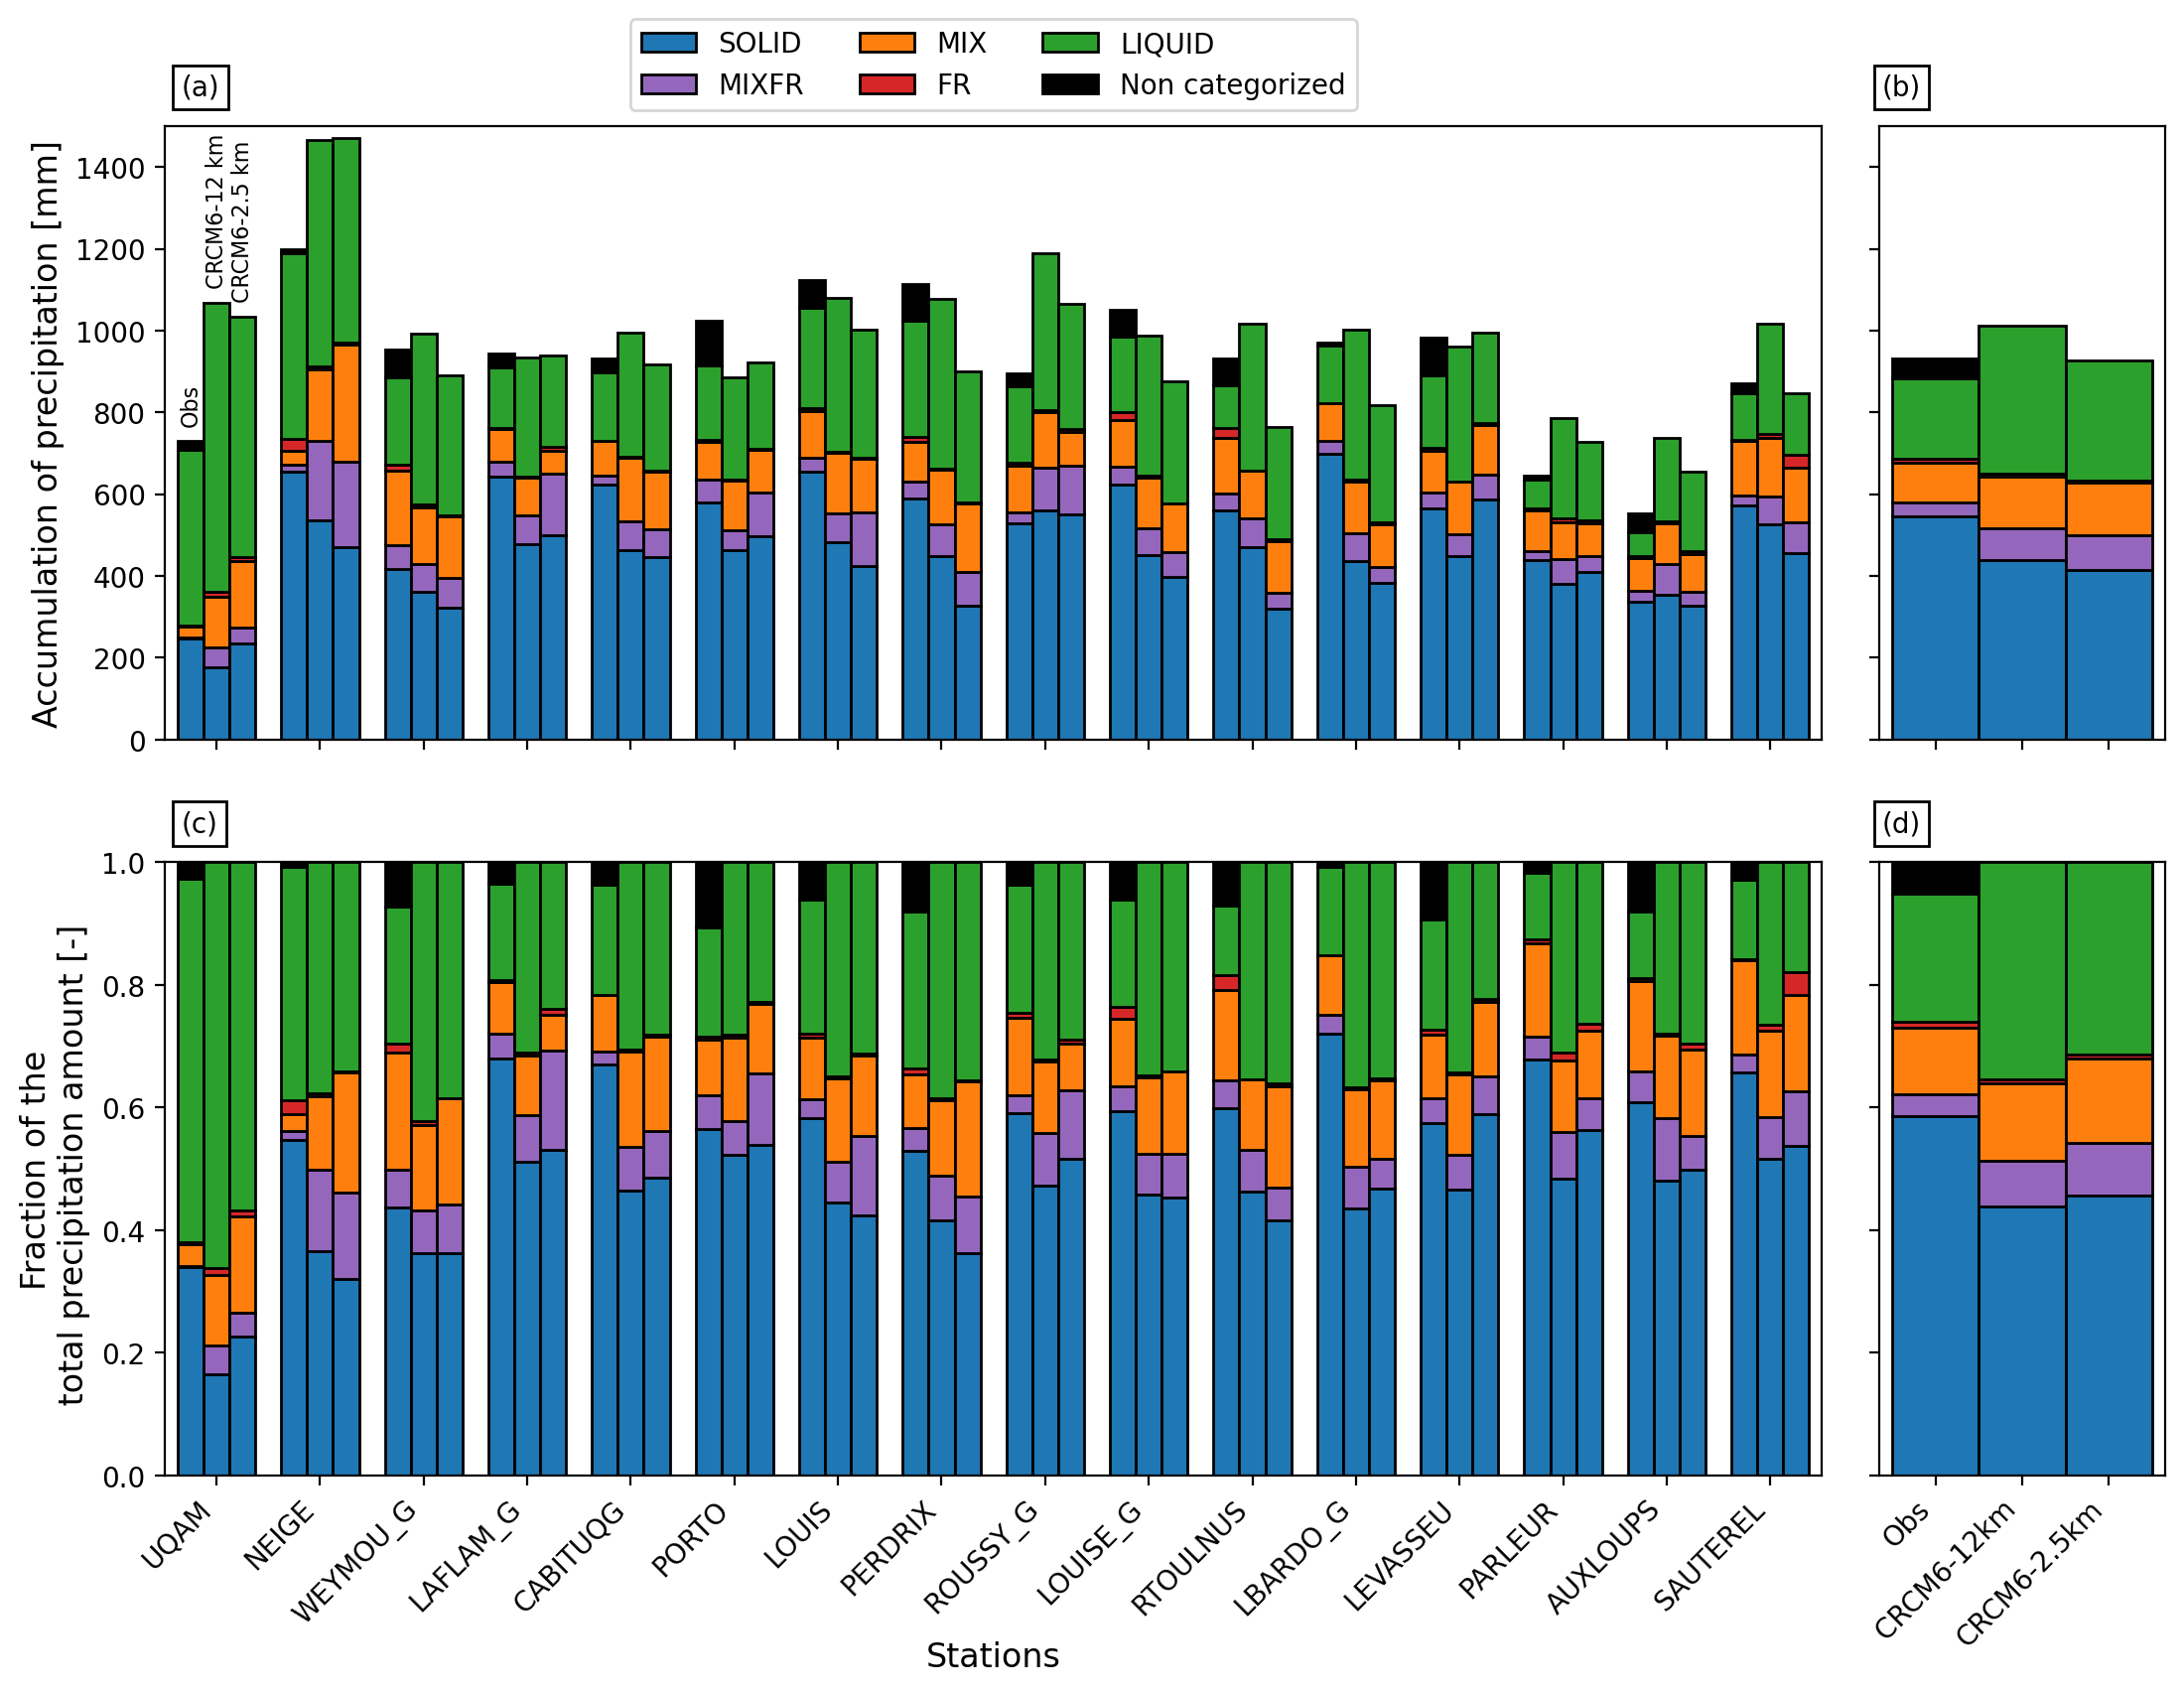

In [15]:
# Annuelle

fig = plt.figure(facecolor='white',dpi=200,figsize=(13,9))
spec = fig.add_gridspec(ncols=6, nrows=2)
ax0 = fig.add_subplot(spec[0, 0:5])
ax0_mean = fig.add_subplot(spec[0, 5])

ax1 = fig.add_subplot(spec[1, 0:5])
ax1_mean = fig.add_subplot(spec[1, 5])

width = 0.25
y_text = 1530
# y_text=1030
x = np.arange(len(list_stat))

# obs
# solid
ax0.bar(x-width,np.array(list_frac)[:,0,0],width=width,color='tab:blue',edgecolor='k')
bottom_obs = np.array(list_frac)[:,0,0]
# mix cold
ax0.bar(x-width,np.array(list_frac)[:,0,3],width=width,bottom=bottom_obs,color='tab:purple',edgecolor='k')
bottom_obs = bottom_obs + np.array(list_frac)[:,0,3]
# mix hot
ax0.bar(x-width,np.array(list_frac)[:,0,4],width=width,bottom=bottom_obs,color='tab:orange',edgecolor='k')
bottom_obs = bottom_obs + np.array(list_frac)[:,0,4]
ax0.bar(x-width,np.array(list_frac)[:,0,2],width=width,bottom=bottom_obs,color='tab:red',edgecolor='k')
bottom_obs = bottom_obs + np.array(list_frac)[:,0,2]
# liq
ax0.bar(x-width,np.array(list_frac)[:,0,1],width=width,bottom=bottom_obs,color='tab:green',edgecolor='k')
bottom_obs = bottom_obs + np.array(list_frac)[:,0,1]
# zeros
ax0.bar(x-width,np.array(list_zeros),width=width,bottom=bottom_obs,color='k',edgecolor='k')
bottom_obs = bottom_obs +np.array(list_zeros)

ax0.text(x[0]-width,bottom_obs[0]+50,'Obs',rotation='vertical',horizontalalignment='center',fontsize=8)



#meanobs

ax0_mean.bar(0-width,np.mean(np.array(list_frac)[:,0,0]),width=width,color='tab:blue',edgecolor='k')
bottom_obs_mean = np.mean(np.array(list_frac)[:,0,0])
# mix cold
ax0_mean.bar(0-width,np.mean(np.array(list_frac)[:,0,3]),width=width,bottom=bottom_obs_mean,color='tab:purple',edgecolor='k')
bottom_obs_mean = bottom_obs_mean + np.mean(np.array(list_frac)[:,0,3])
# mix hot
ax0_mean.bar(0-width,np.mean(np.array(list_frac)[:,0,4]),width=width,bottom=bottom_obs_mean,color='tab:orange',edgecolor='k')
bottom_obs_mean = bottom_obs_mean + np.mean(np.array(list_frac)[:,0,4])
ax0_mean.bar(0-width,np.mean(np.array(list_frac)[:,0,2]),width=width,bottom=bottom_obs_mean,color='tab:red',edgecolor='k')
bottom_obs_mean = bottom_obs_mean + np.mean(np.array(list_frac)[:,0,2])
# liq
ax0_mean.bar(0-width,np.mean(np.array(list_frac)[:,0,1]),width=width,bottom=bottom_obs_mean,color='tab:green',edgecolor='k')
bottom_obs_mean = bottom_obs_mean + np.mean(np.array(list_frac)[:,0,1])
# zeros
ax0_mean.bar(0-width,np.mean(np.array(list_zeros)),width=width,bottom=bottom_obs_mean,color='k',edgecolor='k')
bottom_obs_mean = bottom_obs_mean + np.mean(np.array(list_zeros))

#ax0_mean.text(0-width,bottom_obs_mean+50,'Obs',rotation='vertical',horizontalalignment='center',fontsize=10)


# 11km p3
# solid
ax0.bar(x,np.array(list_frac)[:,4,0],width=width,color='tab:blue',edgecolor='k')
bottom_11kmp3 = np.array(list_frac)[:,4,0]
# mix cold
ax0.bar(x,np.array(list_frac)[:,4,3],width=width, bottom = bottom_11kmp3,color='tab:purple',edgecolor='k')
bottom_11kmp3= bottom_11kmp3 + np.array(list_frac)[:,4,3]
# mix hot
ax0.bar(x,np.array(list_frac)[:,4,4],width=width, bottom = bottom_11kmp3,color='tab:orange',edgecolor='k')
bottom_11kmp3 = bottom_11kmp3 + np.array(list_frac)[:,4,4]
# fz
ax0.bar(x,np.array(list_frac)[:,4,2],width=width,bottom=bottom_11kmp3,color='tab:red',edgecolor='k')
bottom_11kmp3 = bottom_11kmp3 + np.array(list_frac)[:,4,2]
# liq
ax0.bar(x,np.array(list_frac)[:,4,1],width=width,bottom=bottom_11kmp3,color='tab:green',edgecolor='k')
bottom_11kmp3 = bottom_11kmp3 + np.array(list_frac)[:,4,1]
# ax.text(0,1.02,'12 km',rotation='vertical',horizontalalignment='center')
ax0.text(x[0],bottom_11kmp3[0]+50,'CRCM6-12 km',rotation='vertical',horizontalalignment='center',fontsize=8)



# 11km p3 mean
ax0_mean.bar(0,np.mean(np.array(list_frac)[:,4,0]),width=width,color='tab:blue',edgecolor='k')
bottom_11kmp3_mean = np.mean(np.array(list_frac)[:,4,0])
# mix cold
ax0_mean.bar(0,np.mean(np.array(list_frac)[:,4,3]),width=width, bottom = bottom_11kmp3_mean,color='tab:purple',edgecolor='k')
bottom_11kmp3_mean= bottom_11kmp3_mean + np.mean(np.array(list_frac)[:,4,3])
# mix hot
ax0_mean.bar(0,np.mean(np.array(list_frac)[:,4,4]),width=width, bottom = bottom_11kmp3_mean,color='tab:orange',edgecolor='k')
bottom_11kmp3_mean = bottom_11kmp3_mean + np.mean(np.array(list_frac)[:,4,4])
# fz
ax0_mean.bar(0,np.mean(np.array(list_frac)[:,4,2]),width=width,bottom=bottom_11kmp3_mean,color='tab:red',edgecolor='k')
bottom_11kmp3_mean = bottom_11kmp3_mean + np.mean(np.array(list_frac)[:,4,2])
# liq
ax0_mean.bar(0,np.mean(np.array(list_frac)[:,4,1]),width=width,bottom=bottom_11kmp3_mean,color='tab:green',edgecolor='k')
bottom_11kmp3_mean = bottom_11kmp3_mean + np.mean(np.array(list_frac)[:,4,1])

#ax0_mean.text(0,bottom_11kmp3_mean+50,'12 km',rotation='vertical',horizontalalignment='center',fontsize=10)




# 2p5km P3

# solid

ax0.bar(x+width,np.array(list_frac)[:,5,0],width=width,color='tab:blue',edgecolor='k')
bottom_2p5km = np.array(list_frac)[:,5,0]
# mix cold
ax0.bar(x+width,np.array(list_frac)[:,5,3],width=width,bottom=bottom_2p5km,color='tab:purple',edgecolor='k')
bottom_2p5km =bottom_2p5km+ np.array(list_frac)[:,5,3]
# mix hot
ax0.bar(x+width,np.array(list_frac)[:,5,4],width=width,bottom=bottom_2p5km,color='tab:orange',edgecolor='k')
bottom_2p5km =bottom_2p5km+ np.array(list_frac)[:,5,4]
# fz
ax0.bar(x+width,np.array(list_frac)[:,5,2],width=width,bottom=bottom_2p5km,color='tab:red',edgecolor='k')
bottom_2p5km = bottom_2p5km + np.array(list_frac)[:,5,2]
# liq
ax0.bar(x+width,np.array(list_frac)[:,5,1],width=width,bottom=bottom_2p5km,color='tab:green',edgecolor='k')
bottom_2p5km = bottom_2p5km + np.array(list_frac)[:,5,1]
# ax.text(0+width,1.02,'2.5 km',rotation='vertical',horizontalalignment='center')
ax0.text(x[0]+width,bottom_2p5km[0]+50 ,'CRCM6-2.5 km',rotation='vertical',horizontalalignment='center',fontsize=8)
bbox = dict(boxstyle="square", fc="w")
ax0.annotate(f'(a)', xy=(0.01, 1.05), bbox=bbox, xycoords='axes fraction', fontsize=10)

ax0.set_ylim(0,1500)
# ax.set_ylim(0,1000)
ax0.set_xlim(x[0]-width*2,x[-1]+width*2)
time_text = f'{begin_date_1.strftime("%Y-%m")} to {end_date_1.strftime("%Y-%m")} &\n {begin_date_2.strftime("%Y-%m")} to {end_date_2.strftime("%Y-%m")}'

# for i in [2,3,4,-3,-2,-1]:
#
#     print('\n\n Quantity ')
#     print(list_stat[i])
    # print(f'diff LIQUID 12 km: {np.array(list_frac_norm)[i,0,1]-np.array(list_frac_norm)[i,4,1]:.2f}')
    # print(f'diff LIQUID 2.5 km: {np.array(list_frac_norm)[i,0,1]-np.array(list_frac_norm)[i,5,1]:.2f}\n')
    #
    # print(f'diff SOLID 12 km: {np.array(list_frac_norm)[i,0,0]-np.array(list_frac_norm)[i,4,0]:.2f}')
    # print(f'diff SOLID 2.5 km: {np.array(list_frac_norm)[i,0,0]-np.array(list_frac_norm)[i,5,0]:.2f}\n')

    # print(f'diff FZ 12 km: {np.array(list_frac)[i,0,2]-np.array(list_frac)[i,4,2]:.2f}')
    # print(f'diff FZ 2.5 km: {np.array(list_frac)[i,0,2]-np.array(list_frac)[i,5,2]:.2f}\n')
    #
    # print(f'diff MIX 12 km: {np.array(list_frac)[i,0,4]-np.array(list_frac)[i,4,4]:.2f}')
    # print(f'diff MIX 2.5 km: {np.array(list_frac)[i,0,4]-np.array(list_frac)[i,5,4]:.2f}\n')
    #
    # print(f'diff MIXFR 12 km: {np.array(list_frac)[i,0,3]-np.array(list_frac)[i,4,3]:.2f}')
    # print(f'diff MIXFR 2.5 km: {np.array(list_frac)[i,0,3]-np.array(list_frac)[i,5,3]:.2f}\n')


# print(f'diff FZ 12 km: {np.mean(np.array(list_frac)[2:4,0,2]-np.array(list_frac)[2:4,4,2]):.2f}')
# print(f'diff FZ 2.5 km: {np.mean(np.array(list_frac)[2:4,0,2]-np.array(list_frac)[2:4,5,2]):.2f}\n')
#
# print(f'diff MIX 12 km: {np.mean(np.array(list_frac)[2:4,0,4]-np.array(list_frac)[2:4,4,4]):.2f}')
# print(f'diff MIX 2.5 km: {np.mean(np.array(list_frac)[2:4,0,4]-np.array(list_frac)[2:4,5,4]):.2f}\n')
#
# print(f'diff MIXFR 12 km: {np.mean(np.array(list_frac)[2:4,0,3]-np.array(list_frac)[2:4,4,3]):.2f}')
# print(f'diff MIXFR 2.5 km: {np.mean(np.array(list_frac)[2:4,0,3]-np.array(list_frac)[2:4,5,3]):.2f}\n')
#
#
#
# print(f'diff FZ 12 km: {np.mean(np.array(list_frac)[-3:-1,0,2]-np.array(list_frac)[-3:-1,4,2]):.2f}')
# print(f'diff FZ 2.5 km: {np.mean(np.array(list_frac)[-3:-1,0,2]-np.array(list_frac)[-3:-1,5,2]):.2f}\n')
#
# print(f'diff MIX 12 km: {np.mean(np.array(list_frac)[-3:-1,0,4]-np.array(list_frac)[-3:-1,4,4]):.2f}')
# print(f'diff MIX 2.5 km: {np.mean(np.array(list_frac)[-3:-1,0,4]-np.array(list_frac)[-3:-1,5,4]):.2f}\n')
#
# print(f'diff MIXFR 12 km: {np.mean(np.array(list_frac)[-3:-1,0,3]-np.array(list_frac)[-3:-1,4,3]):.2f}')
# print(f'diff MIXFR 2.5 km: {np.mean(np.array(list_frac)[-3:-1,0,3]-np.array(list_frac)[-3:-1,5,3]):.2f}\n')



print('\n\n Quantity ')
print(f'diff LIQUID 12 km: {np.mean(np.array(list_frac)[:,0,1]-np.array(list_frac)[:,4,1]):.2f}')
print(f'diff LIQUID 2.5 km: {np.mean(np.array(list_frac)[:,0,1]-np.array(list_frac)[:,5,1]):.2f}\n')

print(f'diff SOLID 12 km: {np.mean(np.array(list_frac)[:,0,0]-np.array(list_frac)[:,4,0]):.2f}')
print(f'diff SOLID 2.5 km: {np.mean(np.array(list_frac)[:,0,0]-np.array(list_frac)[:,5,0]):.2f}\n')

print(f'diff FZ 12 km: {np.mean(np.array(list_frac)[:,0,2]-np.array(list_frac)[:,4,2]):.2f}')
print(f'diff FZ 2.5 km: {np.mean(np.array(list_frac)[:,0,2]-np.array(list_frac)[:,5,2]):.2f}\n')

print(f'diff MIX 12 km: {np.mean(np.array(list_frac)[:,0,4]-np.array(list_frac)[:,4,4]):.2f}')
print(f'diff MIX 2.5 km: {np.mean(np.array(list_frac)[:,0,4]-np.array(list_frac)[:,5,4]):.2f}\n')

print(f'diff MIXFR 12 km: {np.mean(np.array(list_frac)[:,0,3]-np.array(list_frac)[:,4,3]):.2f}')
print(f'diff MIXFR 2.5 km: {np.mean(np.array(list_frac)[:,0,3]-np.array(list_frac)[:,5,3]):.2f}\n')




# print(f'diff FZ 12 km: {np.sum(np.array(list_frac)[:,0,2]-np.array(list_frac)[:,4,2]):.2f}')
# print(f'diff FZ 2.5 km: {np.sum(np.array(list_frac)[:,0,2]-np.array(list_frac)[:,5,2]):.2f}')
# ax0.set_xticks(x)
# ax0.set_xticklabels(list_stat,rotation=45,ha='right')
ax0.set_ylabel('Accumulation of precipitation [mm]',fontsize=12)
# ax.set_ylabel('Fraction of the\n total precipitation amount [-]',fontsize=12)
# ax0.set_xlabel('Stations',fontsize=12)
ax0.tick_params(which="both",bottom=True,labelbottom=False)
ax0_mean.tick_params(which="both",bottom=True,labelbottom=False,left=True,labelleft=False)
ax0.legend(['SOLID','MIXFR','MIX','FR','LIQUID','Non categorized'],loc='center', bbox_to_anchor=(0.5, 1.10),ncol=3)
# image_savepath = fr"/upslope/chalifour/projet_maitrise/fig/carte_stat_pie/closest_pt/stat_bar_chart_qty_2years"

# 2p5km p3 mean
ax0_mean.bar(0+width,np.mean(np.array(list_frac)[:,5,0]),width=width,color='tab:blue',edgecolor='k')
bottom_2p5kmp3_mean = np.mean(np.array(list_frac)[:,5,0])
# mix cold
ax0_mean.bar(0+width,np.mean(np.array(list_frac)[:,5,3]),width=width, bottom = bottom_2p5kmp3_mean,color='tab:purple',edgecolor='k')
bottom_2p5kmp3_mean= bottom_2p5kmp3_mean + np.mean(np.array(list_frac)[:,5,3])
# mix hot
ax0_mean.bar(0+width,np.mean(np.array(list_frac)[:,5,4]),width=width, bottom = bottom_2p5kmp3_mean,color='tab:orange',edgecolor='k')
bottom_2p5kmp3_mean = bottom_2p5kmp3_mean + np.mean(np.array(list_frac)[:,5,4])
# fz
ax0_mean.bar(0+width,np.mean(np.array(list_frac)[:,5,2]),width=width,bottom=bottom_2p5kmp3_mean,color='tab:red',edgecolor='k')
bottom_2p5kmp3_mean = bottom_2p5kmp3_mean + np.mean(np.array(list_frac)[:,5,2])
# liq
ax0_mean.bar(0+width,np.mean(np.array(list_frac)[:,5,1]),width=width,bottom=bottom_2p5kmp3_mean,color='tab:green',edgecolor='k')
bottom_2p5kmp3_mean = bottom_2p5kmp3_mean + np.mean(np.array(list_frac)[:,5,1])

#ax0_mean.text(0+width,bottom_2p5kmp3_mean+50 ,'2.5 km',rotation='vertical',horizontalalignment='center',fontsize=10)

ax0_mean.annotate(f'(b)', xy=(0.01, 1.05), bbox=bbox, xycoords='axes fraction', fontsize=10)


# obs
# solid

ax1.bar(x - width, np.array(list_frac_norm)[:, 0, 0], width=width, color='tab:blue', edgecolor='k')
bottom_obs = np.array(list_frac_norm)[:, 0, 0]
# mix cold
ax1.bar(x - width, np.array(list_frac_norm)[:, 0, 3], width=width, bottom=bottom_obs, color='tab:purple', edgecolor='k')
bottom_obs = bottom_obs + np.array(list_frac_norm)[:, 0, 3]
# mix hot
ax1.bar(x - width, np.array(list_frac_norm)[:, 0, 4], width=width, bottom=bottom_obs, color='tab:orange', edgecolor='k')
bottom_obs = bottom_obs + np.array(list_frac_norm)[:, 0, 4]
ax1.bar(x - width, np.array(list_frac_norm)[:, 0, 2], width=width, bottom=bottom_obs, color='tab:red', edgecolor='k')
bottom_obs = bottom_obs + np.array(list_frac_norm)[:, 0, 2]
# liq
ax1.bar(x - width, np.array(list_frac_norm)[:, 0, 1], width=width, bottom=bottom_obs, color='tab:green', edgecolor='k')
bottom_obs = bottom_obs + np.array(list_frac_norm)[:, 0, 1]
# zeros
ax1.bar(x - width, np.array(list_zeros_norm), width=width, bottom=bottom_obs, color='k', edgecolor='k')
bottom_obs = bottom_obs + np.array(list_zeros_norm)



# obsmean
# solid

ax1_mean.bar(0 - width, np.mean(np.array(list_frac_norm)[:, 0, 0]), width=width, color='tab:blue', edgecolor='k')
bottom_obs_mean = np.mean(np.array(list_frac_norm)[:, 0, 0])
# mix cold
ax1_mean.bar(0 - width, np.mean(np.array(list_frac_norm)[:, 0, 3]), width=width, bottom=bottom_obs_mean, color='tab:purple', edgecolor='k')
bottom_obs_mean = bottom_obs_mean + np.mean(np.array(list_frac_norm)[:, 0, 3])
# mix hot
ax1_mean.bar(0 - width, np.mean(np.array(list_frac_norm)[:, 0, 4]), width=width, bottom=bottom_obs_mean, color='tab:orange', edgecolor='k')
bottom_obs_mean = bottom_obs_mean + np.mean(np.array(list_frac_norm)[:, 0, 4])
ax1_mean.bar(0 - width, np.mean(np.array(list_frac_norm)[:, 0, 2]), width=width, bottom=bottom_obs_mean, color='tab:red', edgecolor='k')
bottom_obs_mean = bottom_obs_mean + np.mean(np.array(list_frac_norm)[:, 0, 2])
# liq
ax1_mean.bar(0 - width, np.mean(np.array(list_frac_norm)[:, 0, 1]), width=width, bottom=bottom_obs_mean, color='tab:green', edgecolor='k')
bottom_obs_mean = bottom_obs_mean + np.mean(np.array(list_frac_norm)[:, 0, 1])
# zeros
ax1_mean.bar(0 - width, np.mean(np.array(list_zeros_norm)), width=width, bottom=bottom_obs_mean, color='k', edgecolor='k')
bottom_obs_mean = bottom_obs_mean + np.mean(np.array(list_zeros_norm))
# nan
# ax.bar(x-width,np.array(list_fnan),width=width,bottom=bottom_obs,color='k',edgecolor='grey')


# ax.text(0-width,1.02,'obs',rotation='vertical',horizontalalignment='center')
# ax1.text(x[0] - width, y_text, 'Obs', rotation='vertical', horizontalalignment='center', fontsize=12)


# 11km p3
# solid
ax1.bar(x, np.array(list_frac_norm)[:, 4, 0], width=width, color='tab:blue', edgecolor='k')
bottom_11kmp3 = np.array(list_frac_norm)[:, 4, 0]
# mix cold
ax1.bar(x, np.array(list_frac_norm)[:, 4, 3], width=width, bottom=bottom_11kmp3, color='tab:purple', edgecolor='k')
bottom_11kmp3 = bottom_11kmp3 + np.array(list_frac_norm)[:, 4, 3]
# mix hot
ax1.bar(x, np.array(list_frac_norm)[:, 4, 4], width=width, bottom=bottom_11kmp3, color='tab:orange', edgecolor='k')
bottom_11kmp3 = bottom_11kmp3 + np.array(list_frac_norm)[:, 4, 4]
# fz
ax1.bar(x, np.array(list_frac_norm)[:, 4, 2], width=width, bottom=bottom_11kmp3, color='tab:red', edgecolor='k')
bottom_11kmp3 = bottom_11kmp3 + np.array(list_frac_norm)[:, 4, 2]
# liq
ax1.bar(x, np.array(list_frac_norm)[:, 4, 1], width=width, bottom=bottom_11kmp3, color='tab:green', edgecolor='k')

# ax.text(0,1.02,'12 km',rotation='vertical',horizontalalignment='center')
# ax1.text(x[0], y_text, '12 km', rotation='vertical', horizontalalignment='center', fontsize=12)

# 11km p3 mean
# solid
ax1_mean.bar(0, np.mean(np.array(list_frac_norm)[:, 4, 0]), width=width, color='tab:blue', edgecolor='k')
bottom_11kmp3_mean = np.mean(np.array(list_frac_norm)[:, 4, 0])
# mix cold
ax1_mean.bar(0, np.mean(np.array(list_frac_norm)[:, 4, 3]), width=width, bottom=bottom_11kmp3_mean, color='tab:purple', edgecolor='k')
bottom_11kmp3_mean = bottom_11kmp3_mean + np.mean(np.array(list_frac_norm)[:, 4, 3])
# mix hot
ax1_mean.bar(0, np.mean(np.array(list_frac_norm)[:, 4, 4]), width=width, bottom=bottom_11kmp3_mean, color='tab:orange', edgecolor='k')
bottom_11kmp3_mean = bottom_11kmp3_mean + np.mean(np.array(list_frac_norm)[:, 4, 4])
# fz
ax1_mean.bar(0, np.mean(np.array(list_frac_norm)[:, 4, 2]), width=width, bottom=bottom_11kmp3_mean, color='tab:red', edgecolor='k')
bottom_11kmp3_mean = bottom_11kmp3_mean + np.mean(np.array(list_frac_norm)[:, 4, 2])
# liq
ax1_mean.bar(0, np.mean(np.array(list_frac_norm)[:, 4, 1]), width=width, bottom=bottom_11kmp3_mean, color='tab:green', edgecolor='k')
# ax.text(0,1.02,'12 km',rotation='vertical',horizontalalignment='center')
# ax1.text(x[0], y_text, '12 km', rotation='vertical', horizontalalignment='center', fontsize=12)

# 2p5km P3

# solid
ax1.bar(x + width, np.array(list_frac_norm)[:, 5, 0], width=width, color='tab:blue', edgecolor='k')
bottom_2p5km = np.array(list_frac_norm)[:, 5, 0]
# mix cold
ax1.bar(x + width, np.array(list_frac_norm)[:, 5, 3], width=width, bottom=bottom_2p5km, color='tab:purple', edgecolor='k')
bottom_2p5km = bottom_2p5km + np.array(list_frac_norm)[:, 5, 3]
# mix hot
ax1.bar(x + width, np.array(list_frac_norm)[:, 5, 4], width=width, bottom=bottom_2p5km, color='tab:orange', edgecolor='k')
bottom_2p5km = bottom_2p5km + np.array(list_frac_norm)[:, 5, 4]
# fz
ax1.bar(x + width, np.array(list_frac_norm)[:, 5, 2], width=width, bottom=bottom_2p5km, color='tab:red', edgecolor='k')
bottom_2p5km = bottom_2p5km + np.array(list_frac_norm)[:, 5, 2]
# liq
ax1.bar(x + width, np.array(list_frac_norm)[:, 5, 1], width=width, bottom=bottom_2p5km, color='tab:green', edgecolor='k')



# 2p5km P3 mean

# solid
ax1_mean.bar(0 + width, np.mean(np.array(list_frac_norm)[:, 5, 0]), width=width, color='tab:blue', edgecolor='k')
bottom_2p5km_mean = np.mean(np.array(list_frac_norm)[:, 5, 0])
# mix cold
ax1_mean.bar(0 + width, np.mean(np.array(list_frac_norm)[:, 5, 3]), width=width, bottom=bottom_2p5km_mean, color='tab:purple', edgecolor='k')
bottom_2p5km_mean = bottom_2p5km_mean + np.mean(np.array(list_frac_norm)[:, 5, 3])
# mix hot
ax1_mean.bar(0 + width, np.mean(np.array(list_frac_norm)[:, 5, 4]), width=width, bottom=bottom_2p5km_mean, color='tab:orange', edgecolor='k')
bottom_2p5km_mean = bottom_2p5km_mean + np.mean(np.array(list_frac_norm)[:, 5, 4])
# fz
ax1_mean.bar(0 + width, np.mean(np.array(list_frac_norm)[:, 5, 2]), width=width, bottom=bottom_2p5km_mean, color='tab:red', edgecolor='k')
bottom_2p5km_mean = bottom_2p5km_mean+ np.mean(np.array(list_frac_norm)[:, 5, 2])
# liq
ax1_mean.bar(0 + width, np.mean(np.array(list_frac_norm)[:, 5, 1]), width=width, bottom=bottom_2p5km_mean, color='tab:green', edgecolor='k')


# ax.text(0+width,1.02,'2.5 km',rotation='vertical',horizontalalignment='center')
# ax1.text(x[0] + width, y_text, '2.5 km', rotation='vertical', horizontalalignment='center', fontsize=12)
ax1.annotate(f'(c)', xy=(0.01, 1.05), bbox=bbox, xycoords='axes fraction', fontsize=10)
ax1_mean.annotate(f'(d)', xy=(0.01, 1.05), bbox=bbox, xycoords='axes fraction', fontsize=10)
# ax2.scatter(x,list_mean_speed,marker='s',s=20,facecolors='r',edgecolors='k')
#
# ax2.set_ylabel('Mean wind speed\nat gauge height [m/s]',fontsize=12)
for i in [2,3,4,-3,-2,-1]:

    print('\n\n Fraction ')
    print(list_stat[i])
    # print(f'diff LIQUID 12 km: {np.array(list_frac_norm)[i,0,1]-np.array(list_frac_norm)[i,4,1]:.2f}')
    # print(f'diff LIQUID 2.5 km: {np.array(list_frac_norm)[i,0,1]-np.array(list_frac_norm)[i,5,1]:.2f}\n')
    #
    # print(f'diff SOLID 12 Rkm: {np.array(list_frac_norm)[i,0,0]-np.array(list_frac_norm)[i,4,0]:.2f}')
    # print(f'diff SOLID 2.5 km: {np.array(list_frac_norm)[i,0,0]-np.array(list_frac_norm)[i,5,0]:.2f}\n')

    print(f'diff FZ 12 km: {np.array(list_frac_norm)[i,0,2]-np.array(list_frac_norm)[i,4,2]:.2f}')
    print(f'diff FZ 2.5 km: {np.array(list_frac_norm)[i,0,2]-np.array(list_frac_norm)[i,5,2]:.2f}\n')

    print(f'diff MIX 12 km: {np.array(list_frac_norm)[i,0,4]-np.array(list_frac_norm)[i,4,4]:.2f}')
    print(f'diff MIX 2.5 km: {np.array(list_frac_norm)[i,0,4]-np.array(list_frac_norm)[i,5,4]:.2f}\n')

    print(f'diff MIXFR 12 km: {np.array(list_frac_norm)[i,0,3]-np.array(list_frac_norm)[i,4,3]:.2f}')
    print(f'diff MIXFR 2.5 km: {np.array(list_frac_norm)[i,0,3]-np.array(list_frac_norm)[i,5,3]:.2f}\n')

ax1.set_ylim(0, 1)
ax1.set_xlim(x[0] - width * 2, x[-1] + width * 2)
time_text = f'{begin_date_1.strftime("%Y-%m")} to {end_date_1.strftime("%Y-%m")} &\n {begin_date_2.strftime("%Y-%m")} to {end_date_2.strftime("%Y-%m")}'

# ax.annotate(f'{time_text}', xy=(0.78, 1.01), xycoords='axes fraction', fontsize=14)

ax1.set_xticks(x)
ax1.set_xticklabels(list_stat, rotation=45, ha='right')

ax1_mean.set_xticks([0 - width,0,0 + width])
ax1_mean.set_xticklabels(['Obs',' CRCM6-12km','CRCM6-2.5km'], rotation=45, ha='right')
ax1_mean.tick_params(which="both",bottom=True,left=True,labelleft=False)
# ax.set_ylabel('Precipitation type fraction',fontsize=12)
ax1.set_ylabel('Fraction of the\n total precipitation amount [-]', fontsize=12)
ax1.set_xlabel('Stations', fontsize=12)

ax0.sharex(ax1)
ax0_mean.sharex(ax1_mean)
ax0_mean.sharey(ax0)
ax1_mean.sharey(ax1)
image_savepath = fr"/upslope/chalifour/projet_maitrise/fig/carte_stat_pie/stat_bar_chart_qty_{subdf.index[0].strftime('%Y')}_{subdf.index[-1].strftime('%Y')}"
# fig.savefig(image_savepath+".png", dpi=200, format='png', bbox_inches='tight')
# fig.savefig(image_savepath+".eps", dpi=200, format='eps', bbox_inches='tight')
plt.show()



12 km 128.14062832704968
2.5km 42.375935009025156


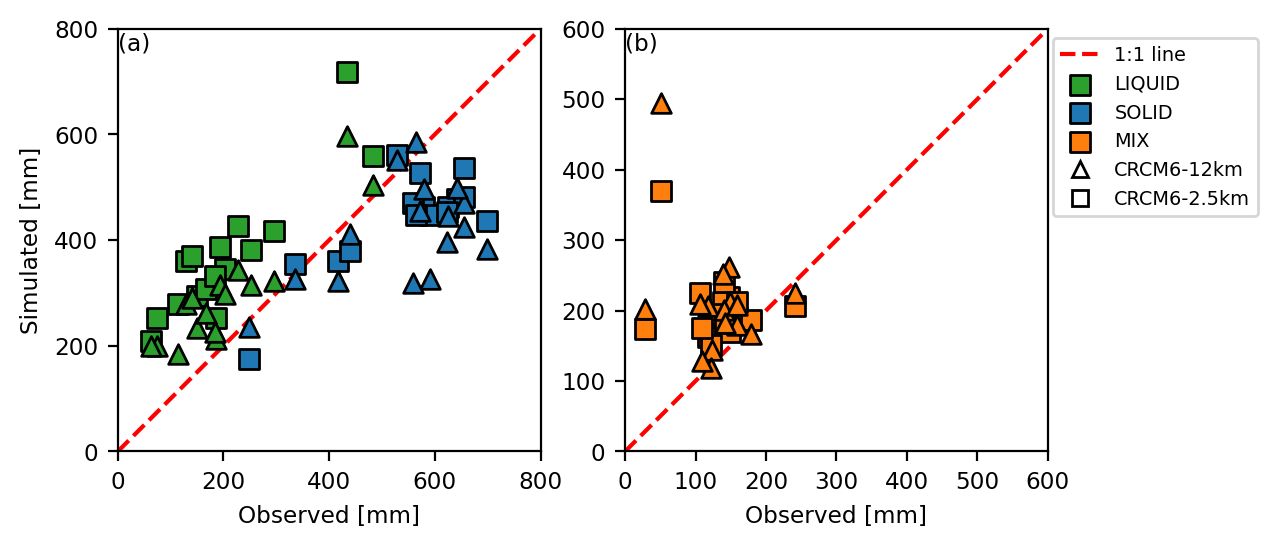

In [23]:
# array_pcolor[array_pcolor == np.inf] = 0
fig = plt.figure(facecolor='white',dpi=200,)
spec = fig.add_gridspec(ncols=2, nrows=1)
ax0 = fig.add_subplot(spec[0, 0],aspect='equal')
ax1 = fig.add_subplot(spec[0, 1],aspect='equal')
def bias_sim_tot(array_sim,array_ref):
    biais = np.nanmean(array_sim-array_ref)
    return biais

pr_obs = np.array(list_frac)[:,0,1]+np.array(list_frac)[:,0,2]+np.array(list_frac)[:,0,0]+np.array(list_frac)[:,0,3]+np.array(list_frac)[:,0,4]
pr_12km = np.array(list_frac)[:,4,1]+np.array(list_frac)[:,4,2]+np.array(list_frac)[:,4,0]+np.array(list_frac)[:,4,3]+np.array(list_frac)[:,4,4]
pr_2p5km = np.array(list_frac)[:,5,1]+np.array(list_frac)[:,5,2]+np.array(list_frac)[:,5,0]+np.array(list_frac)[:,5,3]+np.array(list_frac)[:,5,4]

print('12 km',bias_sim_tot(np.array(pr_12km),np.array(pr_obs)))
print('2.5km',bias_sim_tot(np.array(pr_2p5km),np.array(pr_obs)))

si=50
#liquide 12 km
lliq = ax0.scatter(np.array(list_frac)[:,0,1]+np.array(list_frac)[:,0,2],np.array(list_frac)[:,4,1]+np.array(list_frac)[:,4,2],c = 'tab:green',ec='k',s=si,label='LIQUID',marker='s')
#liquide 2.5 km
ax0.scatter(np.array(list_frac)[:,0,1]+np.array(list_frac)[:,0,2],np.array(list_frac)[:,5,1]+np.array(list_frac)[:,5,2],c = 'tab:green',ec='k',s=si,marker='^')

#Solid 12 km
lsol =ax0.scatter(np.array(list_frac)[:,0,0],np.array(list_frac)[:,4,0],c = 'tab:blue',ec='k',s=si,label='SOLID',marker='s')
#Solid 2.5 km
ax0.scatter(np.array(list_frac)[:,0,0],np.array(list_frac)[:,5,0],c = 'tab:blue',ec='k',s=si,marker='^')



#FR 12 km
# lfr = ax1.scatter(np.array(list_frac)[:,0,2],np.array(list_frac)[:,4,2],c = 'tab:red',ec='k',s=si,label='FR',marker='s')
#FR 2.5 km
# ax1.scatter(np.array(list_frac)[:,0,2],np.array(list_frac)[:,5,2],c = 'tab:red',ec='k',s=si,marker='^')

#mixFR 12 km
lmixfr = ax1.scatter(np.array(list_frac)[:,0,3]+np.array(list_frac)[:,0,4],np.array(list_frac)[:,4,3]+np.array(list_frac)[:,4,4],c = 'tab:orange',ec='k',s=si,label='MIX',marker='s')
#mixFR 2.5 km
ax1.scatter(np.array(list_frac)[:,0,3]+np.array(list_frac)[:,0,4],np.array(list_frac)[:,5,3]+np.array(list_frac)[:,5,4],c = 'tab:orange',ec='k',s=si,marker='^')

#mix 12 km
# lmix = ax1.scatter(np.array(list_frac)[:,0,4],np.array(list_frac)[:,4,4],c = 'tab:orange',ec='k',s=si,label='MIX',marker='s')
# #mix 2.5 km
# ax1.scatter(np.array(list_frac)[:,0,4],np.array(list_frac)[:,5,4],c = 'tab:orange',ec='k',s=si,marker='^')



max_sol = 800
ax0.set_xlim(0,max_sol)
ax0.set_ylim(0,max_sol)
# ax1.set_xlim(0,max_sol)
# ax1.set_ylim(0,max_sol)
ax0.set_xticks(np.arange(0,max_sol+200,200))
ax0.set_yticks(np.arange(0,max_sol+200,200))
ran = np.linspace(0,max_sol,1000)
l1p1 = ax0.plot(ran,ran,'r--',label='1:1 line',zorder=-99999)
# ax0.plot(ran,ran,'r--',zorder=-99999)


max_mix = 600
ax1.set_xlim(0,max_mix)
ax1.set_ylim(0,max_mix)
# ax.set_xlim(0,max_mix)
# ax3.set_ylim(0,max_mix)

ax1.set_xticks(np.arange(0,max_mix+100,100))
ax1.set_yticks(np.arange(0,max_mix+100,100))

ran = np.linspace(0,max_mix,1000)
ax1.plot(ran,ran,'r--',zorder=-99999)
# ax3.plot(ran,ran,'r--',zorder=-99999)


# ax0.legend(fontsize='small')
# ax2.legend(fontsize='small')

bbox = dict(boxstyle="square", fc="w",alpha=0)
ax0.annotate(f'(a)', xy=(0.0, 0.95), bbox=bbox, xycoords='axes fraction', fontsize='small')
ax1.annotate(f'(b)', xy=(0.0, 0.95), bbox=bbox, xycoords='axes fraction', fontsize='small')
# ax2.annotate(f'(c)', xy=(0.0, 1.025), bbox=bbox, xycoords='axes fraction', fontsize='small')
# ax3.annotate(f'(d)', xy=(0.0, 1.025), bbox=bbox, xycoords='axes fraction', fontsize='small')

ax0.grid(False)
ax1.grid(False)
# ax2.grid(False)
# ax3.grid(False)

ax0.tick_params(which="both",bottom=True,left=True)
ax1.tick_params(which="both",bottom=True,left=True)
# ax2.tick_params(which="both",bottom=True,left=True)
# ax3.tick_params(which="both",bottom=True,left=True,labelleft=False)

ax0.set_xlabel('Observed [mm]',fontsize='small')
ax0.set_ylabel('Simulated [mm]',fontsize='small')
ax1.set_xlabel('Observed [mm]',fontsize='small')
# ax1.set_ylabel('Simulated [mm]',fontsize='small')
# ax2.set_ylabel('Observed [mm]',fontsize='small')
# ax2.set_xlabel('Simulated [mm]',fontsize='small')
# ax3.set_ylabel('Observed [mm]')
# ax3.set_xlabel('Simulated [mm]',fontsize='small')

for ax in [ax0,ax1]:
    ax.xaxis.set_tick_params(labelsize='small')
    ax.yaxis.set_tick_params(labelsize='small')

handles0, labels0 = ax0.get_legend_handles_labels()
handles1, labels1 = ax1.get_legend_handles_labels()
for i in range(0,len(handles1)):
    handles0.append(handles1[i])
    labels0.append(labels1[i])

import matplotlib.lines as mlines


handles0.append(mlines.Line2D([], [], color='w',markeredgecolor='k', marker='^',linestyle=None))
handles0.append(mlines.Line2D([], [], color='w',markeredgecolor='k', marker='s',linestyle=None))
labels0.append('CRCM6-12km')
labels0.append('CRCM6-2.5km')
# plt.legend(list_mak,list_lab)
ax1.legend(handles0, labels0, loc='upper right',fontsize='x-small', bbox_to_anchor=(1.52, 1))

# fig.legend([l1p1,lliq,lsol,lfr,lmixfr,lmix],fontsize='small',loc="upper right")
image_savepath = fr"/upslope/chalifour/projet_maitrise/fig_v2/fig_scatterprcp_stat_2"
fig.savefig(image_savepath+".png", format='png', bbox_inches='tight')
# fig.savefig(image_savepath+".eps", dpi=200, format='eps', bbox_inches='tight')
plt.show()

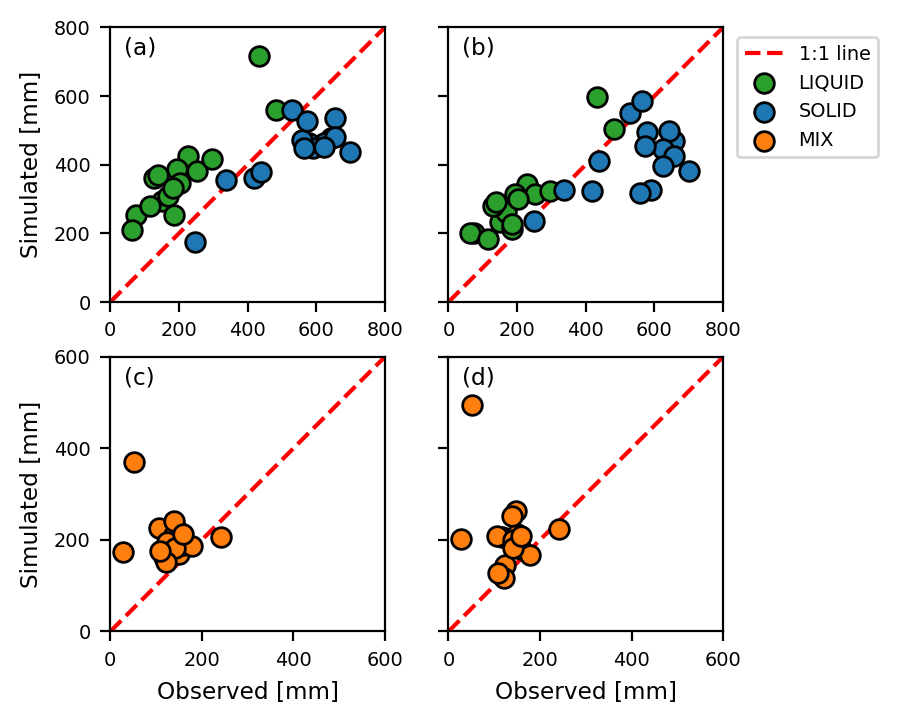

In [17]:


# array_pcolor[array_pcolor == np.inf] = 0
fig = plt.figure(facecolor='white',dpi=200,figsize=(4,4))
spec = fig.add_gridspec(ncols=2, nrows=2)
ax0 = fig.add_subplot(spec[0, 0],aspect='equal')
ax1 = fig.add_subplot(spec[0, 1],aspect='equal')
ax2 = fig.add_subplot(spec[1, 0],aspect='equal')
ax3 = fig.add_subplot(spec[1, 1],aspect='equal')

si=50
#liquide 12 km
lliq = ax0.scatter(np.array(list_frac)[:,0,1]+np.array(list_frac)[:,0,2],np.array(list_frac)[:,4,1]+np.array(list_frac)[:,4,2],c = 'tab:green',ec='k',s=si,label='LIQUID')
#liquide 2.5 km
ax1.scatter(np.array(list_frac)[:,0,1]+np.array(list_frac)[:,0,2],np.array(list_frac)[:,5,1]+np.array(list_frac)[:,5,2],c = 'tab:green',ec='k',s=si)

#Solid 12 km
lsol =ax0.scatter(np.array(list_frac)[:,0,0],np.array(list_frac)[:,4,0],c = 'tab:blue',ec='k',s=si,label='SOLID')
#Solid 2.5 km
ax1.scatter(np.array(list_frac)[:,0,0],np.array(list_frac)[:,5,0],c = 'tab:blue',ec='k',s=si)


#FR 12 km
# lfr = ax2.scatter(np.array(list_frac)[:,0,2],np.array(list_frac)[:,4,2],c = 'tab:red',ec='k',s=si,label='FR')
#FR 2.5 km
# ax3.scatter(np.array(list_frac)[:,0,2],np.array(list_frac)[:,5,2],c = 'tab:red',ec='k',s=si)

#mixFR 12 km
lmix = ax2.scatter(np.array(list_frac)[:,0,3]+np.array(list_frac)[:,0,4],np.array(list_frac)[:,4,3]+np.array(list_frac)[:,4,4],c = 'tab:orange',ec='k',s=si,label='MIX')
#mixFR 2.5 km
ax3.scatter(np.array(list_frac)[:,0,3]+np.array(list_frac)[:,0,4],np.array(list_frac)[:,5,3]+np.array(list_frac)[:,5,4],c = 'tab:orange',ec='k',s=si)

#mix 12 km
# lmix = ax2.scatter(np.array(list_frac)[:,0,4],np.array(list_frac)[:,4,4],c = 'tab:orange',ec='k',s=si,label='MIX')
#mix 2.5 km
# ax3.scatter(np.array(list_frac)[:,0,4],np.array(list_frac)[:,5,4],c = 'tab:orange',ec='k',s=si)



max_sol = 800
ax0.set_xlim(0,max_sol)
ax0.set_ylim(0,max_sol)
ax1.set_xlim(0,max_sol)
ax1.set_ylim(0,max_sol)

ax0.set_xticks(np.arange(0,max_sol+200,200))
ax1.set_xticks(np.arange(0,max_sol+200,200))
ax0.set_yticks(np.arange(0,max_sol+200,200))
ax1.set_yticks(np.arange(0,max_sol+200,200))
ran = np.linspace(0,max_sol,1000)
l1p1 = ax0.plot(ran,ran,'r--',label='1:1 line',zorder=-99999)
ax1.plot(ran,ran,'r--',zorder=-99999)


max_mix = 600
ax2.set_xlim(0,max_mix)
ax2.set_ylim(0,max_mix)
ax3.set_xlim(0,max_mix)
ax3.set_ylim(0,max_mix)

ax2.set_xticks(np.arange(0,max_mix+100,200))
ax3.set_xticks(np.arange(0,max_mix+100,200))
ax2.set_yticks(np.arange(0,max_mix+100,200))
ax3.set_yticks(np.arange(0,max_mix+100,200))

ran = np.linspace(0,max_mix,1000)
ax2.plot(ran,ran,'r--',zorder=-99999)
ax3.plot(ran,ran,'r--',zorder=-99999)


# ax0.legend(fontsize='small')
# ax2.legend(fontsize='small')

bbox = dict(boxstyle="square", fc="w",alpha=0)
ax0.annotate(f'(a)', xy=(0.05, 0.9), bbox=bbox, xycoords='axes fraction', fontsize='small')
ax1.annotate(f'(b)', xy=(0.05, 0.9), bbox=bbox, xycoords='axes fraction', fontsize='small')
ax2.annotate(f'(c)', xy=(0.05, 0.9), bbox=bbox, xycoords='axes fraction', fontsize='small')
ax3.annotate(f'(d)', xy=(0.05, 0.9), bbox=bbox, xycoords='axes fraction', fontsize='small')

ax0.grid(False)
ax1.grid(False)
ax2.grid(False)
ax3.grid(False)

ax0.tick_params(which="both",bottom=True,left=True)
ax1.tick_params(which="both",bottom=True,left=True,labelleft=False)
ax2.tick_params(which="both",bottom=True,left=True)
ax3.tick_params(which="both",bottom=True,left=True,labelleft=False)

# ax0.set_xlabel('Observed [mm]',fontsize='small')
ax0.set_ylabel('Simulated [mm]',fontsize='small')
# ax1.set_ylabel('Observed [mm]',fontsize='small')
# ax1.set_xlabel('Simulated [mm]')
ax2.set_xlabel('Observed [mm]',fontsize='small')
ax2.set_ylabel('Simulated [mm]',fontsize='small')
ax3.set_xlabel('Observed [mm]',fontsize='small')
# ax3.set_ylabel('Simulated [mm]',fontsize='small')

for ax in [ax0,ax1,ax2,ax3]:
    ax.xaxis.set_tick_params(labelsize='x-small')
    ax.yaxis.set_tick_params(labelsize='x-small')

handles0, labels0 = ax0.get_legend_handles_labels()
handles1, labels1 = ax2.get_legend_handles_labels()
for i in range(0,len(handles1)):
    handles0.append(handles1[i])
    labels0.append(labels1[i])
# handles0.append(handles1)
# labels0.append(labels1)
ax1.legend(handles0, labels0, loc='upper right',fontsize='x-small', bbox_to_anchor=(1.6, 1))

# fig.legend([l1p1,lliq,lsol,lfr,lmixfr,lmix],fontsize='small',loc="upper right")
image_savepath = fr"/upslope/chalifour/projet_maitrise/fig_v2/fig_scatterprcp_stat"
fig.savefig(image_savepath+".png", format='png', bbox_inches='tight')
# fig.savefig(image_savepath+".eps", dpi=200, format='eps', bbox_inches='tight')

plt.show()



# bias and RMSe


In [18]:
def bias_sim_tot(array_sim,array_ref):
    biais = np.nanmean(array_sim-array_ref)
    return biais

def RMSE_sim_tot(array_sim,array_ref):
    biais = np.sqrt(np.nanmean((array_sim-array_ref) ** 2))
    return biais

In [19]:

bias_sol_12km = bias_sim_tot(np.array(list_frac)[:,4,0],np.array(list_frac)[:,0,0])
bias_sol_2p5km = bias_sim_tot(np.array(list_frac)[:,5,0],np.array(list_frac)[:,0,0])

bias_liq_12km = bias_sim_tot(np.array(list_frac)[:,4,1]+np.array(list_frac)[:,4,2],np.array(list_frac)[:,0,1]+np.array(list_frac)[:,0,2])
bias_liq_2p5km = bias_sim_tot(np.array(list_frac)[:,5,1]+np.array(list_frac)[:,5,2],np.array(list_frac)[:,0,1]+np.array(list_frac)[:,0,2])

bias_mix_12km = bias_sim_tot((np.array(list_frac)[:,4,3]+np.array(list_frac)[:,4,4]),(np.array(list_frac)[:,0,3]+np.array(list_frac)[:,0,4]))
bias_mix_2p5km = bias_sim_tot((np.array(list_frac)[:,5,3]+np.array(list_frac)[:,5,4]),(np.array(list_frac)[:,0,3]+np.array(list_frac)[:,0,4]))


RMSE_sol_12km = RMSE_sim_tot(np.array(list_frac)[:,4,0],np.array(list_frac)[:,0,0])
RMSE_sol_2p5km = RMSE_sim_tot(np.array(list_frac)[:,5,0],np.array(list_frac)[:,0,0])

RMSE_liq_12km = RMSE_sim_tot(np.array(list_frac)[:,4,1]+np.array(list_frac)[:,4,2],np.array(list_frac)[:,0,1]+np.array(list_frac)[:,0,2])
RMSE_liq_2p5km = RMSE_sim_tot(np.array(list_frac)[:,5,1]+np.array(list_frac)[:,5,2],np.array(list_frac)[:,0,1]+np.array(list_frac)[:,0,2])

RMSE_mix_12km = RMSE_sim_tot((np.array(list_frac)[:,4,3]+np.array(list_frac)[:,4,4]),(np.array(list_frac)[:,0,3]+np.array(list_frac)[:,0,4]))
RMSE_mix_2p5km = RMSE_sim_tot((np.array(list_frac)[:,5,3]+np.array(list_frac)[:,5,4]),(np.array(list_frac)[:,0,3]+np.array(list_frac)[:,0,4]))

# temp

bias_templiq_12km = bias_sim_tot(np.array(list_temp_liq[1]),np.array(list_temp_liq[0]))
bias_templiq_2p5km = bias_sim_tot(np.array(list_temp_liq[2]),np.array(list_temp_liq[0]))

bias_tempsol_12km = bias_sim_tot(np.array(list_temp_sol[1]),np.array(list_temp_sol[0]))
bias_tempsol_2p5km = bias_sim_tot(np.array(list_temp_sol[2]),np.array(list_temp_sol[0]))

bias_tempmix_12km = bias_sim_tot(np.array(list_temp_mix[1]),np.array(list_temp_mix[0]))
bias_tempmix_2p5km = bias_sim_tot(np.array(list_temp_mix[2]),np.array(list_temp_mix[0]))



RMSE_templiq_12km = RMSE_sim_tot(np.array(list_temp_liq[1]),np.array(list_temp_liq[0]))
RMSE_templiq_2p5km = RMSE_sim_tot(np.array(list_temp_liq[2]),np.array(list_temp_liq[0]))

RMSE_tempsol_12km = RMSE_sim_tot(np.array(list_temp_sol[1]),np.array(list_temp_sol[0]))
RMSE_tempsol_2p5km = RMSE_sim_tot(np.array(list_temp_sol[2]),np.array(list_temp_sol[0]))

RMSE_tempmix_12km = RMSE_sim_tot(np.array(list_temp_mix[1]),np.array(list_temp_mix[0]))
RMSE_tempmix_2p5km = RMSE_sim_tot(np.array(list_temp_mix[2]),np.array(list_temp_mix[0]))


listbr = [[bias_sol_12km,bias_sol_2p5km , bias_liq_12km,bias_liq_2p5km,bias_mix_12km,bias_mix_2p5km],
          [RMSE_sol_12km,RMSE_sol_2p5km,RMSE_liq_12km,RMSE_liq_2p5km,RMSE_mix_12km,RMSE_mix_2p5km],
          [bias_tempsol_12km,bias_tempsol_2p5km,bias_templiq_12km,bias_templiq_2p5km,bias_tempmix_12km,bias_tempmix_2p5km],
          [RMSE_tempsol_12km,RMSE_tempsol_2p5km,RMSE_templiq_12km,RMSE_templiq_2p5km,RMSE_tempmix_12km,RMSE_tempmix_2p5km]]

df_br = pd.DataFrame(data = listbr,columns = ['sol 12 km','sol 2.5 km','liq 12 km','liq 2.5 km','mix 12 km','mix 2.5 km'],index = ['Bias','RMSE','Bias temp','RMSE temp'])
print(df_br.to_latex())

\begin{tabular}{lrrrrrr}
\toprule
{} &   sol 12 km &  sol 2.5 km &   liq 12 km &  liq 2.5 km &   mix 12 km &  mix 2.5 km \\
\midrule
Bias      & -106.329908 & -130.402040 &  162.175893 &   92.977926 &   72.294644 &   79.800049 \\
RMSE      &  129.213743 &  167.782470 &  171.177746 &  103.807896 &  105.116118 &  133.431780 \\
Bias temp &   -1.115707 &   -1.194907 &    0.057708 &   -0.420571 &   -1.785616 &   -1.626898 \\
RMSE temp &    1.419277 &    1.567534 &    1.022597 &    1.290303 &    2.130122 &    2.004064 \\
\bottomrule
\end{tabular}


0.02528531296507025
0.12568022924882222


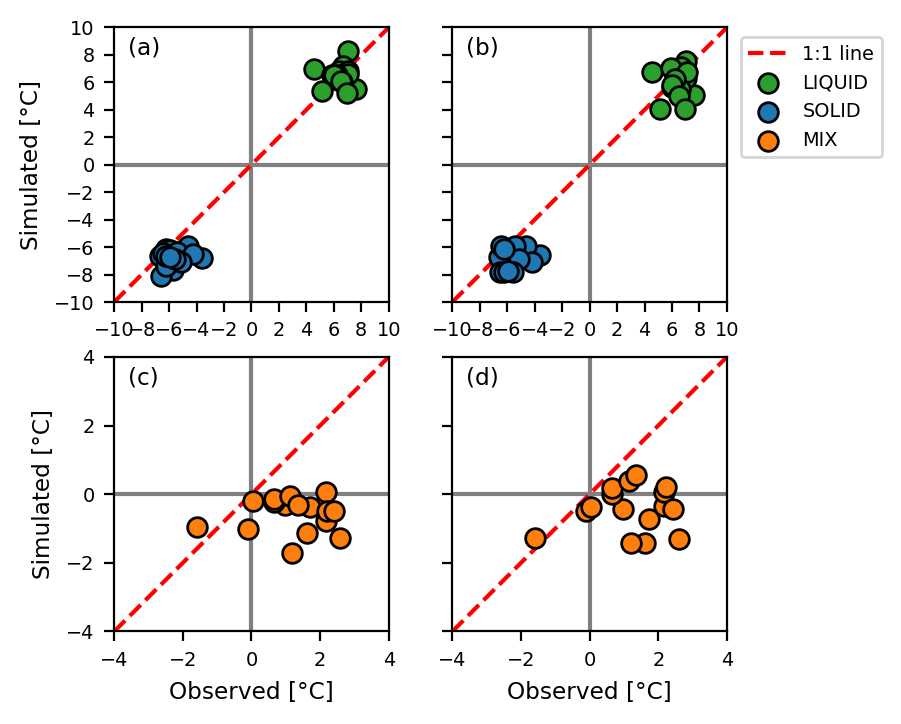

In [20]:
#temp_scatter
# array_pcolor[array_pcolor == np.inf] = 0
fig = plt.figure(facecolor='white',dpi=200,figsize=(4,4))
spec = fig.add_gridspec(ncols=2, nrows=2)
ax0 = fig.add_subplot(spec[0, 0],aspect='equal')
ax1 = fig.add_subplot(spec[0, 1],aspect='equal')
ax2 = fig.add_subplot(spec[1, 0],aspect='equal')
ax3 = fig.add_subplot(spec[1, 1],aspect='equal')

si=50
#liquide 12 km
lliq = ax0.scatter(list_temp_liq[0],list_temp_liq[1],c = 'tab:green',ec='k',s=si,label='LIQUID')
#liquide 2.5 km
ax1.scatter(list_temp_liq[0],list_temp_liq[2],c = 'tab:green',ec='k',s=si)

print(np.corrcoef(list_temp_mix[0],list_temp_mix[1])[0,1])
print(np.corrcoef(list_temp_mix[0],list_temp_mix[2])[0,1])
#Solid 12 km
lsol =ax0.scatter(list_temp_sol[0],list_temp_sol[1],c = 'tab:blue',ec='k',s=si,label='SOLID')
#Solid 2.5 km
ax1.scatter(list_temp_sol[0],list_temp_sol[2],c = 'tab:blue',ec='k',s=si)



#FR 12 km
# lfr = ax2.scatter(np.array(list_frac)[:,0,2],np.array(list_frac)[:,4,2],c = 'tab:red',ec='k',s=si,label='FR')
#FR 2.5 km
# ax3.scatter(np.array(list_frac)[:,0,2],np.array(list_frac)[:,5,2],c = 'tab:red',ec='k',s=si)

#mixFR 12 km
lmix = ax2.scatter(list_temp_mix[0],list_temp_mix[1],c = 'tab:orange',ec='k',s=si,label='MIX')
#mixFR 2.5 km
ax3.scatter(list_temp_mix[0],list_temp_mix[2],c = 'tab:orange',ec='k',s=si)

#mix 12 km
# lmix = ax2.scatter(np.array(list_frac)[:,0,4],np.array(list_frac)[:,4,4],c = 'tab:orange',ec='k',s=si,label='MIX')
#mix 2.5 km
# ax3.scatter(np.array(list_frac)[:,0,4],np.array(list_frac)[:,5,4],c = 'tab:orange',ec='k',s=si)



max_sol = 10
ax0.set_xlim(-10,max_sol)
ax0.set_ylim(-10,max_sol)
ax1.set_xlim(-10,max_sol)
ax1.set_ylim(-10,max_sol)

ax0.set_xticks(np.arange(-10,max_sol+2,2))
ax1.set_xticks(np.arange(-10,max_sol+2,2))
ax0.set_yticks(np.arange(-10,max_sol+2,2))
ax1.set_yticks(np.arange(-10,max_sol+2,2))
ran = np.linspace(-10,max_sol,1000)
l1p1 = ax0.plot(ran,ran,'r--',label='1:1 line',zorder=-99999)
ax1.plot(ran,ran,'r--',zorder=-99999)


max_mix = 4
min_mix = -4
ax2.set_xlim(min_mix,max_mix)
ax2.set_ylim(min_mix,max_mix)
ax3.set_xlim(min_mix,max_mix)
ax3.set_ylim(min_mix,max_mix)

ax2.set_xticks(np.arange(min_mix,max_mix+2,2))
ax3.set_xticks(np.arange(min_mix,max_mix+2,2))
ax2.set_yticks(np.arange(min_mix,max_mix+2,2))
ax3.set_yticks(np.arange(min_mix,max_mix+2,2))

ran = np.linspace(min_mix,max_mix,1000)
ax2.plot(ran,ran,'r--',zorder=-99999)
ax3.plot(ran,ran,'r--',zorder=-99999)



# ax0.legend(fontsize='small')
# ax2.legend(fontsize='small')

bbox = dict(boxstyle="square", fc="w",alpha=0)
ax0.annotate(f'(a)', xy=(0.05, 0.9), bbox=bbox, xycoords='axes fraction', fontsize='small')
ax1.annotate(f'(b)', xy=(0.05, 0.9), bbox=bbox, xycoords='axes fraction', fontsize='small')
ax2.annotate(f'(c)', xy=(0.05, 0.9), bbox=bbox, xycoords='axes fraction', fontsize='small')
ax3.annotate(f'(d)', xy=(0.05, 0.9), bbox=bbox, xycoords='axes fraction', fontsize='small')

ax0.grid(False)
ax1.grid(False)
ax2.grid(False)
ax3.grid(False)

ax0.tick_params(which="both",bottom=True,left=True)
ax1.tick_params(which="both",bottom=True,left=True,labelleft=False)
ax2.tick_params(which="both",bottom=True,left=True)
ax3.tick_params(which="both",bottom=True,left=True,labelleft=False)

# ax0.set_xlabel('Observed [mm]',fontsize='small')
ax0.set_ylabel('Simulated [\u00B0C]',fontsize='small')
# ax1.set_ylabel('Observed [mm]',fontsize='small')
# ax1.set_xlabel('Simulated [mm]')
ax2.set_xlabel('Observed [\u00B0C]',fontsize='small')
ax2.set_ylabel('Simulated [\u00B0C]',fontsize='small')
ax3.set_xlabel('Observed [\u00B0C]',fontsize='small')
# ax3.set_ylabel('Simulated [mm]',fontsize='small')

for ax in [ax0,ax1,ax2,ax3]:
    ax.xaxis.set_tick_params(labelsize='x-small')
    ax.yaxis.set_tick_params(labelsize='x-small')
    ax.hlines(0,-10,10,colors='Grey',zorder=-99999999)
    ax.vlines(0,-10,10,colors='Grey',zorder=-99999999)

handles0, labels0 = ax0.get_legend_handles_labels()
handles1, labels1 = ax2.get_legend_handles_labels()
for i in range(0,len(handles1)):
    handles0.append(handles1[i])
    labels0.append(labels1[i])
# handles0.append(handles1)
# labels0.append(labels1)
ax1.legend(handles0, labels0, loc='upper right',fontsize='x-small', bbox_to_anchor=(1.6, 1))

# fig.legend([l1p1,lliq,lsol,lfr,lmixfr,lmix],fontsize='small',loc="upper right")
image_savepath = fr"/upslope/chalifour/projet_maitrise/fig_v2/fig_scattertemp_stat"
fig.savefig(image_savepath+".png", format='png', bbox_inches='tight')
# fig.savefig(image_savepath+".eps", dpi=200, format='eps', bbox_inches='tight')

plt.show()

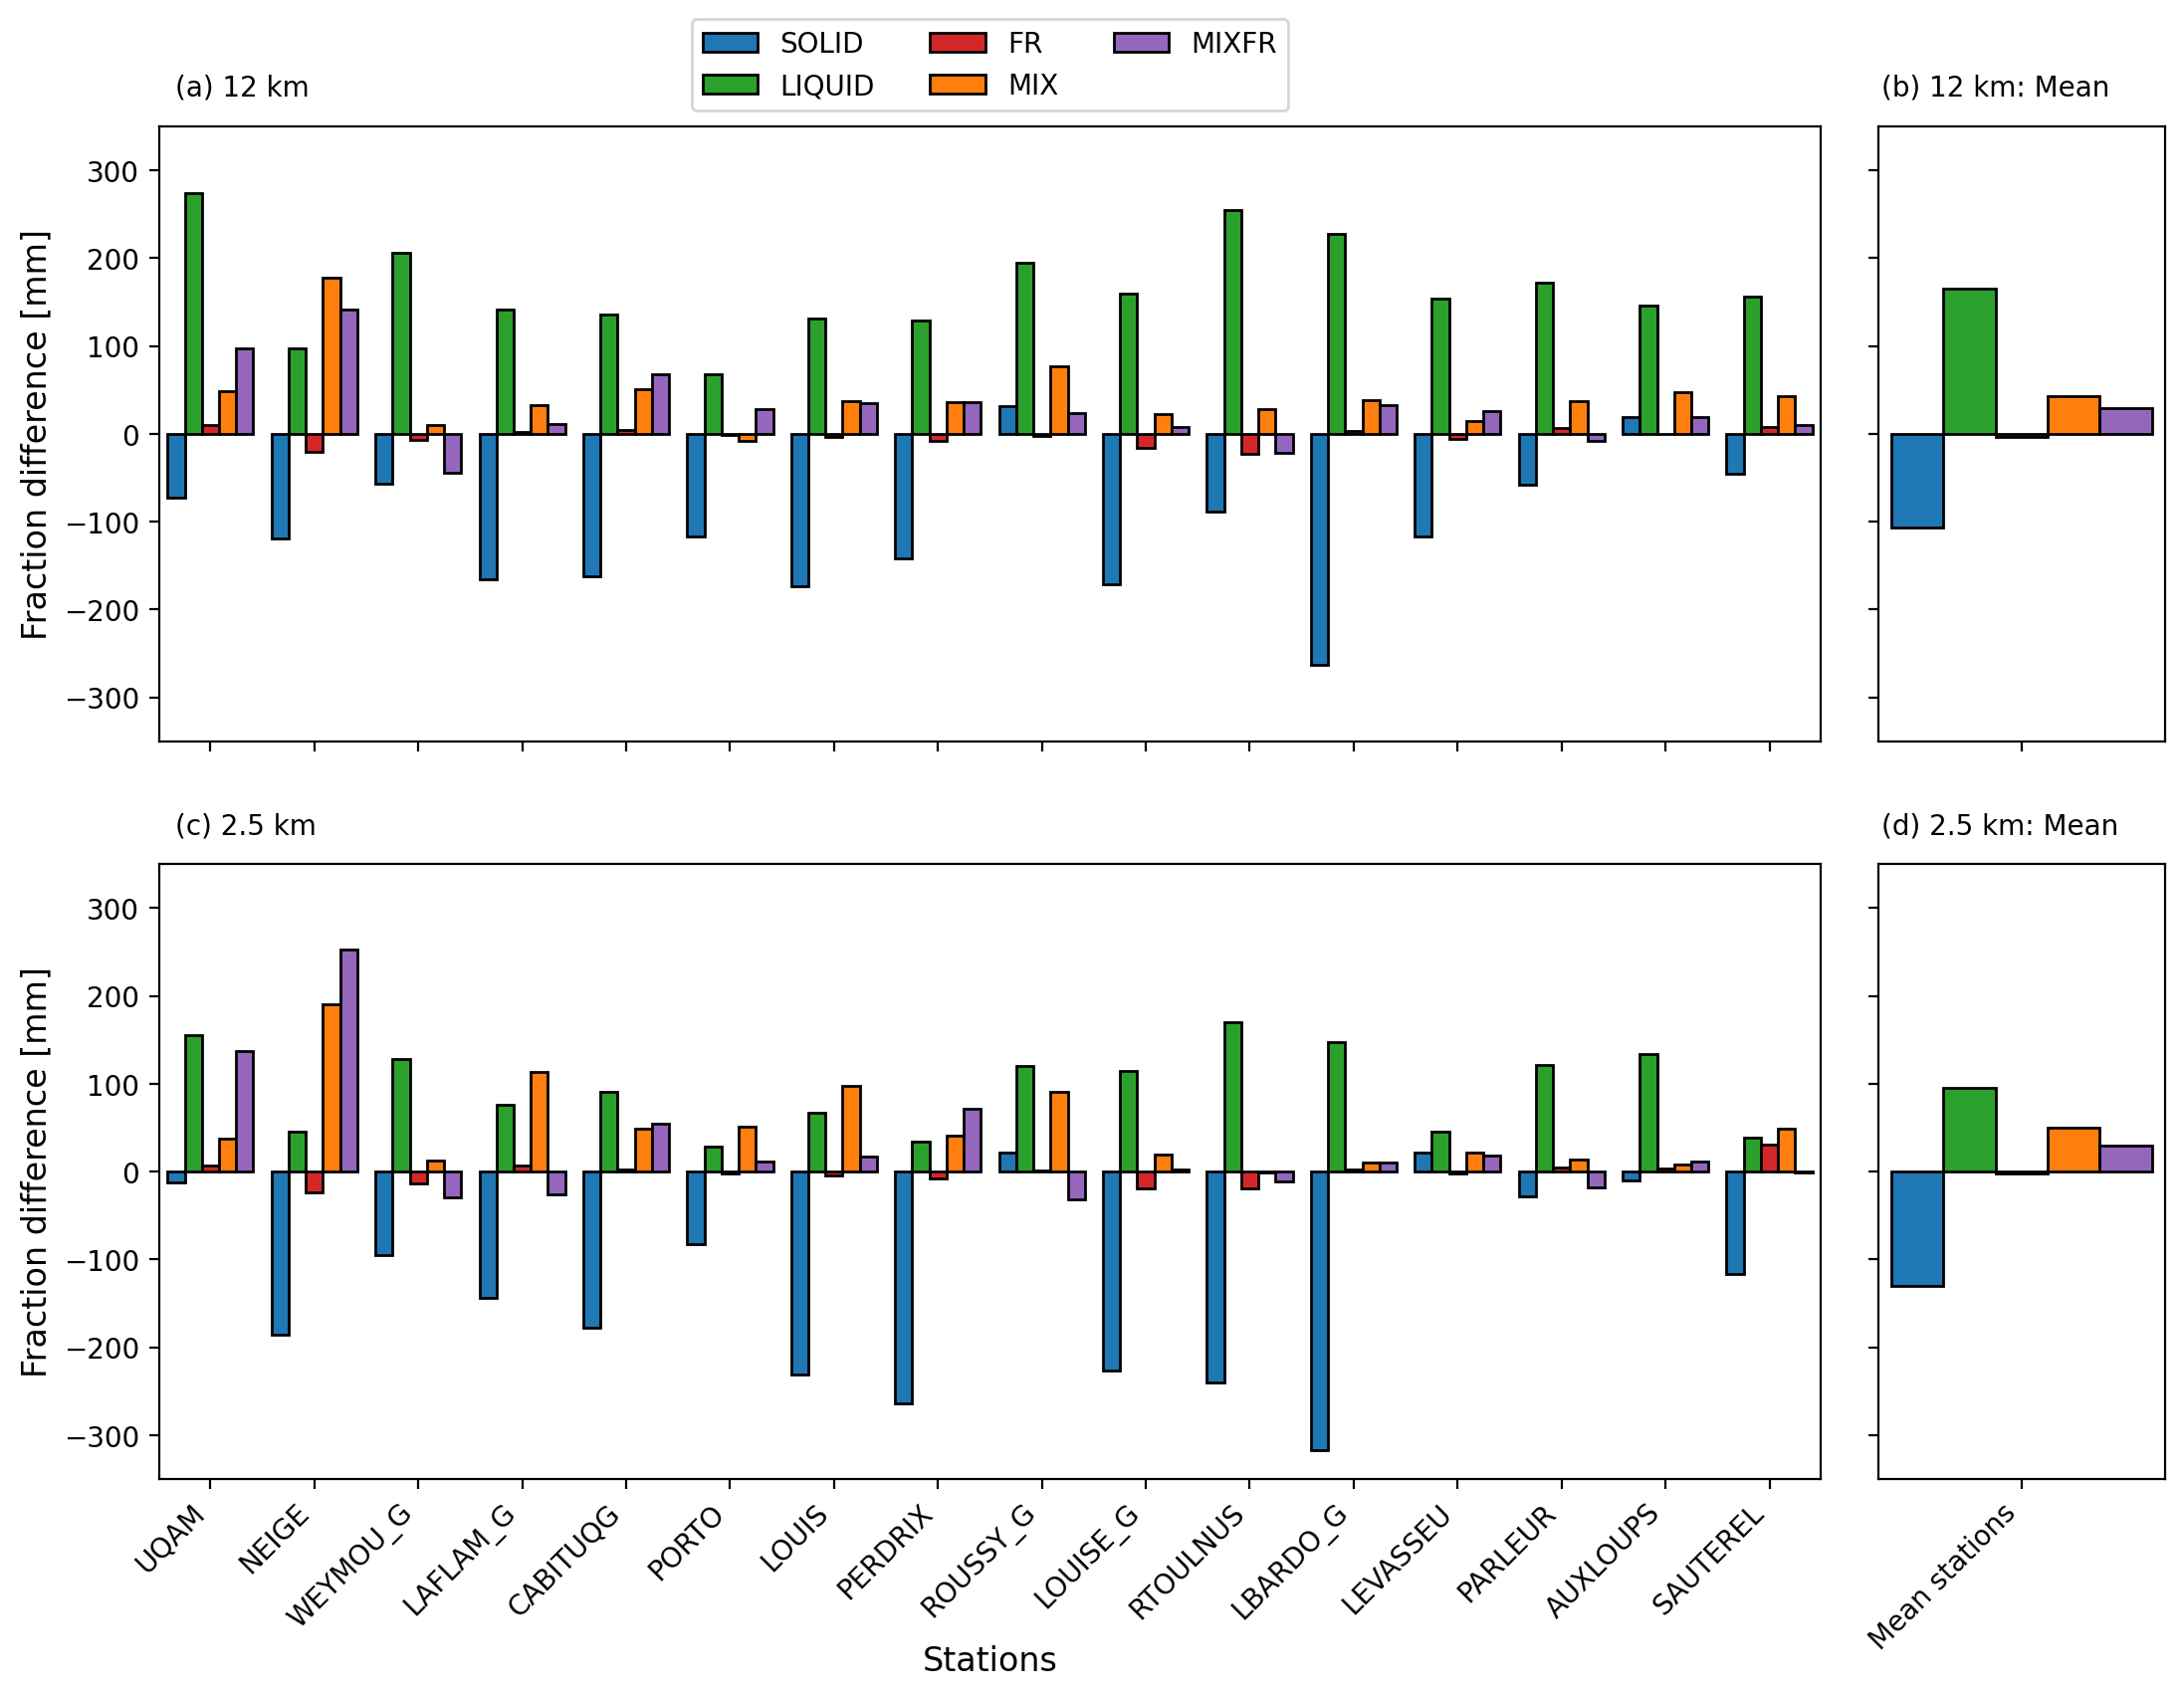

In [36]:
,zorder=-99999999# temp scatter
list_frac_i =list_frac


# liq
diff_12km_liq = -(np.array(list_frac_i)[:,0,1]-np.array(list_frac_i)[:,4,1])
diff_2p5km_liq = -(np.array(list_frac_i)[:,0,1]-np.array(list_frac_i)[:,5,1])
#sol
diff_12km_sol = -(np.array(list_frac_i)[:,0,0]-np.array(list_frac_i)[:,4,0])
diff_2p5km_sol = -(np.array(list_frac_i)[:,0,0]-np.array(list_frac_i)[:,5,0])
# fr
diff_12km_fr = -(np.array(list_frac_i)[:,0,2]-np.array(list_frac_i)[:,4,2])
diff_2p5km_fr = -(np.array(list_frac_i)[:,0,2]-np.array(list_frac_i)[:,5,2])
#mix
diff_12km_mix = -(np.array(list_frac_i)[:,0,4]-np.array(list_frac_i)[:,4,4])
diff_2p5km_mix = -(np.array(list_frac_i)[:,0,4]-np.array(list_frac_i)[:,5,4])
# mixfr
diff_12km_mixfr = -(np.array(list_frac_i)[:,0,3]-np.array(list_frac_i)[:,4,3])
diff_2p5km_mixfr = -(np.array(list_frac_i)[:,0,3]-np.array(list_frac_i)[:,5,3])








fig = plt.figure(facecolor='white',dpi=200,figsize=(13,9))
spec = fig.add_gridspec(ncols=6, nrows=2)
ax0 = fig.add_subplot(spec[0, 0:5])
ax0_mean = fig.add_subplot(spec[0, 5])

ax1 = fig.add_subplot(spec[1, 0:5])
ax1_mean = fig.add_subplot(spec[1, 5])


# all
x = np.arange(len(list_stat))*2
width = 0.33
ax0.bar(x-2*width,diff_12km_sol,color='tab:blue',width=width,edgecolor='k')
ax1.bar(x-2*width,diff_2p5km_sol,color='tab:blue',width=width,edgecolor='k')

ax0.bar(x-width,diff_12km_liq,color='tab:green',width=width,edgecolor='k')
ax1.bar(x-width,diff_2p5km_liq,color='tab:green',width=width,edgecolor='k')

ax0.bar(x,diff_12km_fr,color='tab:red',width=width,edgecolor='k')
ax1.bar(x,diff_2p5km_fr,color='tab:red',width=width,edgecolor='k')

ax0.bar(x+width,diff_12km_mixfr,color='tab:orange',width=width,edgecolor='k')
ax1.bar(x+width,diff_2p5km_mixfr,color='tab:orange',width=width,edgecolor='k')

ax0.bar(x+2*width,diff_12km_mix,color='tab:purple',width=width,edgecolor='k')
ax1.bar(x+2*width,diff_2p5km_mix,color='tab:purple',width=width,edgecolor='k')

# mean
ax0_mean.bar(0-2*width,np.mean(diff_12km_sol),color='tab:blue',width=width,edgecolor='k')
ax1_mean.bar(0-2*width,np.mean(diff_2p5km_sol),color='tab:blue',width=width,edgecolor='k')

ax0_mean.bar(0-width,np.mean(diff_12km_liq),color='tab:green',width=width,edgecolor='k')
ax1_mean.bar(0-width,np.mean(diff_2p5km_liq),color='tab:green',width=width,edgecolor='k')

ax0_mean.bar(0,np.mean(diff_12km_fr),color='tab:red',width=width,edgecolor='k')
ax1_mean.bar(0,np.mean(diff_2p5km_fr),color='tab:red',width=width,edgecolor='k')

ax0_mean.bar(0+width,np.mean(diff_12km_mixfr),color='tab:orange',width=width,edgecolor='k')
ax1_mean.bar(0+width,np.mean(diff_2p5km_mixfr),color='tab:orange',width=width,edgecolor='k')

ax0_mean.bar(0+2*width,np.mean(diff_12km_mix),color='tab:purple',width=width,edgecolor='k')
ax1_mean.bar(0+2*width,np.mean(diff_2p5km_mix),color='tab:purple',width=width,edgecolor='k')


# only mix,mixfr,fr
# x = np.arange(len(list_stat))
# width = 0.25
# ax0.bar(x-width,diff_12km_fr,color='tab:red',width=width,edgecolor='k')
# ax1.bar(x-width,diff_2p5km_fr,color='tab:red',width=width,edgecolor='k')
#
# ax0.bar(x,diff_12km_mixfr,color='tab:orange',width=width,edgecolor='k')
# ax1.bar(x,diff_2p5km_mixfr,color='tab:orange',width=width,edgecolor='k')
#
# ax0.bar(x+width,diff_12km_mix,color='tab:purple',width=width,edgecolor='k')
# ax1.bar(x+width,diff_2p5km_mix,color='tab:purple',width=width,edgecolor='k')
#
# ax0_mean.bar(0-width,np.mean(diff_12km_fr),color='tab:red',width=width,edgecolor='k')
# ax1_mean.bar(0-width,np.mean(diff_2p5km_fr),color='tab:red',width=width,edgecolor='k')
#
# ax0_mean.bar(0,np.mean(diff_12km_mixfr),color='tab:orange',width=width,edgecolor='k')
# ax1_mean.bar(0,np.mean(diff_2p5km_mixfr),color='tab:orange',width=width,edgecolor='k')
#
# ax0_mean.bar(0+width,np.mean(diff_12km_mix),color='tab:purple',width=width,edgecolor='k')
# ax1_mean.bar(0+width,np.mean(diff_2p5km_mix),color='tab:purple',width=width,edgecolor='k')

ax1.set_xticks(x)
ax1.set_xticklabels(list_stat, rotation=45, ha='right')
# ax0.set_ylabel('Accumulation difference [mm]', fontsize=12)
# ax1.set_ylabel('Accumulation difference [mm]', fontsize=12)

ax0.set_ylabel('Fraction difference [mm]', fontsize=12)
ax1.set_ylabel('Fraction difference [mm]', fontsize=12)

ax1.set_xlim(x[0] - width * 3, x[-1] + width * 3)
ax1.set_xlabel('Stations', fontsize=12)
ax1.set_xticklabels(list_stat, rotation=45, ha='right')
ax0.tick_params(which="both",bottom=True,labelbottom=False,left=True,labelleft=True)
ax0_mean.tick_params(which="both",bottom=True,labelbottom=False,left=True,labelleft=False)
ax1_mean.tick_params(which="both",bottom=True,labelbottom=True,left=True,labelleft=False)
ax0.annotate(f'(a) 12 km', xy=(0.01, 1.05), bbox=bbox, xycoords='axes fraction', fontsize=10)

ax1.annotate(f'(c) 2.5 km', xy=(0.01, 1.05), bbox=bbox, xycoords='axes fraction', fontsize=10)

ax0.sharex(ax1)
ax0_mean.sharex(ax1_mean)
ax0.set_ylim(-350, 350)
ax1.set_ylim(-350, 350)
ax0_mean.set_ylim(-350, 350)
ax1_mean.set_ylim(-350, 350)

# ax0.set_ylim(-50, 300)
# ax1.set_ylim(-50, 300)
# ax0_mean.set_ylim(-50, 300)
# ax1_mean.set_ylim(-50, 300)


ax1_mean.set_xticks([0])
ax1_mean.set_xticklabels(['Mean stations'], rotation=45, ha='right')
ax0_mean.annotate(f'(b) 12 km: Mean', xy=(0.01, 1.05), bbox=bbox, xycoords='axes fraction', fontsize=10)
ax1_mean.annotate(f'(d) 2.5 km: Mean', xy=(0.01, 1.05), bbox=bbox, xycoords='axes fraction', fontsize=10)

# ax0.set_ylim(-0.3, 0.3)
# ax1.set_ylim(-0.3, 0.3)
# ax0_mean.set_ylim(-0.3, 0.3)
# ax1_mean.set_ylim(-0.3, 0.3)


# ax0.set_ylim(-0.1, 0.2)
# ax1.set_ylim(-0.1, 0.2)
# ax0_mean.set_ylim(-0.1, 0.2)
# ax1_mean.set_ylim(-0.1, 0.2)
# ax0.legend(['FR','MIX','MIXFR'],loc='center', bbox_to_anchor=(0.5, 1.10),ncol=3)
ax0.legend(['SOLID','LIQUID','FR','MIX','MIXFR'],loc='center', bbox_to_anchor=(0.5, 1.10),ncol=3)
plt.show()
plt.close(fig)



<ipython-input-38-9245afbbe31d>:19: RuntimeWarning: divide by zero encountered in true_divide
  diff_12km_fr = -(np.array(list_frac_i)[:,0,2]-np.array(list_frac_i)[:,4,2])/np.array(list_frac_i)[:,0,2]
<ipython-input-38-9245afbbe31d>:27: RuntimeWarning: divide by zero encountered in true_divide
  diff_2p5km_fr = -(np.array(list_frac_i)[:,0,2]-np.array(list_frac_i)[:,5,2])/np.array(list_frac_i)[:,0,2]


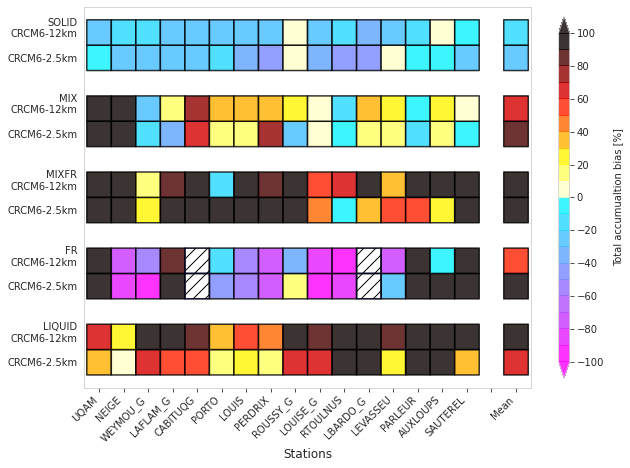

In [38]:
import matplotlib.colors as mcolors
list_frac_i =list_frac
len_stat=len(np.array(list_frac_i)[:,0,1])
x = np.arange(len(list_stat)+2)
y = np.arange(len(list_stat))

nan_sep = np.full(len_stat+2,np.nan)
# liq
diff_12km_liq = -(np.array(list_frac_i)[:,0,1]-np.array(list_frac_i)[:,4,1])/np.array(list_frac_i)[:,0,1]
diff_12km_liq =np.append(diff_12km_liq,[np.nan,np.nanmean(diff_12km_liq)])
diff_2p5km_liq = -(np.array(list_frac_i)[:,0,1]-np.array(list_frac_i)[:,5,1])/np.array(list_frac_i)[:,0,1]
diff_2p5km_liq = np.append(diff_2p5km_liq,[np.nan,np.nanmean(diff_2p5km_liq)])
#sol
diff_12km_sol = -(np.array(list_frac_i)[:,0,0]-np.array(list_frac_i)[:,4,0])/np.array(list_frac_i)[:,0,0]
diff_12km_sol = np.append(diff_12km_sol,[np.nan,np.nanmean(diff_12km_sol)])
diff_2p5km_sol = -(np.array(list_frac_i)[:,0,0]-np.array(list_frac_i)[:,5,0])/np.array(list_frac_i)[:,0,0]
diff_2p5km_sol = np.append(diff_2p5km_sol,[np.nan,np.nanmean(diff_2p5km_sol)])
# fr
diff_12km_fr = -(np.array(list_frac_i)[:,0,2]-np.array(list_frac_i)[:,4,2])/np.array(list_frac_i)[:,0,2]

mask_12 = diff_12km_fr == np.inf
diff_12km_fr[mask_12] = np.nan
mean_12 = np.nanmean(diff_12km_fr)
diff_12km_fr[mask_12] = 999

diff_12km_fr = np.append(diff_12km_fr,[np.nan,mean_12])
diff_2p5km_fr = -(np.array(list_frac_i)[:,0,2]-np.array(list_frac_i)[:,5,2])/np.array(list_frac_i)[:,0,2]

mask_2p5 = diff_2p5km_fr == np.inf
diff_2p5km_fr[mask_2p5] = np.nan
mean_2p5 = np.nanmean(diff_2p5km_fr)

diff_2p5km_fr[mask_2p5] = 999

diff_2p5km_fr = np.append(diff_2p5km_fr,[np.nan,mean_2p5])
#mix
diff_12km_mix = -(np.array(list_frac_i)[:,0,4]-np.array(list_frac_i)[:,4,4])/np.array(list_frac_i)[:,0,4]
diff_12km_mix =np.append(diff_12km_mix,[np.nan,np.nanmean(diff_12km_mix)])
diff_2p5km_mix = -(np.array(list_frac_i)[:,0,4]-np.array(list_frac_i)[:,5,4])/np.array(list_frac_i)[:,0,4]
diff_2p5km_mix = np.append(diff_2p5km_mix,[np.nan,np.nanmean(diff_2p5km_mix)])
# mixfr
diff_12km_mixfr = -(np.array(list_frac_i)[:,0,3]-np.array(list_frac_i)[:,4,3])/np.array(list_frac_i)[:,0,3]
diff_12km_mixfr = np.append(diff_12km_mixfr,[np.nan,np.nanmean(diff_12km_mixfr)])
diff_2p5km_mixfr = -(np.array(list_frac_i)[:,0,3]-np.array(list_frac_i)[:,5,3])/np.array(list_frac_i)[:,0,3]
diff_2p5km_mixfr = np.append(diff_2p5km_mixfr,[np.nan,np.nanmean(diff_2p5km_mixfr)])

array_pcolor= np.array([nan_sep,diff_2p5km_liq,diff_12km_liq,
                        nan_sep,diff_2p5km_fr,diff_12km_fr,
                        nan_sep,diff_2p5km_mixfr,diff_12km_mixfr,
                        nan_sep,diff_2p5km_mix,diff_12km_mix,
                        nan_sep,diff_2p5km_sol,diff_12km_sol,nan_sep])



# array_pcolor[array_pcolor == np.inf] = 0
fig = plt.figure(facecolor='white',figsize=(10,7))
spec = fig.add_gridspec(ncols=1, nrows=1)
ax0 = fig.add_subplot(spec[0, 0])
bounds = np.arange(-100, 100+10, 10)


#a = np.append(-np.logspace(-1.0, 3, num=25)[::-1],[0])
#bounds = np.append(a,np.logspace(-1.0, 3, num=25))
#bounds = [-250,-200,-150,-100,-75,-50,-25,-15,-10,-7.5,-5,-2.5,-1,0,1,2.5,5,7.5,10,15,25,50,75,100,150,200,250]
# cmap_1 = plt.get_cmap('seismic')
# cmap_2 = plt.get_cmap('seismic_r')
cmap_1 = plt.cm.cool_r(np.linspace(0., 1, 128))
cmap_2 = plt.cm.hot_r(np.linspace(0, 1, 128))

colors = np.vstack((cmap_1, cmap_2))
mymap = mcolors.LinearSegmentedColormap.from_list('my_colormap', colors)
norm = BoundaryNorm(bounds, ncolors=mymap.N+2, clip=True)


# colormesh = ax0.pcolormesh(x,x,array_pcolor,cmap='jet',norm=norm)
array_pcolor_m = np.ma.masked_where(array_pcolor == 999,array_pcolor)
array_mask_fr = np.ma.masked_where(array_pcolor != 999,array_pcolor)
array_mask_fr[array_pcolor == 999] = 1
colormesh = ax0.pcolor(x, y, array_pcolor_m*100, facecolor='k', edgecolor='k',linewidth=1.5,cmap=mymap ,norm = norm,shading='auto',alpha=0.8 )
ax0.pcolor(x, y, array_mask_fr,hatch = '//' ,facecolor='none', edgecolor='k',linewidth=1.5,alpha=1,shading='auto' )
list_stat_x = list_stat+[' ',"Mean"]

ax0.set_xticks(x)
ax0.set_xticklabels(list_stat_x, rotation=45, ha='right')
ax0.set_xlabel('Stations', fontsize=12)
label_y = ['','CRCM6-2.5km','LIQUID\nCRCM6-12km\n','',
           'CRCM6-2.5km','FR\nCRCM6-12km\n','',
           'CRCM6-2.5km','MIXFR\nCRCM6-12km\n','',
           'CRCM6-2.5km','MIX\nCRCM6-12km\n','',
           'CRCM6-2.5km','SOLID\nCRCM6-12km\n','']
ax0.set_yticks(y)
ax0.set_yticklabels(label_y, rotation=0, ha='right')
ax1.set_xlabel('Stations', fontsize=12)
ax0.tick_params(which="both",bottom=True,labelbottom=True,left=False,labelleft=True)
ax0.set_xlim(x[0]-0.6,x[-1]+0.6)
ax0.set_ylim(y[0],y[-1])
cbar = plt.colorbar(colormesh,shrink=0.95, aspect=30,extend='both',ticks=bounds[::2])
cbar.set_label(f"Total accumualtion bias [%]", fontsize=10, labelpad=9)
cbar.ax.tick_params(labelsize=10)


image_savepath = fr"/upslope/chalifour/projet_maitrise/fig_v2/fig_biaispercent_stat"
fig.savefig(image_savepath+".png", format='png', bbox_inches='tight')
# fig.savefig(image_savepath+".eps", dpi=200, format='eps', bbox_inches='tight')

plt.show()

In [44]:
def RMSE(array_sim,array_ref):
    # biais = np.sqrt(np.nanmean((array_sim-array_ref) ** 2))
    biais = np.nanmean(array_sim-array_ref)
    return biais

In [58]:
# station
list_stat_prob = ['GAREMANG','PIPMUA_G']
list_stat = []
list_lat = []
list_frac=[]
list_fnan=[]
list_mean_speed = []
list_zeros = []
df_era5=pd.read_csv(f'/upslope/chalifour/projet_maitrise/dataframe_obs_formated/dataframe_ERA5_stat_formated_{begin_date_1.year}_{end_date_1.year}.csv')
for lat,subdf in dataframe_1h.groupby('lat'):

    subdf.sort_index(inplace=True)
    stat = subdf.filename[0]
    subdf = subdf.loc[begin_t:end_t]
    pr_total = subdf['frac_solide'].sum(axis=0)+subdf['frac_liquide'].sum(axis=0)+subdf['frac_mix_fr'].sum(axis=0)+subdf['frac_mix'].sum(axis=0)+subdf['frac_FZ'].sum(axis=0)+subdf['f_0'].sum(axis=0)
    if pr_total !=0:
        pr_total=1
        frac_sol_obs = subdf['frac_solide']/pr_total
        frac_liq_obs = subdf['frac_liquide']/pr_total
        frac_fz_obs = subdf['frac_FZ']/pr_total
        frac_mix_obs_fr = subdf['frac_mix_fr']/pr_total
        frac_mix_obs = subdf['frac_mix']/pr_total
        frac_zero_obs = subdf['f_0']/pr_total
        frac_fnan_obs = subdf['f_nan']/pr_total
        list_zeros.append(frac_zero_obs)
        list_fnan.append(frac_fnan_obs)
        subdf_11km = dataframe_11km_stat.loc[dataframe_11km_stat['filename']==stat]
        subdf_11km=subdf_11km.loc[begin_t:end_t]


        pr_total_11km = subdf_11km['frac_solide'].sum(axis=0)+ subdf_11km['frac_liquide'].sum(axis=0)+ subdf_11km['frac_mix_fr'].sum(axis=0)+subdf_11km['frac_mix'].sum(axis=0)+subdf_11km['frac_FZ'].sum(axis=0)

        pr_total_11km=1
        frac_sol_11km = subdf_11km['frac_solide']/pr_total_11km
        frac_liq_11km = subdf_11km['frac_liquide']/pr_total_11km
        frac_fz_11km = subdf_11km['frac_FZ']/pr_total_11km
        frac_mix_11km_fr = subdf_11km['frac_mix_fr']/pr_total_11km
        frac_mix_11km = subdf_11km['frac_mix']/pr_total_11km

        subdf_2p5km = dataframe_2p5km_stat.loc[dataframe_2p5km_stat['filename']==stat]
        subdf_2p5km=subdf_2p5km.loc[begin_t:end_t]
        pr_total_2p5km =subdf_2p5km['frac_solide']+subdf_2p5km['frac_liquide'].sum(axis=0)+subdf_2p5km['frac_mix'].sum(axis=0)+subdf_2p5km['frac_mix_fr'].sum(axis=0)+subdf_2p5km['frac_FZ'].sum(axis=0)

        pr_total_2p5km=1
        frac_sol_2p5km = subdf_2p5km['frac_solide']/pr_total_2p5km
        frac_liq_2p5km = subdf_2p5km['frac_liquide']/pr_total_2p5km
        frac_fz_2p5km = subdf_2p5km['frac_FZ']/pr_total_2p5km
        frac_mix_2p5km_fr = subdf_2p5km['frac_mix_fr']/pr_total_2p5km
        frac_mix_2p5km = subdf_2p5km['frac_mix']/pr_total_2p5km


        subdf_era5 = df_era5.loc[df_era5['filename']==stat]
        pr_total_era5 =subdf_era5['SOLID']+subdf_era5['LIQUID'].sum(axis=0)+subdf_era5['FR'].sum(axis=0)+subdf_era5['MIXFR'].sum(axis=0)+subdf_era5['MIX'].sum(axis=0)
        frac_sol_era5 = subdf_era5['SOLID']/pr_total_era5
        frac_liq_era5 = subdf_era5['LIQUID']/pr_total_era5
        frac_fz_era5 = subdf_era5['FR']/pr_total_era5
        frac_mix_era5_fr = subdf_era5['MIXFR']/pr_total_era5
        frac_mix_era5 = subdf_era5['MIX']/pr_total_era5

        subdf_11kmP3 = dataframe_11kmP3_stat.loc[dataframe_11kmP3_stat['filename']==stat]
        subdf_11kmP3=subdf_11kmP3.loc[begin_t:end_t]
        pr_total_11kmP3 = subdf_11kmP3['frac_solide'].sum(axis=0)+ subdf_11kmP3['frac_liquide'].sum(axis=0)+ subdf_11kmP3['frac_mix_fr'].sum(axis=0)+subdf_11kmP3['frac_mix'].sum(axis=0)+subdf_11kmP3['frac_FZ'].sum(axis=0)

        pr_total_11kmP3=1
        frac_sol_11kmP3 = subdf_11kmP3['frac_solide']/pr_total_11kmP3
        frac_liq_11kmP3 = subdf_11kmP3['frac_liquide']/pr_total_11kmP3
        frac_fz_11kmP3 = subdf_11kmP3['frac_FZ']/pr_total_11kmP3
        frac_mix_11kmP3_fr = subdf_11kmP3['frac_mix_fr']/pr_total_11kmP3
        frac_mix_11kmP3 = subdf_11kmP3['frac_mix']/pr_total_11kmP3

        subdf_2p5kmP3 = dataframe_2p5kmP3_stat.loc[dataframe_2p5kmP3_stat['filename']==stat]
        subdf_2p5kmP3=subdf_2p5kmP3.loc[begin_t:end_t]
        pr_total_2p5kmP3 = subdf_2p5kmP3['frac_solide'].sum(axis=0)+ subdf_2p5kmP3['frac_liquide'].sum(axis=0)+ subdf_2p5kmP3['frac_mix_fr'].sum(axis=0)+subdf_2p5kmP3['frac_mix'].sum(axis=0)+subdf_2p5kmP3['frac_FZ'].sum(axis=0)

        pr_total_2p5kmP3=1
        frac_sol_2p5kmP3 = subdf_2p5kmP3['frac_solide']/pr_total_2p5kmP3
        frac_liq_2p5kmP3 = subdf_2p5kmP3['frac_liquide']/pr_total_2p5kmP3
        frac_fz_2p5kmP3 = subdf_2p5kmP3['frac_FZ']/pr_total_2p5kmP3
        frac_mix_2p5kmP3_fr = subdf_2p5kmP3['frac_mix_fr']/pr_total_2p5kmP3
        frac_mix_2p5kmP3 = subdf_2p5kmP3['frac_mix']/pr_total_2p5kmP3
        # mask = np.isnan(subdf['temp_moy'])| np.isnan(subdf_2p5km['TT'])
        # print(subdf['temp_moy'][~mask])
        # a,b=np.polyfit(subdf['temp_moy'][~mask],subdf_2p5km['TT'][~mask],deg=1)
        #
        # plt.scatter(subdf['temp_moy'],subdf_2p5km['TT'])
        # plt.plot(subdf['temp_moy'],a*subdf['temp_moy']+b,color='r')
        # plt.plot(subdf_2p5km['TT'],subdf_2p5km['TT'],color='k')
        # plt.show()


        # print(stat,f'Diff Obs - 12 km Solid: {frac_sol_obs-frac_sol_11kmP3*10/8:.2f}')
        print()
        # stat,f'Diff Obs - 2.5 km Solid: {frac_sol_obs-frac_sol_2p5kmP3}'
        list_frac.append([[RMSE(frac_sol_obs,frac_sol_obs),RMSE(frac_liq_obs,frac_liq_obs),RMSE(frac_fz_obs,frac_fz_obs),RMSE(frac_mix_obs_fr,frac_mix_obs_fr),RMSE(frac_mix_obs,frac_mix_obs)],
                     [RMSE(frac_sol_11km,frac_sol_obs),RMSE(frac_liq_11km,frac_liq_obs),RMSE(frac_fz_11km,frac_fz_obs),RMSE(frac_mix_11km_fr,frac_mix_obs_fr),RMSE(frac_mix_11km,frac_mix_obs)],
                     [RMSE(frac_sol_2p5km,frac_sol_obs),RMSE(frac_liq_2p5km,frac_liq_obs),RMSE(frac_fz_2p5km,frac_fz_obs),RMSE(frac_mix_2p5km_fr,frac_mix_obs_fr),RMSE(frac_mix_2p5km,frac_mix_obs)],
                     [RMSE(frac_sol_era5,frac_sol_obs),RMSE(frac_liq_era5,frac_liq_obs),RMSE(frac_fz_era5,frac_fz_obs),RMSE(frac_mix_era5_fr,frac_mix_obs_fr),RMSE(frac_mix_era5,frac_mix_obs)],
                     [RMSE(frac_sol_11kmP3,frac_sol_obs),RMSE(frac_liq_11kmP3,frac_liq_obs),RMSE(frac_fz_11kmP3,frac_fz_obs),RMSE(frac_mix_11kmP3_fr,frac_mix_obs_fr),RMSE(frac_mix_11kmP3,frac_mix_obs)],
                    [RMSE(frac_sol_2p5kmP3,frac_sol_obs),RMSE(frac_liq_2p5kmP3,frac_liq_obs),RMSE(frac_fz_2p5kmP3,frac_fz_obs),RMSE(frac_mix_2p5kmP3_fr,frac_mix_obs_fr),RMSE(frac_mix_2p5kmP3,frac_mix_obs)]])
        list_stat.append(stat)
        list_lat.append(lat)


        mean_wind = np.nanmean(subdf['vitesse_vent_moy_2_5m']/3.6)
        list_mean_speed.append(mean_wind)
        # print(f"{stat} mean wind speed: {mean_wind:.2f}")



# uqam et momo

list_stat.insert(0,'UQAM')
dataframe_uqam = dataframe_uqam.loc[begin_t:end_t]
pr_totaluqam = dataframe_uqam['frac_solide'].sum(axis=0)+dataframe_uqam['frac_liquide'].sum(axis=0)+dataframe_uqam['frac_mix_fr'].sum(axis=0)+dataframe_uqam['frac_mix'].sum(axis=0)+dataframe_uqam['frac_FZ'].sum(axis=0)+dataframe_uqam['f_0'].sum(axis=0)
pr_totaluqam=1
frac_sol_obsuqam = dataframe_uqam['frac_solide']/pr_totaluqam
frac_liq_obsuqam = dataframe_uqam['frac_liquide']/pr_totaluqam
frac_fz_obsuqam= dataframe_uqam['frac_FZ']/pr_totaluqam
frac_mix_obsuqam_fr = dataframe_uqam['frac_mix_fr']/pr_totaluqam
frac_mix_obsuqam = dataframe_uqam['frac_mix']/pr_totaluqam
frac_zero_obsuqam = dataframe_uqam['f_0']/pr_totaluqam
frac_fnan_obsuqam = dataframe_uqam['f_nan']/pr_totaluqam
list_zeros.insert(0,frac_zero_obsuqam)
list_fnan.insert(0,frac_fnan_obsuqam)
# mean_wind_uqam = np.mean(dataframe_uqam['vitesse_vent_moy_10m'])
list_mean_speed.insert(0,np.nan)

subdf_11kmuqam = dataframe_11km_Umomo.loc[dataframe_11km_Umomo['filename']=='UQAM_PK']
subdf_11kmuqam  = subdf_11kmuqam.loc[begin_t:end_t]

pr_total_11kmuqam = subdf_11kmuqam['frac_solide'].sum(axis=0)+ subdf_11kmuqam['frac_liquide'].sum(axis=0)+ subdf_11kmuqam['frac_mix_fr'].sum(axis=0)+subdf_11kmuqam['frac_mix'].sum(axis=0)+subdf_11kmuqam['frac_FZ'].sum(axis=0)
pr_total_11kmuqam=1
frac_sol_11kmuqam = subdf_11kmuqam['frac_solide']/pr_total_11kmuqam
frac_liq_11kmuqam = subdf_11kmuqam['frac_liquide']/pr_total_11kmuqam
frac_fz_11kmuqam= subdf_11kmuqam['frac_FZ']/pr_total_11kmuqam
frac_mix_11kmuqam_fr = subdf_11kmuqam['frac_mix_fr']/pr_total_11kmuqam
frac_mix_11kmuqam = subdf_11kmuqam['frac_mix']/pr_total_11kmuqam


subdf_2p5kmuqam = dataframe_2p5km_Umomo.loc[dataframe_2p5km_Umomo['filename']=='UQAM_PK']
subdf_2p5kmuqam  = subdf_2p5kmuqam.loc[begin_t:end_t]
pr_total_2p5kmuqam =subdf_2p5kmuqam['frac_solide'].sum(axis=0)+subdf_2p5kmuqam['frac_liquide'].sum(axis=0)+subdf_2p5kmuqam['frac_mix_fr'].sum(axis=0)+subdf_2p5kmuqam['frac_mix'].sum(axis=0)+subdf_2p5kmuqam['frac_FZ'].sum(axis=0)
pr_total_2p5kmuqam = 1
frac_sol_2p5kmuqam = subdf_2p5kmuqam['frac_solide']/pr_total_2p5kmuqam
frac_liq_2p5kmuqam = subdf_2p5kmuqam['frac_liquide']/pr_total_2p5kmuqam
frac_fz_2p5kmuqam= subdf_2p5kmuqam['frac_FZ']/pr_total_2p5kmuqam
frac_mix_2p5kmuqam_fr = subdf_2p5kmuqam['frac_mix_fr']/pr_total_2p5kmuqam
frac_mix_2p5kmuqam = subdf_2p5kmuqam['frac_mix']/pr_total_2p5kmuqam

subdf_11kmP3uqam = dataframe_11kmP3_Umomo.loc[dataframe_11kmP3_Umomo['filename']=='UQAM_PK']

subdf_11kmP3uqam  = subdf_11kmP3uqam.loc[begin_t:end_t]
pr_total_11kmP3uqam = subdf_11kmP3uqam['frac_solide'].sum(axis=0)+ subdf_11kmP3uqam['frac_liquide'].sum(axis=0)+ subdf_11kmP3uqam['frac_mix_fr'].sum(axis=0)+subdf_11kmP3uqam['frac_mix'].sum(axis=0)+subdf_11kmP3uqam['frac_FZ'].sum(axis=0)
pr_total_11kmP3uqam=1
frac_sol_11kmP3uqam = subdf_11kmP3uqam['frac_solide']/pr_total_11kmP3uqam
frac_liq_11kmP3uqam = subdf_11kmP3uqam['frac_liquide']/pr_total_11kmP3uqam
frac_fz_11kmP3uqam= subdf_11kmP3uqam['frac_FZ']/pr_total_11kmP3uqam
frac_mix_11kmP3uqam_fr = subdf_11kmP3uqam['frac_mix_fr']/pr_total_11kmP3uqam
frac_mix_11kmP3uqam = subdf_11kmP3uqam['frac_mix']/pr_total_11kmP3uqam

df_era5_uqammomo=pd.read_csv(f'/upslope/chalifour/projet_maitrise/dataframe_obs_formated/dataframe_ERA5_uqammomo_formated_{begin_date_1.year}_{end_date_1.year}.csv')
#
subdf_era5_uqam = df_era5_uqammomo.loc[df_era5_uqammomo['filename']=='UQAM_PK']

pr_total_era5uqam =subdf_era5_uqam['SOLID'].sum(axis=0)+subdf_era5_uqam['LIQUID'].sum(axis=0)+subdf_era5_uqam['FR'].sum(axis=0)+subdf_era5_uqam['MIXFR'].sum(axis=0)+subdf_era5_uqam['MIX'].sum(axis=0)

frac_sol_era5_uqam = subdf_era5_uqam['SOLID']/pr_total_era5uqam
frac_liq_era5_uqam = subdf_era5_uqam['LIQUID']/pr_total_era5uqam
frac_fz_era5_uqam = subdf_era5_uqam['FR']/pr_total_era5uqam
frac_mix_era5_fr_uqam = subdf_era5_uqam['MIXFR']/pr_total_era5uqam
frac_mix_era5_uqam = subdf_era5_uqam['MIX']/pr_total_era5uqam

subdf_2p5kmP3uqam = dataframe_2p5kmP3_Umomo.loc[dataframe_2p5kmP3_Umomo['filename']=='UQAM_PK']
subdf_2p5kmP3uqam  = subdf_2p5kmP3uqam.loc[begin_t:end_t]
pr_total_2p5kmP3uqam = subdf_2p5kmP3uqam['frac_solide'].sum(axis=0)+ subdf_2p5kmP3uqam['frac_liquide'].sum(axis=0)+ subdf_2p5kmP3uqam['frac_mix_fr'].sum(axis=0)+subdf_2p5kmP3uqam['frac_mix'].sum(axis=0)+subdf_2p5kmP3uqam['frac_FZ'].sum(axis=0)
pr_total_2p5kmP3uqam=1
frac_sol_2p5kmP3uqam = subdf_2p5kmP3uqam['frac_solide']/pr_total_2p5kmP3uqam
frac_liq_2p5kmP3uqam = subdf_2p5kmP3uqam['frac_liquide']/pr_total_2p5kmP3uqam
frac_fz_2p5kmP3uqam = subdf_2p5kmP3uqam['frac_FZ']/pr_total_2p5kmP3uqam
frac_mix_2p5kmP3uqam_fr = subdf_2p5kmP3uqam['frac_mix_fr']/pr_total_2p5kmP3uqam
frac_mix_2p5kmP3uqam = subdf_2p5kmP3uqam['frac_mix']/pr_total_2p5kmP3uqam

# list_frac.insert(0,[[frac_sol_obsuqam,frac_liq_obsuqam,frac_fz_obsuqam,frac_mix_obsuqam_fr,frac_mix_obsuqam],
#                     [frac_sol_11kmuqam,frac_liq_11kmuqam,frac_fz_11kmuqam,frac_mix_11kmuqam_fr,frac_mix_11kmuqam],
#                     [frac_sol_2p5kmuqam,frac_liq_2p5kmuqam,frac_fz_2p5kmuqam,frac_mix_2p5kmuqam_fr,frac_mix_2p5kmuqam],
#                     [frac_sol_era5_uqam,frac_liq_era5_uqam,frac_fz_era5_uqam,frac_mix_era5_fr_uqam,frac_mix_era5_uqam],
#                     [frac_sol_11kmP3uqam,frac_liq_11kmP3uqam,frac_fz_11kmP3uqam,frac_mix_11kmP3uqam_fr,frac_mix_11kmP3uqam],
#                     [frac_sol_2p5kmP3uqam,frac_liq_2p5kmP3uqam,frac_fz_2p5kmP3uqam,frac_mix_2p5kmP3uqam_fr,frac_mix_2p5kmP3uqam]])

list_frac.append([[RMSE(frac_sol_obsuqam,frac_sol_obsuqam),RMSE(frac_liq_obsuqam,frac_liq_obsuqam),RMSE(frac_fz_obsuqam,frac_fz_obsuqam),RMSE(frac_mix_obsuqam_fr,frac_mix_obsuqam_fr),RMSE(frac_mix_obsuqam,frac_mix_obsuqam)],
                     [RMSE(frac_sol_11kmuqam,frac_sol_obsuqam),RMSE(frac_liq_11kmuqam,frac_liq_obsuqam),RMSE(frac_fz_11kmuqam,frac_fz_obsuqam),RMSE(frac_mix_11kmuqam_fr,frac_mix_obsuqam_fr),RMSE(frac_mix_11kmuqam,frac_mix_obsuqam)],
                     [RMSE(frac_sol_2p5kmuqam,frac_sol_obsuqam),RMSE(frac_liq_2p5kmuqam,frac_liq_obsuqam),RMSE(frac_fz_2p5kmuqam,frac_fz_obsuqam),RMSE(frac_mix_2p5kmuqam_fr,frac_mix_obsuqam_fr),RMSE(frac_mix_2p5kmuqam,frac_mix_obsuqam)],
                     [RMSE(frac_sol_era5_uqam,frac_sol_obsuqam),RMSE(frac_liq_era5_uqam,frac_liq_obsuqam),RMSE(frac_fz_era5_uqam,frac_fz_obsuqam),RMSE(frac_mix_era5_fr_uqam,frac_mix_obsuqam_fr),RMSE(frac_mix_era5_uqam,frac_mix_obsuqam)],
                     [RMSE(frac_sol_11kmP3uqam,frac_sol_obsuqam),RMSE(frac_liq_11kmP3uqam,frac_liq_obsuqam),RMSE(frac_fz_11kmP3uqam,frac_fz_obsuqam),RMSE(frac_mix_11kmP3uqam_fr,frac_mix_obsuqam_fr),RMSE(frac_mix_11kmP3uqam,frac_mix_obsuqam)],
                    [RMSE(frac_sol_2p5kmP3uqam,frac_sol_obsuqam),RMSE(frac_liq_2p5kmP3uqam,frac_liq_obsuqam),RMSE(frac_fz_2p5kmP3uqam,frac_fz_obsuqam),RMSE(frac_mix_2p5kmP3uqam_fr,frac_mix_obsuqam_fr),RMSE(frac_mix_2p5kmP3uqam,frac_mix_obsuqam)]])
# fin where stat fit
i = (np.abs(np.array(list_lat) - 47.322437368331876)).argmin()

list_stat.insert(i+1,'NEIGE')
dataframe_momo  = dataframe_momo.loc[begin_t:end_t]
pr_totalmomo = dataframe_momo['frac_solide'].sum(axis=0)+dataframe_momo['frac_liquide'].sum(axis=0)+dataframe_momo['frac_mix_fr'].sum(axis=0)+dataframe_momo['frac_mix'].sum(axis=0)+dataframe_momo['frac_FZ'].sum(axis=0)+dataframe_momo['f_0'].sum(axis=0)
pr_totalmomo=1

frac_sol_obsmomo = dataframe_momo['frac_solide'].sum(axis=0)/pr_totalmomo
frac_liq_obsmomo = dataframe_momo['frac_liquide'].sum(axis=0)/pr_totalmomo
frac_fz_obsmomo = dataframe_momo['frac_FZ'].sum(axis=0)/pr_totalmomo
frac_mix_obsmomo_fr = dataframe_momo['frac_mix_fr'].sum(axis=0)/pr_totalmomo
frac_mix_obsmomo = dataframe_momo['frac_mix'].sum(axis=0)/pr_totalmomo
frac_zero_obsmomo = dataframe_momo['f_0'].sum(axis=0)/pr_totalmomo
# frac_fnan_obsmomo = dataframe_momo['f_nan'].sum(axis=0)/pr_totalmomo
list_zeros.insert(1,frac_zero_obsmomo)
# list_fnan.insert(1,frac_fnan_obsmomo)
mean_wind_momo = np.mean(dataframe_momo['vitesse_vent_moy_2m'])
list_mean_speed.insert(i+1,mean_wind_momo)

subdf_11kmmomo = dataframe_11km_Umomo.loc[dataframe_11km_Umomo['filename']=='NEIGE']
subdf_11kmmomo  = subdf_11kmmomo.loc[begin_t:end_t]
pr_total_11kmmomo = subdf_11kmmomo['frac_solide'].sum(axis=0)+ subdf_11kmmomo['frac_liquide'].sum(axis=0)+ subdf_11kmmomo['frac_mix_fr'].sum(axis=0)+subdf_11kmmomo['frac_mix'].sum(axis=0)+subdf_11kmmomo['frac_FZ'].sum(axis=0)
pr_total_11kmmomo=1
frac_sol_11kmmomo = subdf_11kmmomo['frac_solide'].sum(axis=0)/pr_total_11kmmomo
frac_liq_11kmmomo = subdf_11kmmomo['frac_liquide'].sum(axis=0)/pr_total_11kmmomo
frac_fz_11kmmomo = subdf_11kmmomo['frac_FZ'].sum(axis=0)/pr_total_11kmmomo
frac_mix_11kmmomo_fr = subdf_11kmmomo['frac_mix_fr'].sum(axis=0)/pr_total_11kmmomo
frac_mix_11kmmomo = subdf_11kmmomo['frac_mix'].sum(axis=0)/pr_total_11kmmomo


subdf_2p5kmmomo = dataframe_2p5km_Umomo.loc[dataframe_2p5km_Umomo['filename']=='NEIGE']
subdf_2p5kmmomo  = subdf_2p5kmmomo.loc[begin_t:end_t]
pr_total_2p5kmmomo =subdf_2p5kmmomo['frac_solide'].sum(axis=0)+subdf_2p5kmmomo['frac_liquide'].sum(axis=0)+subdf_2p5kmmomo['frac_mix_fr'].sum(axis=0)+subdf_2p5kmmomo['frac_mix'].sum(axis=0)+subdf_2p5kmmomo['frac_FZ'].sum(axis=0)
pr_total_2p5kmmomo = 1
frac_sol_2p5kmmomo = subdf_2p5kmmomo['frac_solide'].sum(axis=0)/pr_total_2p5kmmomo
frac_liq_2p5kmmomo = subdf_2p5kmmomo['frac_liquide'].sum(axis=0)/pr_total_2p5kmmomo
frac_fz_2p5kmmomo = subdf_2p5kmmomo['frac_FZ'].sum(axis=0)/pr_total_2p5kmmomo
frac_mix_2p5kmmomo_fr = subdf_2p5kmmomo['frac_mix_fr'].sum(axis=0)/pr_total_2p5kmmomo
frac_mix_2p5kmmomo = subdf_2p5kmmomo['frac_mix'].sum(axis=0)/pr_total_2p5kmmomo

subdf_11kmP3momo = dataframe_11kmP3_Umomo.loc[dataframe_11kmP3_Umomo['filename']=='NEIGE']
subdf_11kmP3momo  = subdf_11kmP3momo.loc[begin_t:end_t]
pr_total_11kmP3momo = subdf_11kmP3momo['frac_solide'].sum(axis=0)+ subdf_11kmP3momo['frac_liquide'].sum(axis=0)+ subdf_11kmP3momo['frac_mix_fr'].sum(axis=0)+subdf_11kmP3momo['frac_mix'].sum(axis=0)+subdf_11kmP3momo['frac_FZ'].sum(axis=0)
pr_total_11kmP3momo=1
frac_sol_11kmP3momo = subdf_11kmP3momo['frac_solide'].sum(axis=0)/pr_total_11kmP3momo
frac_liq_11kmP3momo = subdf_11kmP3momo['frac_liquide'].sum(axis=0)/pr_total_11kmP3momo
frac_fz_11kmP3momo = subdf_11kmP3momo['frac_FZ'].sum(axis=0)/pr_total_11kmP3momo
frac_mix_11kmP3momo_fr = subdf_11kmP3momo['frac_mix_fr'].sum(axis=0)/pr_total_11kmP3momo
frac_mix_11kmP3momo = subdf_11kmP3momo['frac_mix'].sum(axis=0)/pr_total_11kmP3momo

subdf_2p5kmP3momo = dataframe_2p5kmP3_Umomo.loc[dataframe_2p5kmP3_Umomo['filename']=='NEIGE']
subdf_2p5kmP3momo  = subdf_2p5kmP3momo.loc[begin_t:end_t]
pr_total_2p5kmP3momo = subdf_2p5kmP3momo['frac_solide'].sum(axis=0)+ subdf_2p5kmP3momo['frac_liquide'].sum(axis=0)+ subdf_2p5kmP3momo['frac_mix_fr'].sum(axis=0)+subdf_2p5kmP3momo['frac_mix'].sum(axis=0)+subdf_2p5kmP3momo['frac_FZ'].sum(axis=0)
pr_total_2p5kmP3momo=1
frac_sol_2p5kmP3momo = subdf_2p5kmP3momo['frac_solide'].sum(axis=0)/pr_total_2p5kmP3momo
frac_liq_2p5kmP3momo = subdf_2p5kmP3momo['frac_liquide'].sum(axis=0)/pr_total_2p5kmP3momo
frac_fz_2p5kmP3momo = subdf_2p5kmP3momo['frac_FZ'].sum(axis=0)/pr_total_2p5kmP3momo
frac_mix_2p5kmP3momo_fr = subdf_2p5kmP3momo['frac_mix_fr'].sum(axis=0)/pr_total_2p5kmP3momo
frac_mix_2p5kmP3momo = subdf_2p5kmP3momo['frac_mix'].sum(axis=0)/pr_total_2p5kmP3momo

df_era5_uqammomo=pd.read_csv(f'/upslope/chalifour/projet_maitrise/dataframe_obs_formated/dataframe_ERA5_uqammomo_formated_{begin_date_1.year}_{end_date_1.year}.csv')



subdf_era5_momo = df_era5_uqammomo.loc[df_era5_uqammomo['filename']=='NEIGE']
pr_total_era5momo =subdf_era5_momo['SOLID'].sum(axis=0)+subdf_era5_momo['LIQUID'].sum(axis=0)+subdf_era5_momo['FR'].sum(axis=0)+subdf_era5_momo['MIXFR'].sum(axis=0)+subdf_era5_momo['MIX'].sum(axis=0)

frac_sol_era5_momo = subdf_era5_momo['SOLID'].sum(axis=0)/pr_total_era5momo
frac_liq_era5_momo = subdf_era5_momo['LIQUID'].sum(axis=0)/pr_total_era5momo
frac_fz_era5_momo = subdf_era5_momo['FR'].sum(axis=0)/pr_total_era5momo
frac_mix_era5_fr_momo = subdf_era5_momo['MIXFR'].sum(axis=0)/pr_total_era5momo
frac_mix_era5_momo = subdf_era5_momo['MIX'].sum(axis=0)/pr_total_era5momo


list_frac.insert(1,[[frac_sol_obsmomo,frac_liq_obsmomo,frac_fz_obsmomo,frac_mix_obsmomo_fr,frac_mix_obsmomo],
                    [frac_sol_11kmmomo,frac_liq_11kmmomo,frac_fz_11kmmomo,frac_mix_11kmmomo_fr,frac_mix_11kmmomo],
                    [frac_sol_2p5kmmomo,frac_liq_2p5kmmomo,frac_fz_2p5kmmomo,frac_mix_2p5kmmomo_fr,frac_mix_2p5kmmomo],
                    [frac_sol_era5_momo,frac_liq_era5_momo,frac_fz_era5_momo,frac_mix_era5_fr_momo,frac_mix_era5_momo],
                    [frac_sol_11kmP3momo,frac_liq_11kmP3momo,frac_fz_11kmP3momo,frac_mix_11kmP3momo_fr,frac_mix_11kmP3momo],
                    [frac_sol_2p5kmP3momo,frac_liq_2p5kmP3momo,frac_fz_2p5kmP3momo,frac_mix_2p5kmP3momo_fr,frac_mix_2p5kmP3momo]])



<ipython-input-44-e23913e8f4a5>:3: RuntimeWarning: Mean of empty slice
  biais = np.nanmean(array_sim-array_ref)


[[            nan             nan             nan             nan
              nan             nan             nan             nan
              nan             nan             nan             nan
              nan             nan             nan             nan]
 [ 1.26387337e-02  4.50221419e+01  7.49791165e-03  8.96914085e-03
   2.79132139e-03  6.59576404e-03  3.34526277e-03  1.18184888e-02
   1.13123198e-02  1.67473139e-02  1.45438046e-02  4.43689190e-03
   1.19124904e-02  1.31601898e-02  3.79703561e-03  1.53569320e-02]
 [ 2.02618043e-02  9.70983824e+01  1.38691885e-02  1.33967936e-02
   6.63141308e-03  1.28882584e-02  1.26537386e-02  1.91463837e-02
   1.56738685e-02  2.50511438e-02  2.23281800e-02  1.51054483e-02
   1.69334357e-02  1.44046218e-02  1.53396165e-02  2.68707019e-02]
 [            nan             nan             nan             nan
              nan             nan             nan             nan
              nan             nan             nan             nan
       

TypeError: Dimensions of C (16, 16) are incompatible with X (18) and/or Y (18); see help(pcolor)

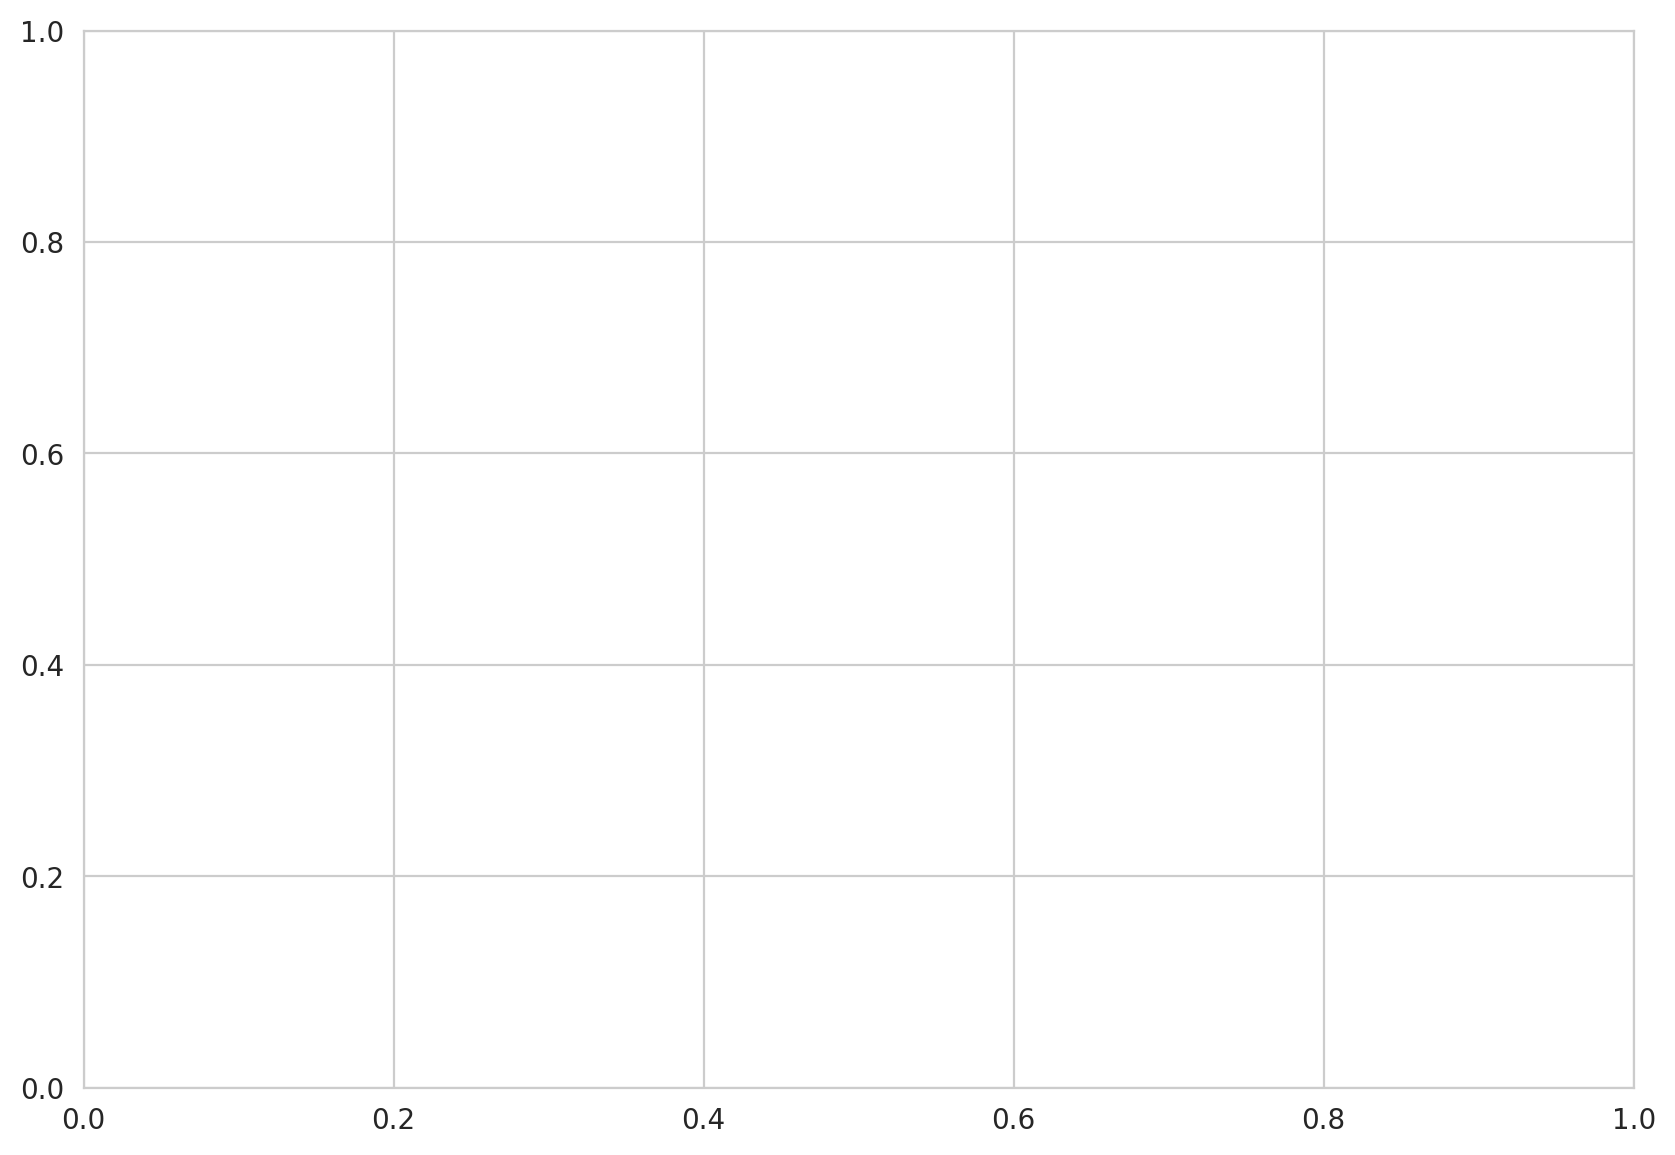

In [59]:
import matplotlib.colors as mcolors
list_frac_i =list_frac
len_stat=len(np.array(list_frac_i)[:,0,1])

nan_sep = np.full(len_stat,np.nan)
# liq
diff_12km_liq = -(np.array(list_frac_i)[:,0,1]-np.array(list_frac_i)[:,4,1])
diff_2p5km_liq = -(np.array(list_frac_i)[:,0,1]-np.array(list_frac_i)[:,5,1])
#sol
diff_12km_sol = -(np.array(list_frac_i)[:,0,0]-np.array(list_frac_i)[:,4,0])
diff_2p5km_sol = -(np.array(list_frac_i)[:,0,0]-np.array(list_frac_i)[:,5,0])
# fr
diff_12km_fr = -(np.array(list_frac_i)[:,0,2]-np.array(list_frac_i)[:,4,2])
diff_2p5km_fr = -(np.array(list_frac_i)[:,0,2]-np.array(list_frac_i)[:,5,2])
#mix
diff_12km_mix = -(np.array(list_frac_i)[:,0,4]-np.array(list_frac_i)[:,4,4])
diff_2p5km_mix = -(np.array(list_frac_i)[:,0,4]-np.array(list_frac_i)[:,5,4])
# mixfr
diff_12km_mixfr = -(np.array(list_frac_i)[:,0,3]-np.array(list_frac_i)[:,4,3])
diff_2p5km_mixfr = -(np.array(list_frac_i)[:,0,3]-np.array(list_frac_i)[:,5,3])

array_pcolor= np.array([nan_sep,diff_2p5km_liq,diff_12km_liq,
                        nan_sep,diff_2p5km_fr,diff_12km_fr,
                        nan_sep,diff_2p5km_mixfr,diff_12km_mixfr,
                        nan_sep,diff_2p5km_mix,diff_12km_mix,
                        nan_sep,diff_2p5km_sol,diff_12km_sol,nan_sep])


print(array_pcolor)
fig = plt.figure(facecolor='white',dpi=200,figsize=(10,7))
spec = fig.add_gridspec(ncols=1, nrows=1)
ax0 = fig.add_subplot(spec[0, 0])
bounds = np.arange(-1.5, 1.5+0.1, 0.1)

# cmap_1 = plt.get_cmap('seismic')
# cmap_2 = plt.get_cmap('seismic_r')
cmap_1 = plt.cm.winter(np.linspace(0., 1, 128))
cmap_2 = plt.cm.hot_r(np.linspace(0, 1, 128))
colors = np.vstack((cmap_1, cmap_2))
mymap = mcolors.LinearSegmentedColormap.from_list('my_colormap', colors)
norm = BoundaryNorm(bounds, ncolors=mymap.N+2, clip=True)


# colormesh = ax0.pcolormesh(x,x,array_pcolor,cmap='jet',norm=norm)
colormesh = ax0.pcolor(x, x, array_pcolor*100, facecolor='k', edgecolor='k',linewidth=1.5,cmap=mymap ,norm=norm )


ax0.set_xticks(x+0.5)
ax0.set_xticklabels(list_stat, rotation=45, ha='right')
ax0.set_xlabel('Stations', fontsize=12)
label_y = ['','CRCM6-2.5 km','LIQUID\nCRCM6-12 km\n','',
           'CRCM6-2.5 km','FR\nCRCM6-12 km\n','',
           'CRCM6-2.5 km','MIXFR\nCRCM6-12 km\n','',
           'CRCM6-2.5 km','MIX\nCRCM6-12 km\n','',
           'CRCM6-2.5 km','SOLID\nCRCM6-12 km\n','']
ax0.set_yticks(x+0.5)
ax0.set_yticklabels(label_y, rotation=0, ha='right')
ax1.set_xlabel('Stations', fontsize=12)
ax0.tick_params(which="both",bottom=True,labelbottom=True,left=False,labelleft=True)
ax0.set_xlim(x[0],x[-1])
ax0.set_ylim(x[0]+0.5,x[-1]+0.5)
cbar = plt.colorbar(colormesh,shrink=0.95, aspect=30,extend='both',ticks=bounds[::2])
cbar.set_label("Total accumualtion bias [$10^{-2}$ mm]", fontsize=10, labelpad=9)
cbar.ax.tick_params(labelsize=10)
plt.show()

# Annuelle

In [ ]:

fig = plt.figure(facecolor='white', dpi=200, figsize=(12, 4))
ax1 = plt.axes()
# ax2 = ax.twinx()
# 0:obs 1:11km 2:2.5km
# 0:frac_sol 1:frac_liq 2:frac_mix
# print(np.array(list_frac)[0])
# print(np.array(list_frac)[:,0,0])

width = 0.25
y_text = 1.05
x = np.arange(len(list_stat))

# obs
# solid

ax1.bar(x - width, np.array(list_frac_norm)[:, 0, 0], width=width, color='tab:blue', edgecolor='k')
bottom_obs = np.array(list_frac_norm)[:, 0, 0]
# mix cold
ax1.bar(x - width, np.array(list_frac_norm)[:, 0, 3], width=width, bottom=bottom_obs, color='tab:purple', edgecolor='k')
bottom_obs = bottom_obs + np.array(list_frac_norm)[:, 0, 3]
# mix hot
ax1.bar(x - width, np.array(list_frac_norm)[:, 0, 4], width=width, bottom=bottom_obs, color='tab:orange', edgecolor='k')
bottom_obs = bottom_obs + np.array(list_frac_norm)[:, 0, 4]
ax1.bar(x - width, np.array(list_frac_norm)[:, 0, 2], width=width, bottom=bottom_obs, color='tab:red', edgecolor='k')
bottom_obs = bottom_obs + np.array(list_frac_norm)[:, 0, 2]
# liq
ax1.bar(x - width, np.array(list_frac_norm)[:, 0, 1], width=width, bottom=bottom_obs, color='tab:green', edgecolor='k')
bottom_obs = bottom_obs + np.array(list_frac_norm)[:, 0, 1]
# zeros
ax1.bar(x - width, np.array(list_zeros_norm), width=width, bottom=bottom_obs, color='k', edgecolor='k')
bottom_obs = bottom_obs + np.array(list_zeros_norm)
# nan
# ax.bar(x-width,np.array(list_fnan),width=width,bottom=bottom_obs,color='k',edgecolor='grey')


# ax.text(0-width,1.02,'obs',rotation='vertical',horizontalalignment='center')
ax1.text(x[0] - width, y_text, 'Obs', rotation='vertical', horizontalalignment='center', fontsize=12)

# # ERA5
# # solid
# ax.bar(x-width*3/2,np.array(list_frac)[:,3,0],width=width,color='tab:blue',edgecolor='k')
# bottom_era5 = np.array(list_frac)[:,3,0]
# # mix cold
# ax.bar(x-width*3/2,np.array(list_frac)[:,3,3],width=width,bottom=bottom_era5,color='tab:purple',edgecolor='k')
# bottom_era5 = bottom_era5 + np.array(list_frac)[:,3,3]
# # mix hot
# ax.bar(x-width*3/2,np.array(list_frac)[:,3,4],width=width,bottom=bottom_era5,color='tab:orange',edgecolor='k')
# bottom_era5 = bottom_era5 + np.array(list_frac)[:,3,4]
# ax.bar(x-width*3/2,np.array(list_frac)[:,3,2],width=width,bottom=bottom_era5,color='tab:red',edgecolor='k')
# bottom_era5 = bottom_era5 + np.array(list_frac)[:,3,2]
# # liq
# ax.bar(x-width*3/2,np.array(list_frac)[:,3,1],width=width,bottom=bottom_era5,color='tab:green',edgecolor='k')
# bottom_era5 = bottom_era5 + np.array(list_frac)[:,3,1]
# nan
# ax.bar(x-width,np.array(list_fnan),width=width,bottom=bottom_obs,color='k',edgecolor='grey')

# ax.text(0-width,1.02,'obs',rotation='vertical',horizontalalignment='center')
# ax.text(x[0]-width*3/2,1.02,'ERA 5',rotation='vertical',horizontalalignment='center',fontsize=8)


# # 11km
# # solid
# ax.bar(x-width*1/2,np.array(list_frac)[:,1,0],width=width,color='tab:blue',edgecolor='k')
# bottom_11km = np.array(list_frac)[:,1,0]
# # mix cold
# ax.bar(x-width*1/2,np.array(list_frac)[:,1,3],width=width, bottom = bottom_11km,color='tab:purple',edgecolor='k')
# bottom_11km= bottom_11km + np.array(list_frac)[:,1,3]
# # mix hot
# ax.bar(x-width*1/2,np.array(list_frac)[:,1,4],width=width, bottom = bottom_11km,color='tab:orange',edgecolor='k')
# bottom_11km = bottom_11km + np.array(list_frac)[:,1,4]
# # fz
# ax.bar(x-width*1/2,np.array(list_frac)[:,1,2],width=width,bottom=bottom_11km,color='tab:red',edgecolor='k')
# bottom_11km = bottom_11km + np.array(list_frac)[:,1,2]
# # liq
# ax.bar(x-width*1/2,np.array(list_frac)[:,1,1],width=width,bottom=bottom_11km,color='tab:green',edgecolor='k')
# # ax.text(0,1.02,'12 km',rotation='vertical',horizontalalignment='center')
# ax.text(x[0]-width*1/2,1.02,'12 km',rotation='vertical',horizontalalignment='center',fontsize=8)

# 11km p3
# solid
ax1.bar(x, np.array(list_frac_norm)[:, 4, 0], width=width, color='tab:blue', edgecolor='k')
bottom_11kmp3 = np.array(list_frac_norm)[:, 4, 0]
# mix cold
ax1.bar(x, np.array(list_frac_norm)[:, 4, 3], width=width, bottom=bottom_11kmp3, color='tab:purple', edgecolor='k')
bottom_11kmp3 = bottom_11kmp3 + np.array(list_frac_norm)[:, 4, 3]
# mix hot
ax1.bar(x, np.array(list_frac_norm)[:, 4, 4], width=width, bottom=bottom_11kmp3, color='tab:orange', edgecolor='k')
bottom_11kmp3 = bottom_11kmp3 + np.array(list_frac_norm)[:, 4, 4]
# fz
ax1.bar(x, np.array(list_frac_norm)[:, 4, 2], width=width, bottom=bottom_11kmp3, color='tab:red', edgecolor='k')
bottom_11kmp3 = bottom_11kmp3 + np.array(list_frac_norm)[:, 4, 2]
# liq
ax1.bar(x, np.array(list_frac_norm)[:, 4, 1], width=width, bottom=bottom_11kmp3, color='tab:green', edgecolor='k')
# ax.text(0,1.02,'12 km',rotation='vertical',horizontalalignment='center')
ax1.text(x[0], y_text, '12 km', rotation='vertical', horizontalalignment='center', fontsize=12)

# 2p5km

# solid
# ax.bar(x+width*3/2,np.array(list_frac)[:,2,0],width=width,color='tab:blue',edgecolor='k')
# bottom_2p5km = np.array(list_frac)[:,2,0]
# mix cold
# ax.bar(x+width*3/2,np.array(list_frac)[:,2,3],width=width,bottom=bottom_2p5km,color='tab:purple',edgecolor='k')
# bottom_2p5km =bottom_2p5km+ np.array(list_frac)[:,2,3]
# mix hot
# ax.bar(x+width*3/2,np.array(list_frac)[:,2,4],width=width,bottom=bottom_2p5km,color='tab:orange',edgecolor='k')
# bottom_2p5km =bottom_2p5km+ np.array(list_frac)[:,2,4]
# fz
# ax.bar(x+width*3/2,np.array(list_frac)[:,2,2],width=width,bottom=bottom_2p5km,color='tab:red',edgecolor='k')
# bottom_2p5km = bottom_2p5km + np.array(list_frac)[:,2,2]
# liq
# ax.bar(x+width*3/2,np.array(list_frac)[:,2,1],width=width,bottom=bottom_2p5km,color='tab:green',edgecolor='k')
# ax.text(0+width,1.02,'2.5 km',rotation='vertical',horizontalalignment='center')
# ax.text(x[0]+width*3/2,1.02,'2.5 km',rotation='vertical',horizontalalignment='center',fontsize=8)

# 2p5km P3

# solid
ax1.bar(x + width, np.array(list_frac_norm)[:, 5, 0], width=width, color='tab:blue', edgecolor='k')
bottom_2p5km = np.array(list_frac_norm)[:, 5, 0]
# mix cold
ax1.bar(x + width, np.array(list_frac_norm)[:, 5, 3], width=width, bottom=bottom_2p5km, color='tab:purple', edgecolor='k')
bottom_2p5km = bottom_2p5km + np.array(list_frac_norm)[:, 5, 3]
# mix hot
ax1.bar(x + width, np.array(list_frac_norm)[:, 5, 4], width=width, bottom=bottom_2p5km, color='tab:orange', edgecolor='k')
bottom_2p5km = bottom_2p5km + np.array(list_frac_norm)[:, 5, 4]
# fz
ax1.bar(x + width, np.array(list_frac_norm)[:, 5, 2], width=width, bottom=bottom_2p5km, color='tab:red', edgecolor='k')
bottom_2p5km = bottom_2p5km + np.array(list_frac_norm)[:, 5, 2]
# liq
ax1.bar(x + width, np.array(list_frac_norm)[:, 5, 1], width=width, bottom=bottom_2p5km, color='tab:green', edgecolor='k')
# ax.text(0+width,1.02,'2.5 km',rotation='vertical',horizontalalignment='center')
ax1.text(x[0] + width, y_text, '2.5 km', rotation='vertical', horizontalalignment='center', fontsize=12)

# ax2.scatter(x,list_mean_speed,marker='s',s=20,facecolors='r',edgecolors='k')
#
# ax2.set_ylabel('Mean wind speed\nat gauge height [m/s]',fontsize=12)

ax1.set_ylim(0, 1)
ax1.set_xlim(x[0] - width * 2, x[-1] + width * 2)
time_text = f'{begin_date_1.strftime("%Y-%m")} to {end_date_1.strftime("%Y-%m")} &\n {begin_date_2.strftime("%Y-%m")} to {end_date_2.strftime("%Y-%m")}'

# ax.annotate(f'{time_text}', xy=(0.78, 1.01), xycoords='axes fraction', fontsize=14)

ax1.set_xticks(x)
ax1.set_xticklabels(list_stat, rotation=45, ha='right')
# ax.set_ylabel('Precipitation type fraction',fontsize=12)
ax1.set_ylabel('Fraction of the\n total precipitation amount [-]', fontsize=12)
ax1.set_xlabel('Stations', fontsize=12)

ax.legend(['Solid', 'Mix of Freezing rain and Solid', 'Mix of Liquid and Solid', 'Freezing Rain', 'Liquid',
           'Non categorized'], loc='upper center', bbox_to_anchor=(0.5, 1.25), ncol=3)
# image_savepath = fr"/upslope/chalifour/projet_maitrise/fig/carte_stat_pie/closest_pt/stat_frac_chart_qty_2years"
image_savepath = fr"/upslope/chalifour/projet_maitrise/fig/carte_stat_pie/stat_frac_chart_qty_{subdf.index[0].strftime('%Y')}_{subdf.index[-1].strftime('%Y')}"
fig.savefig(image_savepath + ".png", dpi=200, format='png', bbox_inches='tight')
fig.savefig(image_savepath + ".eps", dpi=200, format='eps', bbox_inches='tight')
plt.show()